**`Magister in Data Science`**: `Introduction to Data Science`  
**`University of Skövde`**         
**`Assignment`**: `DS mini project`            
**`Student`**: `Valery Nkenguruke`    
**`Date`**: `09 december 2025`







# **NBA physique and performance: how much do height, weight, age, and position explain box-score outcomes?**

## **0.1 Abstract**

This project investigates how strongly NBA players’ basic physical profiles and listed positions explain their on-court box-score output. The analysis focuses on height (inches), weight (lb), age, and position (PG/SG/SF/PF/C) as inputs and studies several per-100-possession statistics as targets, with particular emphasis on rebounds (TRB/100), blocks (BLK/100), and assists (AST/100).

A merged play-by-play / box-score dataset covering regular seasons from 1996–97 to 2024–25 is constructed, aggregated to one row per player–season, and filtered to players with at least 500 minutes played. After exploratory analysis of size distributions and correlations, a sequence of models is fitted: simple baselines, additive linear models (Ridge/Lasso), and a non-linear Random Forest. Both grouped cross-validation (by player) and expanding walk-forward validation (by season) are used to avoid data leakage and to probe temporal stability.

The results show a clear hierarchy of predictability. Physique and position explain a large share of the variance in rebounding and shot-blocking (walk-forward R² in the ~0.7 range for TRB/100 and ~0.5 range for BLK/100), and a moderate share for AST/100 (R² around ~0.6 with Random Forest). In contrast, scoring volume and shooting efficiency are only weakly predictable from body size and listed role alone. Non-linear models consistently outperform linear ones on the same inputs, indicating that the underlying relationships are interaction-rich and non-linear rather than purely additive.

Diagnostic figures based on residuals by position, marginal effects, and size–performance shape plots confirm that the patterns are stable over time and largely aligned with basketball domain knowledge: classic interior bigs are dominant rebounders and shot-blockers, some guards substantially overperform their size in rebounds and assists, and modern “playmaking bigs” are visible in residual patterns. Overall, the project supports the view that body size and nominal position provide a strong but incomplete prior over a player’s statistical profile, and that tactical context and skill are essential for explaining scoring and efficiency beyond physique.


## **0.2 Problem framing and assumptions**

The modern NBA produces rich play-by-play and box-score data for every game, making the league a convenient “laboratory” for studying how physical characteristics relate to performance. Front offices and fans frequently talk about players as “undersized centers”, “big guards”, or “small-ball fours”, implicitly assuming a link between body type, nominal position, and statistical output.

This project formalises that intuition as a predictive question:

> **Given only a player’s height, weight, age, and listed position at the start of a season, how well can key per-100-possession box-score statistics be predicted?**

The focus is deliberately narrow on four low-information, widely available inputs:

- **Height** in inches (`ht_in_in`)
- **Weight** in pounds (`wt`)
- **Age** at season start (`age`)
- **Nominal position** (`pos` $\in$ {PG, SG, SF, PF, C})

These variables are treated as a crude but realistic proxy for the information that might be available about a player’s physical profile and role *before* observing that season’s games. In particular, no play-by-play context, usage metrics, or advanced shooting data are used as inputs to the models that predict the basic box-score stats.

### **Hypotheses**
This project tests three specific hypotheses to guide the modeling strategy:
1.  **$H_1$ (The Structural Hypothesis):** Tasks dependent on space occupation (Rebounding, Blocking) will show strong predictive signal from height and weight alone.
2.  **$H_2$ (The Skill Hypothesis):** Tasks dependent on coordination and usage (Scoring, Shooting Efficiency) will show near-zero signal from physical features, as skill acts as a confounding variable not captured by body size.
3.  **$H_3$ (The Complexity Hypothesis):** The relationship between size and performance is non-linear (e.g., being heavy is penalized for guards but rewarded for centers), requiring tree-based models to capture the signal fully.

### **Data Sources**
The analysis integrates multiple datasets to construct a complete view of physical and statistical profiles:
- **Player Career Info.csv**: Source of fixed physical attributes (Height, Weight).
- **Per 100 Poss.csv**: Main source for target variables (Rates per 100 possessions), ensuring pace-neutral comparisons.
- **Player Shooting.csv**: Source for efficiency metrics (e.g., eFG%) and shot distance splits.
- **Player Per Game.csv / Totals.csv**: Used for quality filtering (minutes played) and aggregation validation.

To keep the problem well-posed and comparable across eras, the following assumptions and design choices are applied:

- **Regular-season, player-season level.** Each row represents a single player’s regular-season performance in a given season. Playoff games are excluded to avoid sample-size artifacts.
- **Era consistency (1997–2025).** The analysis is restricted to the era where detailed shooting data is available (1996–97 onward) to ensure a consistent feature set across all models. The in-progress 2026 season is excluded to ensure data completeness.
- **Minimum playing time.** Player-seasons with fewer than 500 minutes are removed to avoid highly noisy stat lines from fringe players and two-way contracts.
- **Per-100-possession scaling.** Box-score statistics are expressed per 100 team possessions to control for pace differences across teams and eras.
- **Standardised position labels.** Positions from the raw data are mapped to the canonical five (PG, SG, SF, PF, C). Hybrid or ambiguous labels are resolved using a simple transformation table documented later in the notebook.
- **Physique as prior, not destiny.** The goal is not to claim that body size “determines” performance, but to quantify how much of the observed variance in box-score outcomes can be explained by body size and nominal role alone.

Under this framing, the rest of the analysis asks three related questions:

1. **Exploratory:** How are height, weight, age, and position distributed across eras, and how do they correlate with different box-score statistics?
2. **Predictive:** For which statistics (e.g., TRB/100, BLK/100, AST/100, scoring, efficiency) does physique plus position provide substantial predictive signal, and how does non-linearity (Random Forest vs linear models) change that picture?
3. **Robustness:** Do these relationships hold across time when evaluated with grouped and walk-forward schemes, and are the resulting models well-calibrated and reasonably unbiased across positions?

The later sections of the notebook follow a full data science cycle around this framing: data preparation and cleaning, initial exploration, model specification and evaluation, diagnostic checks, and a final discussion of findings, limitations, and possible extensions.




## **1. Load files and perform a quick audit**

**Purpose.** Load the player datasets and run a light structural audit before any modeling or heavy cleaning. This step implements the initial data audit outlined in Section 0.2.

**Objectives.**
- Verify that all required CSV files can be read without errors.
- Inspect row counts and key columns for each file.
- Display a small sample of rows to understand naming, units, and missing-value patterns.
- Examine height/weight formatting to plan conversion to numeric inches and pounds.
- Inspect season key formats to decide on a unified season identifier (e.g., season-end year as an integer).

This quick audit establishes what is actually available in the raw data and informs the subsequent cleaning, parsing, and alignment steps.


In [6]:
# --- Imports ---------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling & Evaluation
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Reproducibility -------------------------------------------------------
SEED = 42
RNG = np.random.default_rng(SEED)

# --- Pandas display (for nicer notebooks) ---------------------------------
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# --- Matplotlib defaults ---------------------------------------------------
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 110

# --- Canonical season window ----------------------------------------------
# With Shooting included, 1996–97 onward (season key = 1997).
START_POSSESSION_YEAR = 1997
LAST_COMPLETE = 2025     # last fully completed season
IN_PROGRESS = 2026       # exclude by default

# --- Minutes/game guard to reduce tiny samples -----------------------------
MIN_MINUTES = 500
MIN_GAMES   = 40
MIN_MPG     = 10

def apply_minutes_guard(df):
    """Filter out tiny-sample seasons using minutes or games+mpg, if available."""
    if "mp" in df.columns:
        return df[df["mp"] >= MIN_MINUTES]
    if {"mp_per_game", "g"}.issubset(df.columns):
        return df[(df["g"] >= MIN_GAMES) & (df["mp_per_game"] >= MIN_MPG)]
    return df

# --- Load Data -------------------------------------------------------------
RAW = {
    "Per100":       "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Per%20100%20Poss.csv",
    "Career":       "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Career%20Info.csv",
    "PerGame":      "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Per%20Game.csv",
    "Shooting":     "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Shooting.csv",
    "Totals":       "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Totals.csv",
}

# Load into DataFrames
df_per100     = pd.read_csv(RAW["Per100"], low_memory=False)
df_career     = pd.read_csv(RAW["Career"], low_memory=False)
df_pergame    = pd.read_csv(RAW["PerGame"], low_memory=False)
df_shooting   = pd.read_csv(RAW["Shooting"], low_memory=False)
df_totals     = pd.read_csv(RAW["Totals"], low_memory=False)

def brief_audit(name, df, show_cols=20, n_head=5):
    """Print a compact structure audit for a DataFrame."""
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} cols")
    print("Columns (first):", list(df.columns[:show_cols]))
    display(df.head(n_head))

# Structural audits
brief_audit("Player Career Info", df_career)
brief_audit("Per 100 Poss",       df_per100)
brief_audit("Player Shooting",    df_shooting)
brief_audit("Player Per Game",    df_pergame)
brief_audit("Player Totals",      df_totals)

# Focused peeks for planning the cleaning/joins
def peek_values(df, cols, n=10):
    """Show a few non-null examples for specific columns (if present)."""
    for c in cols:
        if c in df.columns:
            sample = df[c].dropna().astype(str).head(n).tolist()
            print(f"  {c}: {sample}")

print("\n--- Focused inspections ---")
print("[Career] Height/Weight examples:")
peek_values(df_career, ["Height", "height", "Ht", "HT", "ht_in_in", "Weight", "weight", "Wt", "WT", "wt"])

print("\n[Season keys] Examples to understand season alignment:")
peek_values(df_per100,     ["Season", "season", "Season_End", "season_end", "Year", "year"])

print("\nNotes:")
print("- A single season key (e.g., season_end year) will be standardized across tables.")
print("- Height will be converted from feet–inches to total inches; weight will be kept in lbs.")
print("- A minutes threshold will be set later to remove tiny-sample seasons before modeling.")

# Season order & coverage checks
print("\n--- Season checks (Per100) ---")
print("Top seasons (head):", df_per100["season"].head(5).tolist())
print("Bottom seasons (tail):", df_per100["season"].tail(5).tolist())

# Check for 2026 presence explicitly
print("\nValue counts by season (last 10 years):")
print(df_per100["season"].value_counts().sort_index().tail(10))

# To exclude the in-progress season by default:
df_per100_historical = df_per100[df_per100["season"] < IN_PROGRESS]
print(f"\nHistorical Per100 rows (< {IN_PROGRESS}):", df_per100_historical.shape[0])


=== Player Career Info ===
Shape: 5,369 rows × 11 cols
Columns (first): ['player', 'player_id', 'pos', 'ht_in_in', 'wt', 'birth_date', 'colleges', 'from', 'to', 'debut', 'hof']


,player,player_id,pos,ht_in_in,wt,birth_date,colleges,from,to,debut,hof
0,Hank Biasatti,biasaha01,G,71,175.0,1922-01-14,Assumption University,1947,1947,1946-11-01T00:00:00Z,False
1,Tommy Byrnes,byrneto01,F-G,75,175.0,1923-02-19,Seton Hall,1947,1951,1946-11-01T00:00:00Z,False
2,Bob Fitzgerald,fitzgbo01,F-C,77,190.0,1923-03-14,Seton Hall,1947,1949,1946-11-01T00:00:00Z,False
3,Dick Fitzgerald,fitzgdi01,F,74,175.0,1920-11-18,Fordham,1947,1948,1946-11-01T00:00:00Z,False
4,Frank Fucarino,fucarfr01,F,74,175.0,1920-07-24,Long Island University,1947,1947,1946-11-01T00:00:00Z,False



=== Per 100 Poss ===
Shape: 27,387 rows × 34 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg_per_100_poss', 'fga_per_100_poss', 'fg_percent', 'x3p_per_100_poss', 'x3pa_per_100_poss', 'x3p_percent', 'x2p_per_100_poss', 'x2pa_per_100_poss', 'x2p_percent', 'e_fg_percent']


,season,lg,player,player_id,age,team,pos,g,gs,mp,fg_per_100_poss,fga_per_100_poss,fg_percent,x3p_per_100_poss,x3pa_per_100_poss,x3p_percent,x2p_per_100_poss,x2pa_per_100_poss,x2p_percent,e_fg_percent,ft_per_100_poss,fta_per_100_poss,ft_percent,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg,d_rtg
0,2026,NBA,Steven Adams,adamsst01,32,HOU,C,4,2.0,98,5.1,7.7,0.667,0.0,0.0,NaN,5.1,7.7,0.667,0.667,5.6,6.2,0.917,12.3,9.8,22.1,3.1,2.1,1.0,3.1,5.1,15.9,151.0,115.0
1,2026,NBA,Bam Adebayo,adebaba01,28,MIA,C,5,5.0,168,10.5,24.3,0.433,3.5,9.7,0.361,7.0,14.6,0.481,0.506,6.5,7.3,0.889,1.9,10.5,12.4,3.8,0.8,0.3,3.8,2.7,31.1,108.0,108.0
2,2026,NBA,Ochai Agbaji,agbajoc01,25,TOR,SG,6,0.0,90,3.6,9.8,0.368,0.5,4.6,0.111,3.1,5.2,0.600,0.395,2.6,4.1,0.625,1.0,6.7,7.7,3.1,2.6,0.5,1.0,6.2,10.3,99.0,117.0
3,2026,NBA,Santi Aldama,aldamsa01,25,MEM,PF,6,0.0,144,8.7,19.9,0.435,2.2,7.7,0.292,6.4,12.2,0.526,0.492,0.3,1.9,0.167,4.5,10.9,15.4,4.8,2.9,1.3,2.6,3.2,19.9,102.0,111.0
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27,ATL,SG,6,3.0,182,9.6,22.0,0.435,3.1,10.4,0.300,6.5,11.7,0.556,0.506,4.1,4.9,0.842,1.3,3.1,4.4,4.9,2.3,1.3,2.1,1.8,26.4,111.0,117.0



=== Player Shooting ===
Shape: 17,949 rows × 32 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg_percent', 'avg_dist_fga', 'percent_fga_from_x2p_range', 'percent_fga_from_x0_3_range', 'percent_fga_from_x3_10_range', 'percent_fga_from_x10_16_range', 'percent_fga_from_x16_3p_range', 'percent_fga_from_x3p_range', 'fg_percent_from_x2p_range', 'fg_percent_from_x0_3_range']


,season,lg,player,player_id,age,team,pos,g,gs,mp,fg_percent,avg_dist_fga,percent_fga_from_x2p_range,percent_fga_from_x0_3_range,percent_fga_from_x3_10_range,percent_fga_from_x10_16_range,percent_fga_from_x16_3p_range,percent_fga_from_x3p_range,fg_percent_from_x2p_range,fg_percent_from_x0_3_range,fg_percent_from_x3_10_range,fg_percent_from_x10_16_range,fg_percent_from_x16_3p_range,fg_percent_from_x3p_range,percent_assisted_x2p_fg,percent_assisted_x3p_fg,percent_dunks_of_fga,num_of_dunks,percent_corner_3s_of_3pa,corner_3_point_percent,num_heaves_attempted,num_heaves_made
0,2026,NBA,Steven Adams,adamsst01,32,HOU,C,4,2,98,0.667,1.1,1.000,0.933,0.067,0.000,0.000,0.000,0.667,0.643,1.000,NaN,NaN,NaN,0.300,NaN,0.133,2,NaN,NaN,0,0
1,2026,NBA,Bam Adebayo,adebaba01,28,MIA,C,5,5,168,0.433,14.2,0.600,0.189,0.233,0.144,0.033,0.400,0.481,0.706,0.381,0.385,0.333,0.361,0.692,1.000,0.078,7,0.472,0.471,0,0
2,2026,NBA,Ochai Agbaji,agbajoc01,25,TOR,SG,6,0,90,0.368,12.5,0.526,0.474,0.053,0.000,0.000,0.474,0.600,0.667,0.000,NaN,NaN,0.111,0.833,1.000,0.158,2,0.444,0.000,0,0
3,2026,NBA,Santi Aldama,aldamsa01,25,MEM,PF,6,0,144,0.435,13.6,0.613,0.210,0.323,0.016,0.065,0.387,0.526,0.538,0.550,1.000,0.250,0.292,0.800,1.000,0.016,1,0.250,0.500,0,0
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27,ATL,SG,6,3,182,0.435,15.3,0.529,0.224,0.176,0.059,0.071,0.471,0.556,0.684,0.600,0.400,0.167,0.300,0.480,0.917,0.012,1,0.200,0.375,0,0



=== Player Per Game ===
Shape: 33,034 rows × 32 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent']


,season,lg,player,player_id,age,team,pos,g,gs,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,x2pa_per_game,x2p_percent,e_fg_percent,ft_per_game,fta_per_game,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,2026,NBA,Steven Adams,adamsst01,32.0,HOU,C,4,2.0,24.5,2.5,3.8,0.667,0.0,0.0,NaN,2.5,3.8,0.667,0.667,2.8,3.0,0.917,6.0,4.8,10.8,1.5,1.0,0.5,1.5,2.5,7.8
1,2026,NBA,Bam Adebayo,adebaba01,28.0,MIA,C,5,5.0,33.6,7.8,18.0,0.433,2.6,7.2,0.361,5.2,10.8,0.481,0.506,4.8,5.4,0.889,1.4,7.8,9.2,2.8,0.6,0.2,2.8,2.0,23.0
2,2026,NBA,Ochai Agbaji,agbajoc01,25.0,TOR,SG,6,0.0,15.0,1.2,3.2,0.368,0.2,1.5,0.111,1.0,1.7,0.600,0.395,0.8,1.3,0.625,0.3,2.2,2.5,1.0,0.8,0.2,0.3,2.0,3.3
3,2026,NBA,Santi Aldama,aldamsa01,25.0,MEM,PF,6,0.0,24.0,4.5,10.3,0.435,1.2,4.0,0.292,3.3,6.3,0.526,0.492,0.2,1.0,0.167,2.3,5.7,8.0,2.5,1.5,0.7,1.3,1.7,10.3
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27.0,ATL,SG,6,3.0,30.3,6.2,14.2,0.435,2.0,6.7,0.300,4.2,7.5,0.556,0.506,2.7,3.2,0.842,0.8,2.0,2.8,3.2,1.5,0.8,1.3,1.2,17.0



=== Player Totals ===
Shape: 33,034 rows × 33 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_percent', 'x3p', 'x3pa', 'x3p_percent', 'x2p', 'x2pa', 'x2p_percent', 'e_fg_percent']


,season,lg,player,player_id,age,team,pos,g,gs,mp,fg,fga,fg_percent,x3p,x3pa,x3p_percent,x2p,x2pa,x2p_percent,e_fg_percent,ft,fta,ft_percent,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
0,2026,NBA,Steven Adams,adamsst01,32.0,HOU,C,4,2.0,98.0,10,15,0.667,0.0,0.0,NaN,10.0,15.0,0.667,0.667,11,12,0.917,24.0,19.0,43.0,6,4.0,2.0,6.0,10.0,31,0.0
1,2026,NBA,Bam Adebayo,adebaba01,28.0,MIA,C,5,5.0,168.0,39,90,0.433,13.0,36.0,0.361,26.0,54.0,0.481,0.506,24,27,0.889,7.0,39.0,46.0,14,3.0,1.0,14.0,10.0,115,0.0
2,2026,NBA,Ochai Agbaji,agbajoc01,25.0,TOR,SG,6,0.0,90.0,7,19,0.368,1.0,9.0,0.111,6.0,10.0,0.600,0.395,5,8,0.625,2.0,13.0,15.0,6,5.0,1.0,2.0,12.0,20,0.0
3,2026,NBA,Santi Aldama,aldamsa01,25.0,MEM,PF,6,0.0,144.0,27,62,0.435,7.0,24.0,0.292,20.0,38.0,0.526,0.492,1,6,0.167,14.0,34.0,48.0,15,9.0,4.0,8.0,10.0,62,0.0
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27.0,ATL,SG,6,3.0,182.0,37,85,0.435,12.0,40.0,0.300,25.0,45.0,0.556,0.506,16,19,0.842,5.0,12.0,17.0,19,9.0,5.0,8.0,7.0,102,0.0



--- Focused inspections ---
[Career] Height/Weight examples:
  ht_in_in: ['71', '75', '77', '74', '74', '71', '70', '69', '74', '74']
  wt: ['175.0', '175.0', '190.0', '175.0', '175.0', '180.0', '175.0', '158.0', '170.0', '170.0']

[Season keys] Examples to understand season alignment:
  season: ['2026', '2026', '2026', '2026', '2026', '2026', '2026', '2026', '2026', '2026']

Notes:
- A single season key (e.g., season_end year) will be standardized across tables.
- Height will be converted from feet–inches to total inches; weight will be kept in lbs.
- A minutes threshold will be set later to remove tiny-sample seasons before modeling.

--- Season checks (Per100) ---
Top seasons (head): [2026, 2026, 2026, 2026, 2026]
Bottom seasons (tail): [1974, 1974, 1974, 1974, 1974]

Value counts by season (last 10 years):
season
2017    595
2018    664
2019    708
2020    651
2021    705
2022    812
2023    679
2024    735
2025    735
2026    428
Name: count, dtype: int64

Historical Per100 rows 

In [7]:
# --- Imports ---------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling & Evaluation
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Reproducibility -------------------------------------------------------
SEED = 42
RNG = np.random.default_rng(SEED)

# --- Pandas display (for nicer notebooks) ---------------------------------
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

# --- Matplotlib defaults ---------------------------------------------------
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 110

# --- Plot footnote helper --------------------------------------------------
def add_scope_note():
    """Add a small scope note under the current figure."""
    plt.figtext(
        0.01,
        -0.06,
        "Shooting and per-possession stats used here cover 1997–2025; 2026 is treated as in-progress and omitted.",
        ha="left",
        va="top",
        fontsize=9,
    )

# --- Canonical season window ----------------------------------------------
# With Shooting included, 1996–97 onward (season key = 1997).
START_POSSESSION_YEAR = 1997
LAST_COMPLETE = 2025     # last fully completed season
IN_PROGRESS = 2026       # exclude by default

# --- Minutes/game guard to reduce tiny samples -----------------------------
MIN_MINUTES = 500
MIN_GAMES   = 40
MIN_MPG     = 10

def apply_minutes_guard(df):
    """Filter out tiny-sample seasons using minutes or games+mpg, if available."""
    if "mp" in df.columns:
        return df[df["mp"] >= MIN_MINUTES]
    if {"mp_per_game", "g"}.issubset(df.columns):
        return df[(df["g"] >= MIN_GAMES) & (df["mp_per_game"] >= MIN_MPG)]
    return df

# --- Load Data -------------------------------------------------------------
RAW = {
    "Per100":   "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Per%20100%20Poss.csv",
    "Career":   "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Career%20Info.csv",
    "PerGame":  "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Per%20Game.csv",
    "Shooting": "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Shooting.csv",
    "Totals":   "https://raw.githubusercontent.com/valnke03/Can-body-size-predict-an-NBA-player-s-stat-profile-/refs/heads/main/Player%20Totals.csv",
}

# Load into DataFrames
df_per100   = pd.read_csv(RAW["Per100"], low_memory=False)
df_career   = pd.read_csv(RAW["Career"], low_memory=False)
df_pergame  = pd.read_csv(RAW["PerGame"], low_memory=False)
df_shooting = pd.read_csv(RAW["Shooting"], low_memory=False)
df_totals   = pd.read_csv(RAW["Totals"], low_memory=False)

def brief_audit(name, df, show_cols=20, n_head=5):
    """Print a compact structure audit for a DataFrame."""
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} cols")
    print("Columns (first):", list(df.columns[:show_cols]))
    display(df.head(n_head))

# Structural audits
brief_audit("Player Career Info", df_career)
brief_audit("Per 100 Possessions (Per100)", df_per100)
brief_audit("Player Shooting",    df_shooting)
brief_audit("Player Per Game",    df_pergame)
brief_audit("Player Totals",      df_totals)

# Focused peeks for planning the cleaning/joins
def peek_values(df, cols, n=10):
    """Show a few non-null examples for specific columns (if present)."""
    for c in cols:
        if c in df.columns:
            sample = df[c].dropna().astype(str).head(n).tolist()
            print(f"  {c}: {sample}")

print("\n--- Focused inspections ---")
print("[Career] Height/Weight examples:")
peek_values(df_career, ["Height", "height", "Ht", "HT", "ht_in_in", "Weight", "weight", "Wt", "WT", "wt"])

print("\n[Season keys] Examples to understand season alignment:")
peek_values(df_per100, ["Season", "season", "Season_End", "season_end", "Year", "year"])

print("\nNotes:")
print("- A single season key (for example, a season_end year) will be standardized across tables.")
print("- Height will be converted from feet–inches to total inches; weight will be kept in lbs.")
print(f"- Seasons with key >= {IN_PROGRESS} are treated as in-progress and excluded from modeling.")
print("- A minutes threshold will be set later to remove tiny-sample seasons before modeling.")

# Season order & coverage checks
print("\n--- Season checks (Per100) ---")
print("Top seasons (head):", df_per100["season"].head(5).tolist())
print("Bottom seasons (tail):", df_per100["season"].tail(5).tolist())

# Check for 2026 presence explicitly
print("\nValue counts by season (last 10 years):")
print(df_per100["season"].value_counts().sort_index().tail(10))

# To exclude the in-progress season by default:
df_per100_historical = df_per100[df_per100["season"] < IN_PROGRESS]
print(f"\nHistorical Per100 rows (< {IN_PROGRESS}):", df_per100_historical.shape[0])


=== Player Career Info ===
Shape: 5,369 rows × 11 cols
Columns (first): ['player', 'player_id', 'pos', 'ht_in_in', 'wt', 'birth_date', 'colleges', 'from', 'to', 'debut', 'hof']


,player,player_id,pos,ht_in_in,wt,birth_date,colleges,from,to,debut,hof
0,Hank Biasatti,biasaha01,G,71,175.0,1922-01-14,Assumption University,1947,1947,1946-11-01T00:00:00Z,False
1,Tommy Byrnes,byrneto01,F-G,75,175.0,1923-02-19,Seton Hall,1947,1951,1946-11-01T00:00:00Z,False
2,Bob Fitzgerald,fitzgbo01,F-C,77,190.0,1923-03-14,Seton Hall,1947,1949,1946-11-01T00:00:00Z,False
3,Dick Fitzgerald,fitzgdi01,F,74,175.0,1920-11-18,Fordham,1947,1948,1946-11-01T00:00:00Z,False
4,Frank Fucarino,fucarfr01,F,74,175.0,1920-07-24,Long Island University,1947,1947,1946-11-01T00:00:00Z,False



=== Per 100 Possessions (Per100) ===
Shape: 27,387 rows × 34 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg_per_100_poss', 'fga_per_100_poss', 'fg_percent', 'x3p_per_100_poss', 'x3pa_per_100_poss', 'x3p_percent', 'x2p_per_100_poss', 'x2pa_per_100_poss', 'x2p_percent', 'e_fg_percent']


,season,lg,player,player_id,age,team,pos,g,gs,mp,fg_per_100_poss,fga_per_100_poss,fg_percent,x3p_per_100_poss,x3pa_per_100_poss,x3p_percent,x2p_per_100_poss,x2pa_per_100_poss,x2p_percent,e_fg_percent,ft_per_100_poss,fta_per_100_poss,ft_percent,orb_per_100_poss,drb_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,pf_per_100_poss,pts_per_100_poss,o_rtg,d_rtg
0,2026,NBA,Steven Adams,adamsst01,32,HOU,C,4,2.0,98,5.1,7.7,0.667,0.0,0.0,NaN,5.1,7.7,0.667,0.667,5.6,6.2,0.917,12.3,9.8,22.1,3.1,2.1,1.0,3.1,5.1,15.9,151.0,115.0
1,2026,NBA,Bam Adebayo,adebaba01,28,MIA,C,5,5.0,168,10.5,24.3,0.433,3.5,9.7,0.361,7.0,14.6,0.481,0.506,6.5,7.3,0.889,1.9,10.5,12.4,3.8,0.8,0.3,3.8,2.7,31.1,108.0,108.0
2,2026,NBA,Ochai Agbaji,agbajoc01,25,TOR,SG,6,0.0,90,3.6,9.8,0.368,0.5,4.6,0.111,3.1,5.2,0.600,0.395,2.6,4.1,0.625,1.0,6.7,7.7,3.1,2.6,0.5,1.0,6.2,10.3,99.0,117.0
3,2026,NBA,Santi Aldama,aldamsa01,25,MEM,PF,6,0.0,144,8.7,19.9,0.435,2.2,7.7,0.292,6.4,12.2,0.526,0.492,0.3,1.9,0.167,4.5,10.9,15.4,4.8,2.9,1.3,2.6,3.2,19.9,102.0,111.0
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27,ATL,SG,6,3.0,182,9.6,22.0,0.435,3.1,10.4,0.300,6.5,11.7,0.556,0.506,4.1,4.9,0.842,1.3,3.1,4.4,4.9,2.3,1.3,2.1,1.8,26.4,111.0,117.0



=== Player Shooting ===
Shape: 17,949 rows × 32 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg_percent', 'avg_dist_fga', 'percent_fga_from_x2p_range', 'percent_fga_from_x0_3_range', 'percent_fga_from_x3_10_range', 'percent_fga_from_x10_16_range', 'percent_fga_from_x16_3p_range', 'percent_fga_from_x3p_range', 'fg_percent_from_x2p_range', 'fg_percent_from_x0_3_range']


,season,lg,player,player_id,age,team,pos,g,gs,mp,fg_percent,avg_dist_fga,percent_fga_from_x2p_range,percent_fga_from_x0_3_range,percent_fga_from_x3_10_range,percent_fga_from_x10_16_range,percent_fga_from_x16_3p_range,percent_fga_from_x3p_range,fg_percent_from_x2p_range,fg_percent_from_x0_3_range,fg_percent_from_x3_10_range,fg_percent_from_x10_16_range,fg_percent_from_x16_3p_range,fg_percent_from_x3p_range,percent_assisted_x2p_fg,percent_assisted_x3p_fg,percent_dunks_of_fga,num_of_dunks,percent_corner_3s_of_3pa,corner_3_point_percent,num_heaves_attempted,num_heaves_made
0,2026,NBA,Steven Adams,adamsst01,32,HOU,C,4,2,98,0.667,1.1,1.000,0.933,0.067,0.000,0.000,0.000,0.667,0.643,1.000,NaN,NaN,NaN,0.300,NaN,0.133,2,NaN,NaN,0,0
1,2026,NBA,Bam Adebayo,adebaba01,28,MIA,C,5,5,168,0.433,14.2,0.600,0.189,0.233,0.144,0.033,0.400,0.481,0.706,0.381,0.385,0.333,0.361,0.692,1.000,0.078,7,0.472,0.471,0,0
2,2026,NBA,Ochai Agbaji,agbajoc01,25,TOR,SG,6,0,90,0.368,12.5,0.526,0.474,0.053,0.000,0.000,0.474,0.600,0.667,0.000,NaN,NaN,0.111,0.833,1.000,0.158,2,0.444,0.000,0,0
3,2026,NBA,Santi Aldama,aldamsa01,25,MEM,PF,6,0,144,0.435,13.6,0.613,0.210,0.323,0.016,0.065,0.387,0.526,0.538,0.550,1.000,0.250,0.292,0.800,1.000,0.016,1,0.250,0.500,0,0
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27,ATL,SG,6,3,182,0.435,15.3,0.529,0.224,0.176,0.059,0.071,0.471,0.556,0.684,0.600,0.400,0.167,0.300,0.480,0.917,0.012,1,0.200,0.375,0,0



=== Player Per Game ===
Shape: 33,034 rows × 32 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp_per_game', 'fg_per_game', 'fga_per_game', 'fg_percent', 'x3p_per_game', 'x3pa_per_game', 'x3p_percent', 'x2p_per_game', 'x2pa_per_game', 'x2p_percent', 'e_fg_percent']


,season,lg,player,player_id,age,team,pos,g,gs,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,x2pa_per_game,x2p_percent,e_fg_percent,ft_per_game,fta_per_game,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,2026,NBA,Steven Adams,adamsst01,32.0,HOU,C,4,2.0,24.5,2.5,3.8,0.667,0.0,0.0,NaN,2.5,3.8,0.667,0.667,2.8,3.0,0.917,6.0,4.8,10.8,1.5,1.0,0.5,1.5,2.5,7.8
1,2026,NBA,Bam Adebayo,adebaba01,28.0,MIA,C,5,5.0,33.6,7.8,18.0,0.433,2.6,7.2,0.361,5.2,10.8,0.481,0.506,4.8,5.4,0.889,1.4,7.8,9.2,2.8,0.6,0.2,2.8,2.0,23.0
2,2026,NBA,Ochai Agbaji,agbajoc01,25.0,TOR,SG,6,0.0,15.0,1.2,3.2,0.368,0.2,1.5,0.111,1.0,1.7,0.600,0.395,0.8,1.3,0.625,0.3,2.2,2.5,1.0,0.8,0.2,0.3,2.0,3.3
3,2026,NBA,Santi Aldama,aldamsa01,25.0,MEM,PF,6,0.0,24.0,4.5,10.3,0.435,1.2,4.0,0.292,3.3,6.3,0.526,0.492,0.2,1.0,0.167,2.3,5.7,8.0,2.5,1.5,0.7,1.3,1.7,10.3
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27.0,ATL,SG,6,3.0,30.3,6.2,14.2,0.435,2.0,6.7,0.300,4.2,7.5,0.556,0.506,2.7,3.2,0.842,0.8,2.0,2.8,3.2,1.5,0.8,1.3,1.2,17.0



=== Player Totals ===
Shape: 33,034 rows × 33 cols
Columns (first): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg', 'fga', 'fg_percent', 'x3p', 'x3pa', 'x3p_percent', 'x2p', 'x2pa', 'x2p_percent', 'e_fg_percent']


,season,lg,player,player_id,age,team,pos,g,gs,mp,fg,fga,fg_percent,x3p,x3pa,x3p_percent,x2p,x2pa,x2p_percent,e_fg_percent,ft,fta,ft_percent,orb,drb,trb,ast,stl,blk,tov,pf,pts,trp_dbl
0,2026,NBA,Steven Adams,adamsst01,32.0,HOU,C,4,2.0,98.0,10,15,0.667,0.0,0.0,NaN,10.0,15.0,0.667,0.667,11,12,0.917,24.0,19.0,43.0,6,4.0,2.0,6.0,10.0,31,0.0
1,2026,NBA,Bam Adebayo,adebaba01,28.0,MIA,C,5,5.0,168.0,39,90,0.433,13.0,36.0,0.361,26.0,54.0,0.481,0.506,24,27,0.889,7.0,39.0,46.0,14,3.0,1.0,14.0,10.0,115,0.0
2,2026,NBA,Ochai Agbaji,agbajoc01,25.0,TOR,SG,6,0.0,90.0,7,19,0.368,1.0,9.0,0.111,6.0,10.0,0.600,0.395,5,8,0.625,2.0,13.0,15.0,6,5.0,1.0,2.0,12.0,20,0.0
3,2026,NBA,Santi Aldama,aldamsa01,25.0,MEM,PF,6,0.0,144.0,27,62,0.435,7.0,24.0,0.292,20.0,38.0,0.526,0.492,1,6,0.167,14.0,34.0,48.0,15,9.0,4.0,8.0,10.0,62,0.0
4,2026,NBA,Nickeil Alexander-Walker,alexani01,27.0,ATL,SG,6,3.0,182.0,37,85,0.435,12.0,40.0,0.300,25.0,45.0,0.556,0.506,16,19,0.842,5.0,12.0,17.0,19,9.0,5.0,8.0,7.0,102,0.0



--- Focused inspections ---
[Career] Height/Weight examples:
  ht_in_in: ['71', '75', '77', '74', '74', '71', '70', '69', '74', '74']
  wt: ['175.0', '175.0', '190.0', '175.0', '175.0', '180.0', '175.0', '158.0', '170.0', '170.0']

[Season keys] Examples to understand season alignment:
  season: ['2026', '2026', '2026', '2026', '2026', '2026', '2026', '2026', '2026', '2026']

Notes:
- A single season key (for example, a season_end year) will be standardized across tables.
- Height will be converted from feet–inches to total inches; weight will be kept in lbs.
- Seasons with key >= 2026 are treated as in-progress and excluded from modeling.
- A minutes threshold will be set later to remove tiny-sample seasons before modeling.

--- Season checks (Per100) ---
Top seasons (head): [2026, 2026, 2026, 2026, 2026]
Bottom seasons (tail): [1974, 1974, 1974, 1974, 1974]

Value counts by season (last 10 years):
season
2017    595
2018    664
2019    708
2020    651
2021    705
2022    812
2023   

## **2. Scope, keys, and first clean merge (player–season × body size)**

**Goal.** Construct one player–season table with a **unique row per player per season**, carrying:

- **Body metrics** from the career file (`ht_in_in`, `wt`) and derived **BMI**.
- Basic contextual fields (`season`, `age`, `team`, `pos`, `experience`).
- A clean **outcome table for later modeling** based on *Per 100 Poss* stats (pace- and minutes-normalized).

### **Design choices**

- **League filter.** Keep `NBA` only (drop BAA/ABA) to avoid cross-league era effects.
- **Season key.** Standardize `season` to an integer end year (for example, 2024 represents the 2023–24 season). This makes joins on `['player_id', 'season']` unambiguous.
- **Era filter.** Keep **1997–2025** because shot-location splits (for example, %FGA by distance, corner-3 rates) become reliably available from 1997. Since Shooting is part of the analysis, restricting the scope avoids missing-data joins and keeps feature availability consistent.
- **Multi-team seasons.** If a `TOT` line exists for a player–season, use that row; otherwise keep the single team line. This prevents double counting players who changed teams mid-season.
- **Minutes threshold.** Require **≥ 500 season minutes** (from `Player Totals.mp`) to remove tiny samples that can distort targets.
- **No modeling yet.** This step only builds a **clean base table**. Later sections first use a **body-only** feature set (height, weight, BMI) and then an **extended** set (body + age + position) to assess how much extra variance context explains.

**Next.** After this base table is validated, select target vectors (for example, `trb_per_100_poss`, `blk_per_100_poss`, `ast_per_100_poss`), encode positions, and proceed to EDA and modeling.

---

### **Key definitions**

- **Season key (season end year).**  
  NBA seasons span two calendar years (for example, 2025–26). Throughout the project, the **season end year** is used as the key:  
  - 1997–98 → `1998`  
  - 2019–20 → `2020`  
  - 2025–26 → `2026`  

- **`TOT` rows.**  
  `TOT` denotes the **total** season line for a player who appeared for multiple teams in the same season. The rule in this project is: for player–season analyses, keep the `TOT` row if it exists; otherwise keep the single team row. This produces one row per player–season and avoids double counting.



In [8]:
# 2. Scope, keys, and first clean merge

# Goal:
# - Standardize the season key (use the season END year as an integer, e.g., "2024").
# - Ensure a single row per (season, player_id) using a consistent team rule:
#   - Priority: The summary row "TOT" (or '2TM','3TM') across teams.
#   - Fallback: The stint with the largest minutes proxy.
# - Join Per-100, Shooting (LEFT), Per Game, Totals, and Career tables.
# - Construct a unified "minutes" column and filter tiny-sample seasons (>= 500 minutes).
# - Restrict all tables to the NBA seasons 1997–2025 to ensure Shooting field availability.

# 2.1 Helpers

def to_int_season(s):
    """Convert season values like '2024' to int 2024. Robust to strings/numbers."""
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def minutes_proxy(df):
    """
    Return a numeric minutes-like Series for row ranking:
    Priority: 'mp' → 'mp_per_game' * 'g' → 'g' → 0.
    """
    out = pd.Series(0.0, index=df.index, dtype="float64")
    if "mp" in df.columns:
        out = pd.to_numeric(df["mp"], errors="coerce")
    if ("mp_per_game" in df.columns) and ("g" in df.columns):
        combo = pd.to_numeric(df["mp_per_game"], errors="coerce") * pd.to_numeric(df["g"], errors="coerce")
        out = out.fillna(combo)
        out = pd.to_numeric(out, errors="coerce")
    if out.isna().all() and ("g" in df.columns):
        out = pd.to_numeric(df["g"], errors="coerce")
    return pd.to_numeric(out, errors="coerce").fillna(0.0)

def select_primary_rows(df, label):
    """
    Keep a single row per (season, player_id) following the rule:
      - If any row has team == 'TOT' (or '2TM','3TM',...) for that (season, player_id), keep that row.
      - Else keep the row with the largest minutes proxy.
    Assumes df has columns: ['season','player_id','team'] plus stats.
    """
    required = {"season", "player_id", "team"}
    missing = required - set(df.columns)
    assert not missing, f"[{label}] missing required keys: {missing}"

    tmp = df.copy()
    tmp["season"] = to_int_season(tmp["season"])
    tmp["__mp_proxy"] = minutes_proxy(tmp)
    t = tmp["team"].astype(str).str.upper()
    is_tot_like = t.eq("TOT") | t.str.match(r"^\d+TM$")
    tmp["__is_tot"] = is_tot_like.astype(int)

    tmp = tmp.sort_values(
        ["season", "player_id", "__is_tot", "__mp_proxy"],
        ascending=[True, True, False, False]
    )
    keep = tmp.drop_duplicates(subset=["season", "player_id"], keep="first").copy()
    keep = keep.drop(columns=["__mp_proxy", "__is_tot"])
    return keep

# 2.2 Standardize keys and reduce to one row per player-season

# Ensure season is int-like across all player-season tables
# Note: df_advanced is excluded as it was removed from the project scope
for name, d in [
    ("per100",   df_per100),
    ("shooting", df_shooting),
    ("per_game", df_pergame),
    ("totals",   df_totals),
]:
    if "season" in d.columns:
        d["season"] = to_int_season(d["season"])

# Apply the primary-row rule to each table that has team splits
per100_main   = select_primary_rows(df_per100,   "Per 100 Poss")
shooting_main = select_primary_rows(df_shooting, "Player Shooting")
per_game_main = select_primary_rows(df_pergame,  "Player Per Game")
totals_main   = select_primary_rows(df_totals,   "Player Totals")

# Enforce load scope: NBA only, seasons START_POSSESSION_YEAR..LAST_COMPLETE
def scope(d):
    out = d[(d["season"] >= START_POSSESSION_YEAR) & (d["season"] <= LAST_COMPLETE)]
    if "lg" in out.columns:
        out = out[out["lg"] == "NBA"]
    return out

per100_main   = scope(per100_main)
shooting_main = scope(shooting_main)
per_game_main = scope(per_game_main)
totals_main   = scope(totals_main)

# Career table (one row per player_id) → only physical fields
career_keep = df_career[["player_id", "ht_in_in", "wt"]].drop_duplicates("player_id")

# 2.3 Merge to a single modeling base

# Start from per100 as the backbone (rates are more stable against playing-time variation)
base = per100_main.copy()

# Merge other season tables on (season, player_id).
# Keep Shooting via LEFT JOIN so rows aren't dropped if Shooting is missing for some player-seasons.
merge_plan = [
    (shooting_main, "shooting", "left"),
    (per_game_main, "per_game", "inner"),
    (totals_main,   "totals",   "inner"),
]
for other, nm, how in merge_plan:
    base = base.merge(
        other.drop(columns=[c for c in ["team", "pos", "age"] if c in other.columns]),
        on=["season", "player_id"],
        how=how,
        suffixes=("", f"_{nm}")
    )

# Attach physical info (height/weight)
base = base.merge(career_keep, on="player_id", how="left")

# Uniqueness and key integrity
_dupes = (base.groupby(["season", "player_id"]).size().reset_index(name="n").query("n > 1"))
assert _dupes.empty, f"Duplicate player–season rows after merge: {_dupes.shape[0]}"
assert base["season"].notna().all(), "Null season keys after coercion/merge"

# MODELING ERA CLAMP: focus analysis on seasons with Shooting fields available
ERA_START = 1997  # Shooting availability
base = base[(base["season"] >= ERA_START) & (base["season"] <= LAST_COMPLETE)].copy()
print("Base shape (after merges):", base.shape)

# 2.4 Build a unified 'minutes' column and filter tiny samples

def _to_num(s):
    return pd.to_numeric(s, errors="coerce")

cand_cols = ["mp", "mp_x", "mp_y", "minutes"]
mins_parts = []
for c in cand_cols:
    if c in base.columns:
        mins_parts.append(_to_num(base[c]))

if {"mp_per_game", "g"}.issubset(set(base.columns)):
    mins_parts.append(_to_num(base["mp_per_game"]) * _to_num(base["g"]))

if mins_parts:
    mins_stack = pd.concat(mins_parts, axis=1)
    base["minutes"] = mins_stack.bfill(axis=1).iloc[:, 0]
else:
    base["minutes"] = 0.0

print(
    "Minutes availability in merged base:",
    f"non-null = {int(base['minutes'].notna().sum())}/{len(base)};",
    f"min={base['minutes'].min()}, max={base['minutes'].max()}"
)
print("\n[Season coverage — pre minutes filter, last 10 seasons]")
print(base["season"].value_counts().sort_index().tail(10))

# Apply the filter
base = base[_to_num(base["minutes"]).fillna(0) >= MIN_MINUTES].copy()
base.reset_index(drop=True, inplace=True)

# 2.5 Hard scope guards & Shooting requirements
assert base["season"].between(START_POSSESSION_YEAR, LAST_COMPLETE).all(), "Out-of-scope season slipped in"
if "lg" in base.columns:
    assert set(base["lg"].dropna()) == {"NBA"}, "Non-NBA rows leaked back in"

# Define required shooting columns
shoot_cols = [
    "percent_fga_from_x2p_range", "percent_fga_from_x0_3_range",
    "percent_fga_from_x3_10_range", "percent_fga_from_x10_16_range",
    "percent_fga_from_x16_3p_range", "percent_fga_from_x3p_range",
    "fg_percent_from_x2p_range", "fg_percent_from_x0_3_range",
    "fg_percent_from_x3_10_range", "fg_percent_from_x10_16_range",
    "fg_percent_from_x16_3p_range", "fg_percent_from_x3p_range",
    "avg_dist_fga",
]
shoot_cols = [c for c in shoot_cols if c in base.columns]

if shoot_cols:
    before = len(base)
    base = base.dropna(subset=shoot_cols)
    print(f"Dropped {before - len(base)} rows for missing required Shooting fields")

# 2.6 Sanity checks & small audit
print("\n[Merge audit]")
print("Base shape after merges, minutes filter, and shooting requirements:", base.shape)
print("Columns (first 25):", list(base.columns[:25]))

print("\n[Season coverage — last 10 seasons]")
print(base["season"].value_counts().sort_index().tail(10))

# Computing BMI
base["height_m"] = base["ht_in_in"] * 0.0254
base["weight_kg"] = base["wt"] * 0.45359237
base["bmi"] = base["weight_kg"] / (base["height_m"] ** 2)

# 2.6 — Post-merge sanity audit (concise)
print("Rows:", len(base))
print("Unique player_id:", base["player_id"].nunique())
print("Season span:", int(base["season"].min()), "→", int(base["season"].max()))

# One row per (season, player_id)?
dupes = (base.groupby(["season", "player_id"])
              .size()
              .reset_index(name="n")
              .query("n > 1"))
print("Multi-row player–seasons (should be 0):", len(dupes))
assert len(dupes) == 0, f"Found {len(dupes)} duplicate player–seasons"

# Height/weight availability
for col in ["ht_in_in", "wt"]:
    if col in base.columns:
        nn = base[col].notna().sum()
        print(f"{col}: {nn}/{len(base)} non-null ({nn/len(base):.1%})")

# Quick look at minutes distribution after the 500-min filter
if "minutes" in base.columns:
    desc = base["minutes"].describe(percentiles=[0.5, 0.9, 0.99])
    print("\nMinutes summary after filter:\n", desc)

# Spot-check positions and ages
for col in ["pos", "age", "team"]:
    if col in base.columns:
        print(f"\n{col} — non-null {base[col].notna().sum()} / {len(base)}; unique {base[col].nunique()}")
        display(base[col].value_counts().head(10))

assert base["season"].between(ERA_START, LAST_COMPLETE).all(), "Season out of modeling scope in base"

# Ensure the 500-minute guard truly held
if "minutes" in base.columns:
    assert base["minutes"].min() >= 500, "Found rows under 500 minutes after filtering"

shoot_like = [c for c in base.columns if c.startswith(("percent_fga_from_", "fg_percent_from_", "avg_dist_fga"))]
if shoot_like:
    miss_rate = base[shoot_like].isna().any(axis=1).mean()
    print(f"Shooting completeness — rows with any missing field: {miss_rate:.2%}")
    assert miss_rate == 0.0, "Missing shooting fields remain after the required drop"

# Confirm non-NBA didn’t leak back in (only if lg exists):
if "lg" in base.columns: assert set(base["lg"].dropna()) == {"NBA"}

Base shape (after merges): (13987, 118)
Minutes availability in merged base: non-null = 13987/13987; min=0.0, max=3485.0

[Season coverage — pre minutes filter, last 10 seasons]
season
2016    476
2017    486
2018    540
2019    530
2020    529
2021    540
2022    605
2023    539
2024    572
2025    569
Name: count, dtype: Int64
Dropped 793 rows for missing required Shooting fields

[Merge audit]
Base shape after merges, minutes filter, and shooting requirements: (8964, 119)
Columns (first 25): ['season', 'lg', 'player', 'player_id', 'age', 'team', 'pos', 'g', 'gs', 'mp', 'fg_per_100_poss', 'fga_per_100_poss', 'fg_percent', 'x3p_per_100_poss', 'x3pa_per_100_poss', 'x3p_percent', 'x2p_per_100_poss', 'x2pa_per_100_poss', 'x2p_percent', 'e_fg_percent', 'ft_per_100_poss', 'fta_per_100_poss', 'ft_percent', 'orb_per_100_poss', 'drb_per_100_poss']

[Season coverage — last 10 seasons]
season
2016    329
2017    338
2018    334
2019    344
2020    327
2021    345
2022    354
2023    349
2024   

,count
pos,
SG,2043
PG,1958
SF,1843
PF,1777
C,1343



age — non-null 8964 / 8964; unique 26


,count
age,
24,823
25,798
23,772
26,748
27,705
28,666
22,649
29,589
30,536



team — non-null 8964 / 8964; unique 42


,count
team,
2TM,963
SAS,295
IND,288
UTA,284
LAL,281
ORL,277
ATL,277
MIL,272
MIN,271


Shooting completeness — rows with any missing field: 0.00%


### **Post-merge audit: what the modeling base looks like**

After all merges and filters, the `base` table is in a suitable state for modeling.

- **Size and coverage**

  - **8,964 player–seasons** from **1997 to 2025**.
  - **1,667 unique players**, corresponding to roughly 5–6 seasons per player on average.
  - Scope is strictly **NBA-only** within the chosen era.

- **Uniqueness**

  - **Zero multi-row player–seasons**: for each `(season, player_id)` there is exactly **one** row.
  - This confirms that the TOT / multi-team rule (keep `TOT`/`2TM`/`3TM` rows or the highest-minutes stint) behaved as intended.

- **Body-size features**

  - `ht_in_in` and `wt` are **100% complete** (`8964/8964` non-null).
  - From these, `bmi` is computed and therefore defined for all rows.
  - The modeling base therefore contains a fully observed set of **body-size features** for every player–season.

- **Minutes and sample quality**

  - The unified `minutes` column is non-null for all rows.
  - After the **≥ 500 minutes** guard:
    - **min minutes = 500**, median ≈ **1,619**, 90th percentile ≈ **2,640**, max ≈ **3,485**.
  - Modeling is therefore restricted to players with **meaningful season-long roles**, rather than tiny-sample outliers.

- **Context features (age, position, team)**

  - `pos` is available for all rows, with **5 clean categories** (PG, SG, SF, PF, C).
  - `age` is complete and shows a realistic distribution, peaking in the mid-20s.
  - `team` is complete and includes multi-team aggregates such as `2TM`, consistent with the TOT / multi-team handling.
  - These variables can be safely used as additional features in extended models.

- **Shooting completeness**

  - All required Shooting fields (shot-location percentages, FG% by zone, `avg_dist_fga`) are present.
  - The audit reports **0.00% rows with missing Shooting fields**, due to the explicit `dropna` step on these columns.

**Conclusion / next step.**  

The result is a **clean, well-scoped player–season dataset** with:

- reliable **targets** (Per 100 Possession stats, with Shooting stats available),
- fully observed **body-size features** (height, weight, BMI),
- complete **context features** (age, position, minutes).

The next step is to define the **target vectors** (for example TRB/100, BLK/100, AST/100, eFG%, FTr) and the **feature sets** that will be used in the modeling sections:

1. **Body-only models:** height, weight, BMI.  
2. **Body + age + role models:** height, weight, BMI, age, and one-hot encoded position.

With this base in place, exploratory analysis and predictive modeling can proceed on a consistent and well-filtered dataset.


## **3. Define prediction target(s) and features**


**Prediction task.** Given a player’s **body size** (height in inches, weight in pounds, **BMI**) and basic context (**age**, listed **position**), predict the season-level **per-100 possessions** stat profile. Per-100 rates stabilize contribution relative to playing time. The modeling window is **1997–2025 (NBA only)** with a **≥ 500 minutes** filter already applied in the merged `base` table.

In practice, the most deeply analysed targets are:

- **Rebounds per 100 possessions** (`trb_per_100_poss`)  
- **Blocks per 100 possessions** (`blk_per_100_poss`)  
- **Assists per 100 possessions** (`ast_per_100_poss`)

Other per-100 stats (PTS, STL, TOV, etc.) and shooting efficiency (`e_fg_percent`) are included in initial screening but receive less detailed modeling and visualization.

#### **3.0 Methods at a glance (applies to Sections 3–5)**

- **Population and scope**
  - NBA player–seasons, **1997–2025**, with **≥ 500 minutes** after merge and de-duplication  
    (prefer `TOT`/multi-team summary rows; otherwise keep the largest-minutes stint).
  - Analysis is restricted to seasons where shot-location fields from the Shooting table are reliably available.

- **Targets**

  - Core per-possession outcomes, with primary focus on:
    - `trb_per_100_poss`, `blk_per_100_poss`, `ast_per_100_poss`
  - Additional outcomes considered at a lighter level:
    - `pts_per_100_poss`, `stl_per_100_poss`, `tov_per_100_poss`,
      `e_fg_percent` and `ft_rate` (if present in the merged data).

- **Features**

  - Numeric physicals:

    - **Height** (`ht_in_in`, inches)  
    - **Weight** (`wt`, lb)  
    - **BMI** (`bmi`)  
    - **Age** (years)
  - Categorical context:

    - **Position** (`pos`, canonicalized to `PG/SG/SF/PF/C` and one-hot encoded in the modeling sections).

- **Split strategies**

  - **Time-ordered holdout:**  
    - Early seasons (~80% of the timeline) as training data.  
    - Later seasons (~20%) as a chronological test set.  
    - Used for multi-target performance comparison.
  - **Walk-forward evaluation:**  
    - Expanding window: train on seasons ≤ *t*, test on season *t+1*.  
    - Used to assess temporal stability of the models for `trb_per_100_poss`, `blk_per_100_poss`, and `ast_per_100_poss`.

  - **Player-wise split (GroupShuffleSplit by `player_id`):**  

    - Used in a dedicated “new-player physique” scenario to approximate performance on players not seen during training.

- **Models**

  - **Linear Regression** as a baseline additive model.
  - **Ridge** and **Lasso** for regularized linear models (small α grids).
  - A **Random Forest Regressor** as a non-linear benchmark to capture thresholds and interactions between body size, age, and position.

- **Metrics**

  - **RMSE**, **MAE**, **R²** on held-out data.  

  - For bounded, relatively low-variance targets such as `e_fg_percent`, MAE is more interpretable, while R² can be volatile and is interpreted with caution.



EDA dataset shape: (8964, 14)


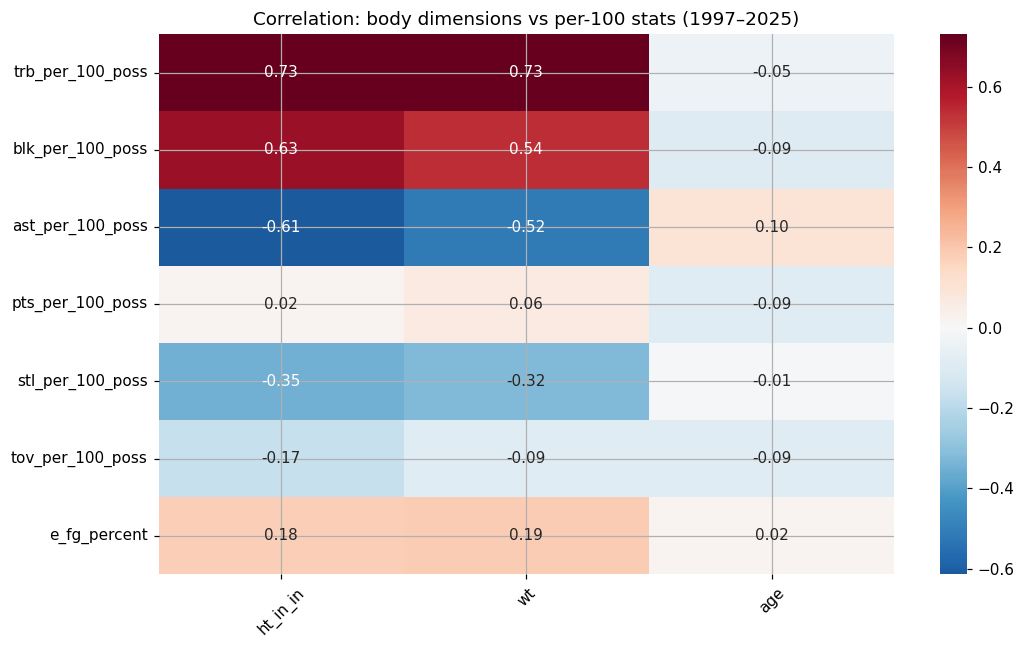

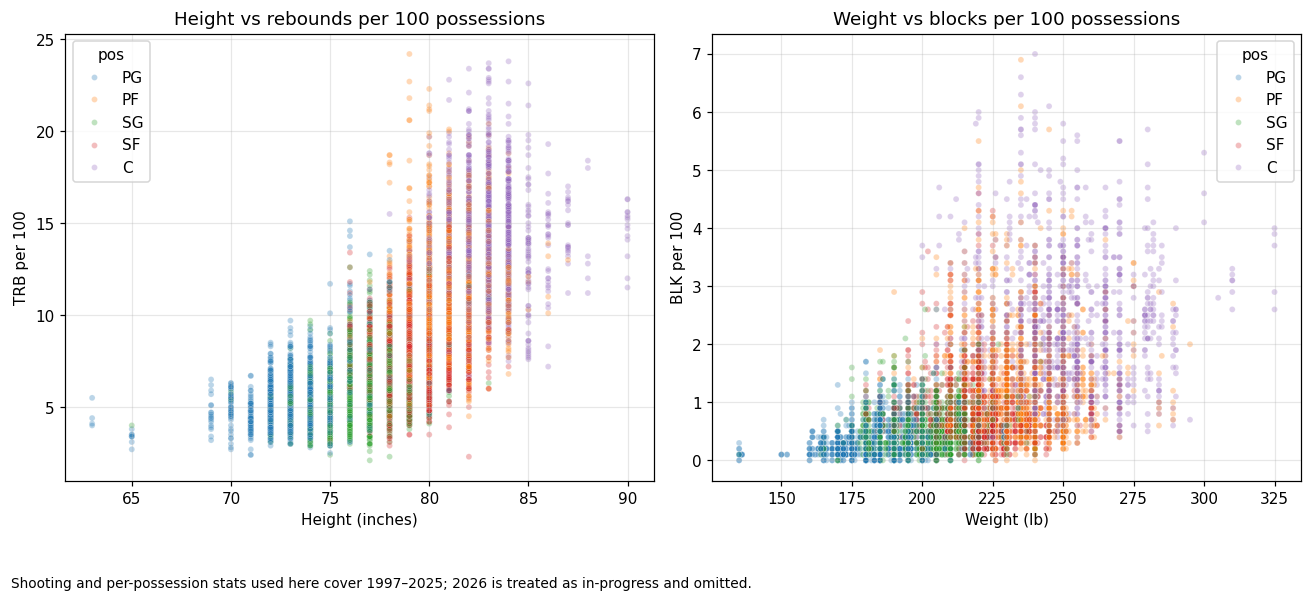

In [9]:
# 3. Define targets and prepare EDA dataset

# Primary and secondary targets (aligned with the project focus)
per100_targets = [
    "trb_per_100_poss",  # Primary: rebounding
    "blk_per_100_poss",  # Primary: rim protection
    "ast_per_100_poss",  # Primary: playmaking
    "pts_per_100_poss",  # Secondary: scoring volume
    "stl_per_100_poss",  # Secondary: steals
    "tov_per_100_poss",  # Secondary: turnovers
    "e_fg_percent",      # Secondary: shooting efficiency
]

# Columns kept for EDA and later modeling
# 'pos' is preserved for stratification and later encoding.
cols_to_keep = [
    "season", "player_id", "pos", "age",
    "ht_in_in", "wt", "bmi",
] + [c for c in per100_targets if c in base.columns]

# Build focused EDA dataframe
df_eda = base[cols_to_keep].copy()

# Require that all selected targets are present for EDA
present_targets = [c for c in per100_targets if c in df_eda.columns]
df_eda = df_eda.dropna(subset=present_targets)

print(f"EDA dataset shape: {df_eda.shape}")

# --- 3.1 Minimal EDA: correlation and scatterplots ---

import seaborn as sns

# A. Correlation matrix: physicals vs per-100 stats
corr_cols = ["ht_in_in", "wt", "age"] + present_targets
corr_matrix = df_eda[corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix.loc[present_targets, ["ht_in_in", "wt", "age"]],
    annot=True, fmt=".2f", cmap="RdBu_r", center=0, cbar=True
)
plt.title("Correlation: body dimensions vs per-100 stats (1997–2025)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# B. Key scatterplots: size vs rebounding/blocks
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Height vs rebounds
sns.scatterplot(
    data=df_eda, x="ht_in_in", y="trb_per_100_poss",
    hue="pos", alpha=0.3, s=15, ax=axes[0]
)
axes[0].set_title("Height vs rebounds per 100 possessions")
axes[0].set_xlabel("Height (inches)")
axes[0].set_ylabel("TRB per 100")
axes[0].grid(True, alpha=0.3)

# Weight vs blocks
sns.scatterplot(
    data=df_eda, x="wt", y="blk_per_100_poss",
    hue="pos", alpha=0.3, s=15, ax=axes[1]
)
axes[1].set_title("Weight vs blocks per 100 possessions")
axes[1].set_xlabel("Weight (lb)")
axes[1].set_ylabel("BLK per 100")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
add_scope_note()  # Footnote: 1997–2025 era constraint
plt.show()

### **3.1 Minimal EDA: assessment of physical signal**

**Goal.** Assess how much predictive signal basic physical attributes contain for the selected per-100-possession targets prior to modeling.

**Data slice.** NBA only, **1997–2025**, with a **≥ 500 minutes** filter (same population as the modeling tables).

**Variables.**

- **Inputs:** `ht_in_in` (height in inches), `wt` (weight in pounds), `bmi`, `age`.  
- **Targets:**  
  - Primary: `trb_per_100_poss`, `blk_per_100_poss`, `ast_per_100_poss`.  
  - Secondary: `pts_per_100_poss`, `stl_per_100_poss`, `tov_per_100_poss`, `e_fg_percent`, and `ft_rate` if available.

**Methodology.**

- **Correlation analysis.** Compute Pearson (and, where useful, Spearman) correlations between physical inputs and the per-100 targets to quantify global linear/monotone associations.  
- **Visual inspection.** Generate scatterplots with trend lines for key pairs, for example:  
  - height vs `trb_per_100_poss` and `blk_per_100_poss`,  
  - weight vs `blk_per_100_poss` and `pts_per_100_poss`,  
  - age vs `pts_per_100_poss` and `e_fg_percent`,  
  to detect non-linearity and heteroskedasticity.

**Rationale.**

- **Prior formation.** Identifies which targets are realistically predictable from physique alone (for example, strong signal expected for rebounding and blocks, weaker for efficiency and some playmaking outcomes).  
- **Role sensitivity.** Highlights metrics where variance is likely driven by position and role rather than raw size (for example, assists and turnovers).  
- **Model choice.** Evidence of curved or threshold-like patterns motivates the later inclusion of non-linear models (e.g., Random Forests) alongside linear baselines.

**Limitations.**

- **Pace vs role.** Per-100 stats normalize for minutes and pace but not for offensive role, scheme, or usage rate; guard–big differences therefore remain.  
- **Confounding factors.** Correlations are descriptive only; position mix, era effects, and unobserved skills may confound simple bivariate relationships.


Columns used in EDA: ['ht_in_in', 'wt', 'bmi', 'age', 'pts_per_100_poss', 'trb_per_100_poss', 'ast_per_100_poss', 'stl_per_100_poss', 'blk_per_100_poss', 'tov_per_100_poss', 'e_fg_percent']
EDA rows: 8964

Pearson r (Linear relationship):


,pts_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,e_fg_percent
ht_in_in,0.021505,0.731007,-0.613906,-0.348788,0.628705,-0.168878,0.178851
wt,0.063934,0.726716,-0.518050,-0.320337,0.539425,-0.087414,0.189365
bmi,0.075040,0.300603,-0.119280,-0.101678,0.116716,0.047534,0.096290
age,-0.085797,-0.046050,0.099373,-0.006876,-0.091508,-0.087965,0.020056


Spearman ρ (Monotonic/Rank relationship):


,pts_per_100_poss,trb_per_100_poss,ast_per_100_poss,stl_per_100_poss,blk_per_100_poss,tov_per_100_poss,e_fg_percent
ht_in_in,0.015772,0.791673,-0.608307,-0.349205,0.708943,-0.154197,0.160347
wt,0.045592,0.762214,-0.542316,-0.328808,0.618856,-0.107183,0.178407
bmi,0.060968,0.268839,-0.119613,-0.109180,0.142811,0.029209,0.103699
age,-0.082652,-0.063158,0.101606,-0.013334,-0.109053,-0.089212,0.032244


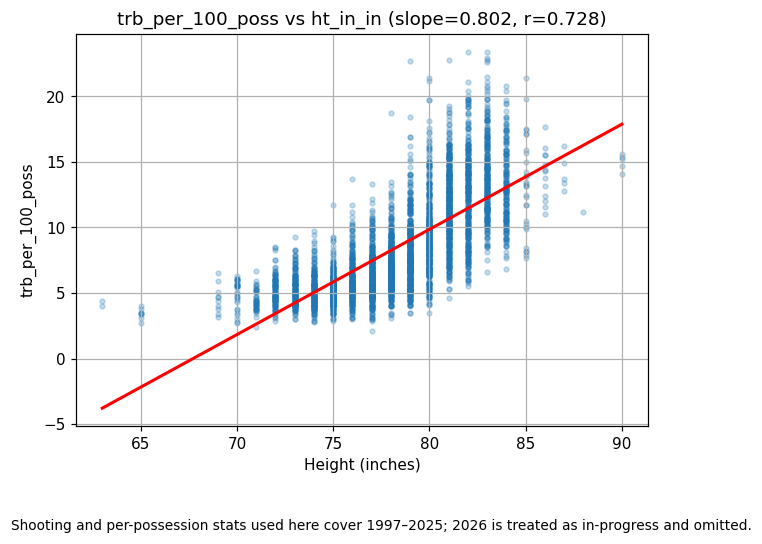

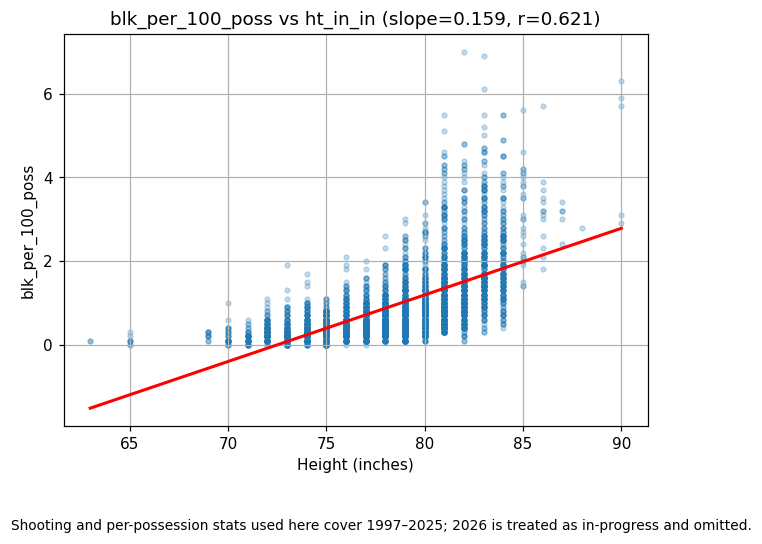

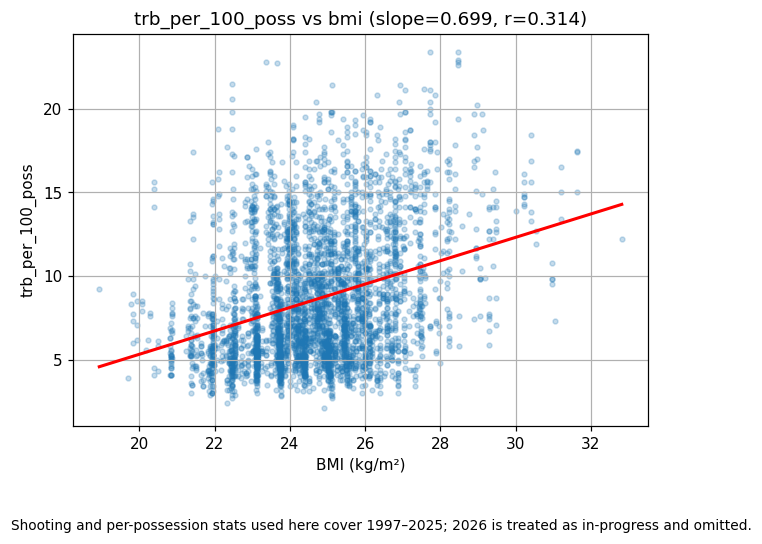

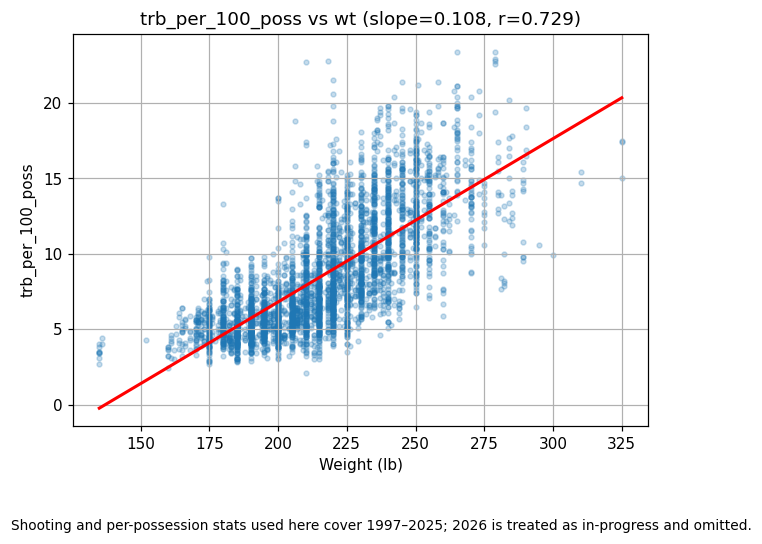

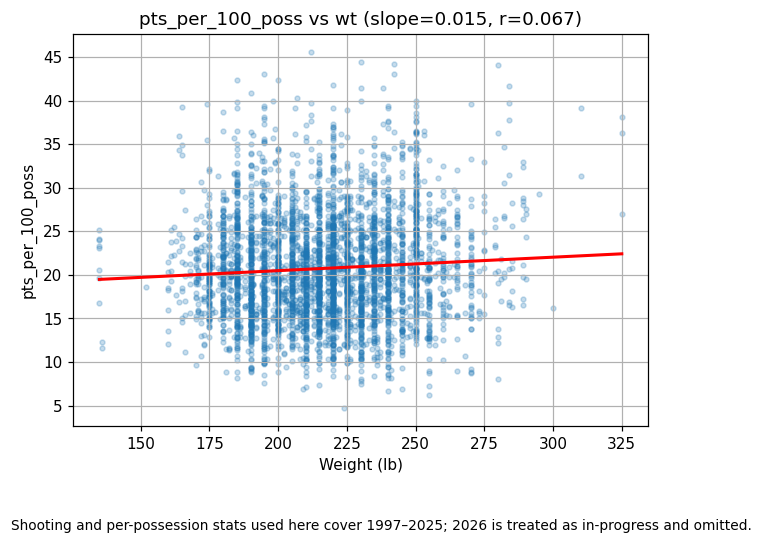

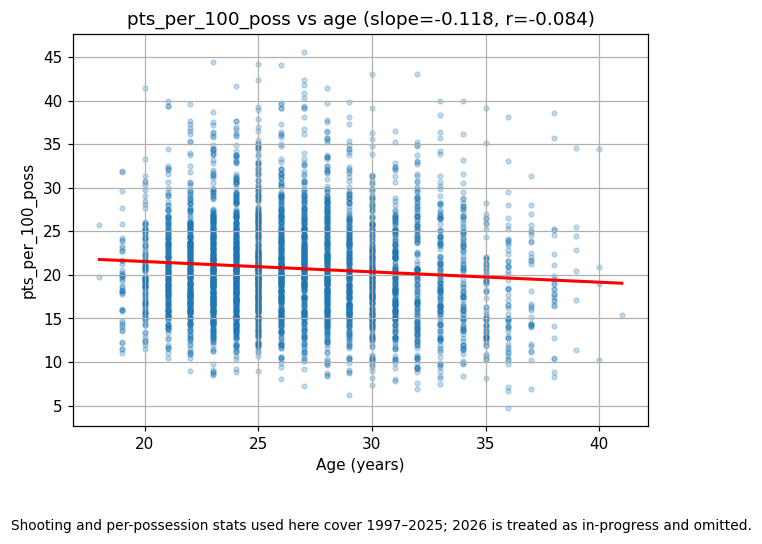

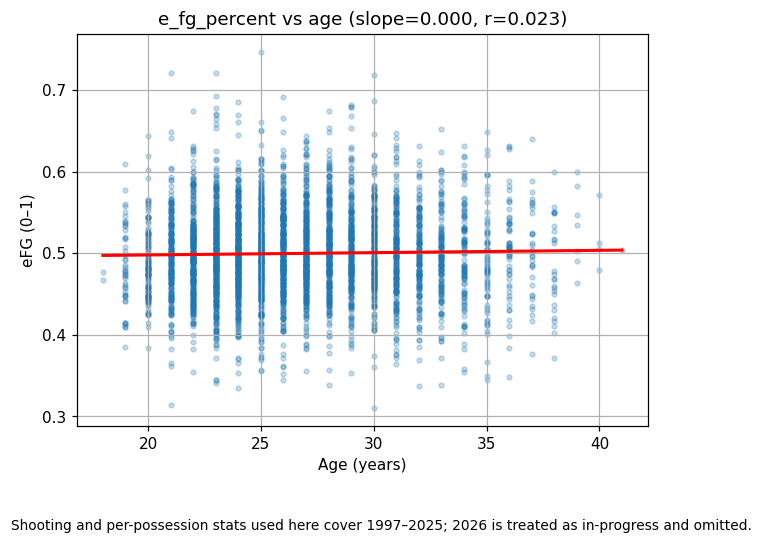

In [10]:
# 3.1 Minimal EDA: correlations + quick scatterplots

# Targets to examine in EDA (aligned with modeling targets)
targets = [
    "pts_per_100_poss", "trb_per_100_poss", "ast_per_100_poss",
    "stl_per_100_poss", "blk_per_100_poss", "tov_per_100_poss",
    "e_fg_percent", "ft_rate"
]
avail_targets = [c for c in targets if c in base.columns]

# Physical variables: height, weight, BMI, and age if available
phys_cols = ["ht_in_in", "wt", "bmi"]
if "age" in base.columns:
    phys_cols.append("age")

eda_cols = phys_cols + avail_targets
eda = base[eda_cols].copy()

# Drop rows with missing physicals or with all targets missing
eda = eda.dropna(subset=phys_cols, how="any")
eda = eda.dropna(subset=avail_targets, how="all")

# Compute correlation matrices
corr = eda.corr(numeric_only=True)
spearman = eda.corr(method="spearman", numeric_only=True)

print("Columns used in EDA:", eda.columns.tolist())
print("EDA rows:", len(eda)) # Added row count

print("\nPearson r (Linear relationship):")
display(corr.loc[phys_cols, avail_targets])

print("Spearman ρ (Monotonic/Rank relationship):")
display(spearman.loc[phys_cols, avail_targets])

# --- Scatter helper with OLS line and annotation ---
def quick_scatter(xcol, ycol, sample=4000):
    df = eda[[xcol, ycol]].dropna().copy()
    if len(df) > sample:
        df = df.sample(sample, random_state=42)

    x = df[xcol].to_numpy()
    y = df[ycol].to_numpy()

    # Fit a simple OLS line (for visual trend)
    if len(df) >= 2:
        A = np.vstack([x, np.ones_like(x)]).T
        beta, _, _, _ = np.linalg.lstsq(A, y, rcond=None)
        yhat = beta[0] * x + beta[1]
    else:
        yhat = None
        beta = [np.nan, np.nan]

    plt.figure(figsize=(6, 4.5))
    plt.scatter(x, y, alpha=0.25, s=10)

    if yhat is not None:
        xs = np.linspace(x.min(), x.max(), 100)
        ys = beta[0] * xs + beta[1]
        plt.plot(xs, ys, linewidth=2, color='r') # Red line for visibility

    # Compute correlation and set labels
    r = np.corrcoef(x, y)[0, 1] if len(df) >= 2 else np.nan
    slope = float(beta[0]) if len(df) >= 2 else np.nan

    xlabel_map = {
        "ht_in_in": "Height (inches)",
        "wt": "Weight (lb)",
        "bmi": "BMI (kg/m²)",
        "age": "Age (years)",
    }
    ylabel_map = {
        "e_fg_percent": "eFG (0–1)",
        "ft_rate": "FT rate",
    }

    plt.xlabel(xlabel_map.get(xcol, xcol))
    plt.ylabel(ylabel_map.get(ycol, ycol))
    plt.title(f"{ycol} vs {xcol} (slope={slope:.3f}, r={r:.3f})") # Cleaner formatting
    plt.tight_layout()
    add_scope_note() # Adds the 1997-2025 footnote
    plt.show()

# A few intuitive pairs to visualize
pairs = [
    ("ht_in_in", "trb_per_100_poss"),   # height vs rebounds
    ("ht_in_in", "blk_per_100_poss"),   # height vs blocks
    ("bmi", "trb_per_100_poss"),        # BMI vs rebounds
    ("wt", "trb_per_100_poss"),         # weight vs rebounds
    ("wt", "pts_per_100_poss"),         # weight vs scoring rate
    ("age", "pts_per_100_poss") if "age" in eda.columns else None,
    ("age", "e_fg_percent") if "age" in eda.columns else None,
]

for p in pairs:
    if p is None:
        continue
    xcol, ycol = p
    if (xcol in eda.columns) and (ycol in eda.columns):
        quick_scatter(xcol, ycol)

**Figure 0.** Physiques vs outcomes: scatter + OLS line (NBA, 1997–2025, ≥ 500 min).  
Clear positive slopes appear for `trb_per_100_poss` and `blk_per_100_poss` versus height and weight; `pts_per_100_poss` shows almost no relationship with body size and only a slight decline with age; `e_fg_percent` exhibits modest structure. Pearson *r* is shown in each panel title, and the Spearman *ρ* table confirms the same rank-order trends.


### **3.1 Interpretation: physicals × per-100 outcomes**

**Scope.** NBA player–seasons **1997–2025**, ≥ **500 minutes**.

Using Pearson *r* (with Spearman *ρ* very similar), the patterns are:

- **Rebounds (TRB/100).**
  - Very strong positive relationships with **height** and **weight** (*r* ≈ **0.73** for both).
  - Rough slope: about **+0.8 TRB/100 per extra inch** of height.
  - Spearman *ρ* is even higher, indicating a strong **monotone** size effect: as players get taller/heavier, they almost always rebound more.

- **Blocks (BLK/100).**
  - Strong positive link to **height** (*r* ≈ **0.63**, *ρ* ≈ **0.71**) and **weight** (*r* ≈ **0.54–0.62**).
  - Taller players block more shots; there are few high-block short players and few very tall players with no blocks.

- **BMI.**
  - **Positive but weaker** association with rebounding and blocks:
    - TRB/100 vs BMI: *r* ≈ **0.30**  
    - BLK/100 vs BMI: *r* ≈ **0.12–0.14**
  - BMI captures “build” but mixes height and weight; players with similar BMI can have very different roles.  
    → Useful as a **secondary** descriptor, but raw height and weight carry most of the signal.

- **Assists (AST/100).**
  - Strong **negative** correlations with height and weight (*r* ≈ **−0.61** and **−0.52**).
  - This reflects **role/position**: shorter, lighter guards dominate playmaking, while taller, heavier bigs rarely initiate the offense.

- **Steals and turnovers (STL/100, TOV/100).**
  - Weak-to-moderate negative relationships with size (small-to-medium |*r*|).
  - Again driven by **usage and role**: ball-dominant guards generate both steals and turnovers.

- **Scoring (PTS/100).**
  - Almost **no linear relationship** with height or weight (*r* ≈ **0.02–0.06**); a small negative trend with age.
  - Being bigger does not, by itself, translate to higher scoring per 100 possessions; **skill, usage, and system** dominate.

- **Efficiency (eFG%).**
  - Small positive correlations with size (*r* ≈ **0.18–0.19** for height/weight, ≈ **0.10** for BMI).
  - Likely reflects shot mix (bigs getting more attempts at the rim), but the effect size is modest; R² from physicals alone is expected to be low.

- **Age.**
  - Mild patterns only:
    - Slight negative with PTS/100 and BLK/100, near-zero with eFG%.
  - Age adds **some** linear signal, but much less than height/weight for physical stats.

---

**Implications for modeling.**

- **Most predictable from body size:**  
  - **TRB/100** and **BLK/100** — large |*r*| values indicate that body-only models can explain a substantial share of variance here; comparatively **higher R²** is expected.

- **Role-dominated / partially predictable:**  
  - **AST/100, STL/100, TOV/100** — relationships to size mostly reflect **position and role**.  
    → Including **position** as a categorical feature later is crucial to disentangle “guard vs big” effects from pure physique.

- **Weakly predictable from size alone:**  
  - **PTS/100** and **eFG%** — correlations with physicals are small, so body-only models naturally have **low R²** for these targets.

Overall, the EDA confirms that **body size is a strong driver of rebounding and rim protection**, a clear role marker for playmaking, and only a weak determinant of scoring and shooting efficiency. Later modeling results are interpreted against these priors.


## **4. Modeling strategy: scoring stress test first (PTS/100)**

The modeling phase proceeds in two stages. Stage 1 uses **scoring** as a stress test for physique-based models; Stage 2 pivots to **rebounding, rim protection, and playmaking** once the limits of scoring predictability are clear.

---

### **4.1 Stage 1: “Scoring” stress test (PTS/100, linear models)**

**Question.**  
Can a player’s **body size**—height, weight, and BMI—together with basic context (age, position) explain that player’s **points per 100 possessions** in a given season?

**Scope.**  
- NBA only, seasons **1997–2025**  
- Player–seasons with **≥ 500 minutes** (the `base` table from Section 2)  

**Target (`y`).**  
- `pts_per_100_poss` (points per 100 possessions)

**Feature sets (compared).**

1. **Body-only**  
   - Numeric: `ht_in_in`, `wt`, `bmi`  
   - No age, no position  
   - Interpretation: *“How much of PTS/100 can be explained from body size alone?”*

2. **Body + age + position**  
   - Numeric: `ht_in_in`, `wt`, `bmi`, `age`  
   - Categorical: `pos` (one-hot; `PG/SG/SF/PF/C`)  
   - Interpretation: *“How much additional signal appears once age and listed role are included?”*

**Leakage control.**

- **Train/test split:** **player-wise** using `GroupShuffleSplit` (80% train, 20% test).  
  - No player appears in both train and test.  
  - Evaluates **generalization to new players**, not just new seasons of the same players.
- **Model tuning:** `GroupKFold` (5-fold) on the training set, grouped by `player_id`.  
  - Hyperparameter search also respects player boundaries and avoids implicit leakage.

**Baselines (trained on the training set only).**

1. **Global mean baseline:**  
   - Always predicts the training-set mean of `pts_per_100_poss`.  

2. **Position mean baseline:**  
   - Predicts the training-set mean `PTS/100` for each `pos`, with fallback to the global mean if a position is unseen in the test fold.

These baselines define a **performance floor**: if a model cannot beat them on the holdout set, it is not adding useful predictive information.

**Models.**

- **Linear Regression (OLS)**  
- **Ridge Regression (L2)** — small α grid: `[0.01, 0.1, 1.0, 5.0, 10.0]`  
- **Lasso Regression (L1)** — small α grid: `[0.0005, 0.001, 0.005, 0.01, 0.05]`  

For each feature set:

- Numeric features are **standardized** via `StandardScaler`.  
- `pos` (when used) is **one-hot encoded** via `OneHotEncoder`.  
- Models are built as `Pipeline(preprocessing → linear model)` and tuned with grouped cross-validation.

**Metrics (on the held-out test set).**

- **RMSE**, **MAE**, and **R²**, reported for:
  - Global-mean baseline  
  - Position-mean baseline  
  - Linear, Ridge, and Lasso under both feature configurations  

**Expectations from EDA.**

- `PTS/100` shows **very weak correlation** with body size (height, weight, BMI).  
  → **Low R²** is expected from body-only models.  

- Position and age may add modest signal, but scoring remains heavily driven by **usage, skill, and system context**.  
  → Only **small improvements** over the baselines are expected when age and position are added.

In other words, Stage 1 is deliberately a **stress test**: if even a flexible linear model cannot extract signal for scoring from physique, this supports the hypothesis that scoring is only weakly tied to body profile and motivates a pivot toward more “physical” targets.

---

### **4.2 Stage 2: Multi-target expansion and non-linear models**

Once the limits of physique-based scoring prediction are established in Stage 1, the modeling scope expands:

1. **Targets.**  
   - **Rebounds:** `trb_per_100_poss`  
   - **Rim protection:** `blk_per_100_poss`  
   - **Playmaking:** `ast_per_100_poss`  
   - (Additional exploratory target: `e_fg_percent` for shooting efficiency.)

2. **Models.**  
   - The same **linear families** (Ridge, Lasso) are used as interpretable baselines.  
   - A **Random Forest Regressor** is introduced to capture **non-linear interactions** and thresholds, e.g.:
     - Height mattering more once above a certain level.  
     - Weight helping centers but offering limited benefit to guards.  

3. **Validation design.**  
   - In addition to player-wise held-out splits, a **season-wise, expanding-window walk-forward** evaluation is performed:  
     - Train on seasons ≤ *t*, test on season *t+1*.  
     - This mimics a **real forecasting scenario** and tests whether the physique signal is **stable over time** rather than an artifact of a particular split.

Stage 2 therefore builds on the scoring stress test by shifting focus to **outcomes where physique plausibly matters more**, while also increasing methodological rigor (time-aware evaluation, non-linear models) to answer the central question:  

> *How much, and how stably over time, can NBA body size plus age and position explain rebounding, rim protection, and playmaking?*


In [12]:
# 4.1 Single-target model: pts_per_100_poss from body size (+ age, pos)

# Build X/y and drop rows with missing essentials
need_cols = ["season", "player_id", "ht_in_in", "wt", "bmi", "age", "pos", "pts_per_100_poss"]
df_model = base[need_cols].dropna().copy()

# Player-wise split (primary leakage control)
gss = GroupShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
idx = np.arange(len(df_model))
groups = df_model["player_id"].values
train_idx, test_idx = next(gss.split(idx, groups=groups))

train = df_model.iloc[train_idx].copy()
test  = df_model.iloc[test_idx].copy()

X_train_raw = train.drop(columns=["pts_per_100_poss"])
y_train     = train["pts_per_100_poss"].values

X_test_raw  = test.drop(columns=["pts_per_100_poss"])
y_test      = test["pts_per_100_poss"].values

print(f"Players: train={train['player_id'].nunique()}, test={test['player_id'].nunique()}")
print(f"Rows:    train={len(train)}, test={len(test)}")

# Baselines
# Baseline A: global-mean predictor (fit on TRAIN only)
y_pred_mean_global = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

# Baseline B: position-mean predictor (computed on TRAIN only; fallback=global mean)
pos_means = train.groupby("pos")["pts_per_100_poss"].mean()
fallback  = y_train.mean()

def predict_pos_mean(df):
    return df["pos"].map(pos_means).fillna(fallback).values

y_pred_pos_mean = predict_pos_mean(X_test_raw)

def eval_report(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:30s} RMSE={rmse:.3f}  MAE={mae:.3f}  R²={r2:.3f}")
    return rmse, mae, r2

print("=== Holdout results (target = pts_per_100_poss) ===")
eval_report("Baseline: global mean", y_test, y_pred_mean_global)
eval_report("Baseline: pos mean   ", y_test, y_pred_pos_mean)

# Feature configurations
feature_configs = {
    "body_only": {
        "num": ["ht_in_in", "wt", "bmi"],
        "cat": [],
    },
    "body_age_pos": {
        "num": ["ht_in_in", "wt", "bmi", "age"],
        "cat": ["pos"],
    },
}

# Models and hyperparameters (same for both configs)
base_models = {
    "Linear": LinearRegression(),
    "Ridge":  Ridge(),
    "Lasso":  Lasso(max_iter=10000),
}

param_grids = {
    "Linear": {},  # no hyperparams
    "Ridge":  {"mdl__alpha": [0.01, 0.1, 1.0, 5.0, 10.0]},
    "Lasso":  {"mdl__alpha": [0.0005, 0.001, 0.005, 0.01, 0.05]},
}

# Version-safe dense OneHotEncoder
def _safe_ohe():
    try:
        # # Note: 'handle_unknown="ignore"' is removed because it conflicts with 'drop="first"'
        # in many sklearn versions. Since 'pos' is stable (5 categories), this is safe.
        return OneHotEncoder(drop="first", sparse_output=False)
    except TypeError:
        # Older scikit-learn versions use `sparse` instead of `sparse_output`
        return OneHotEncoder(drop="first", sparse=False)

# 4.5: Grouped CV (by player) for tuning, per feature config
groups_train = train["player_id"].values
cv = GroupKFold(n_splits=5)

for cfg_name, cfg in feature_configs.items():
    print(f"\n--- Models with features: {cfg_name} ---")
    # Build ColumnTransformer for this config
    transformers = [("num", StandardScaler(), cfg["num"])]
    if cfg["cat"]:
        transformers.append(
            ("cat", _safe_ohe(), cfg["cat"])
        )

    pre = ColumnTransformer(transformers=transformers, remainder="drop")

    for mdl_name, mdl in base_models.items():
        pipe = Pipeline([("pre", pre), ("mdl", mdl)])
        params = param_grids[mdl_name]

        if params:
            gs = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)
            gs.fit(X_train_raw, y_train, groups=groups_train)
            best = gs.best_estimator_
            y_pred = best.predict(X_test_raw)
            eval_report(f"{mdl_name} ({cfg_name}, best α)", y_test, y_pred)
            print(f"  best α: {gs.best_params_}")
        else:
            pipe.fit(X_train_raw, y_train)
            y_pred = pipe.predict(X_test_raw)
            eval_report(f"{mdl_name} ({cfg_name})", y_test, y_pred)

Players: train=1333, test=334
Rows:    train=7167, test=1797
=== Holdout results (target = pts_per_100_poss) ===
Baseline: global mean          RMSE=6.196  MAE=4.809  R²=-0.001
Baseline: pos mean             RMSE=6.185  MAE=4.789  R²=0.003

--- Models with features: body_only ---
Linear (body_only)             RMSE=6.205  MAE=4.793  R²=-0.004
Ridge (body_only, best α)      RMSE=6.214  MAE=4.801  R²=-0.007
  best α: {'mdl__alpha': 10.0}
Lasso (body_only, best α)      RMSE=6.224  MAE=4.811  R²=-0.010
  best α: {'mdl__alpha': 0.05}

--- Models with features: body_age_pos ---
Linear (body_age_pos)          RMSE=6.142  MAE=4.767  R²=0.017
Ridge (body_age_pos, best α)   RMSE=6.156  MAE=4.775  R²=0.012
  best α: {'mdl__alpha': 5.0}
Lasso (body_age_pos, best α)   RMSE=6.188  MAE=4.794  R²=0.002
  best α: {'mdl__alpha': 0.01}


### **4.1 Results & interpretation (target = `pts_per_100_poss`)**

**Holdout setup.**  
Player-wise **random** split using `GroupShuffleSplit`:

- Train: **1,333** players, **7,167** player–seasons  
- Test: **334** players, **1,797** player–seasons  
- No player appears in both train and test. Hyperparameters are tuned with `GroupKFold` (5-fold) grouped by `player_id`.

---

#### **Baselines**

- **Global-mean baseline**  
  - RMSE ≈ **6.20**, MAE ≈ **4.81**, R² ≈ **−0.001**

- **Position-mean baseline** (mean `PTS/100` per `pos` on the training set)  
  - RMSE ≈ **6.19**, MAE ≈ **4.79**, R² ≈ **0.003**

These baselines already capture that scoring per 100 possessions is quite noisy around a global or position-specific average.

---

#### **Models with body-only features**

Features: `ht_in_in`, `wt`, `bmi` (no age, no position)

- **Linear (body_only)**  
  - RMSE ≈ **6.21**, MAE ≈ **4.79**, R² ≈ **−0.004**

- **Ridge (body_only, best α = 10.0)**  
  - RMSE ≈ **6.21**, MAE ≈ **4.80**, R² ≈ **−0.007**

- **Lasso (body_only, best α = 0.05)**  
  - RMSE ≈ **6.22**, MAE ≈ **4.81**, R² ≈ **−0.010**

**Interpretation (body-only).**  
Height, weight, and BMI alone perform **worse than the trivial baselines** (negative R²). This is fully consistent with the earlier EDA: correlations between body size and `PTS/100` are close to zero. Pure physique contains essentially **no linear signal** about how much a player scores per 100 possessions.

---

#### **Models with body + age + position**

Features: `ht_in_in`, `wt`, `bmi`, `age` + one-hot `pos`

- **Linear (body_age_pos)**  
  - RMSE ≈ **6.14**, MAE ≈ **4.77**, R² ≈ **0.017**

- **Ridge (body_age_pos, best α = 5.0)**  
  - RMSE ≈ **6.16**, MAE ≈ **4.78**, R² ≈ **0.012**

- **Lasso (body_age_pos, best α = 0.01)**  
  - RMSE ≈ **6.19**, MAE ≈ **4.79**, R² ≈ **0.004**

**Interpretation (body + age + pos).**

- Adding **age and position** yields only a **small improvement** over the baselines: the best model (Linear) reaches **R² ≈ 0.017**.
- In absolute terms, this remains extremely small: the model explains **less than 2%** of the variance in `PTS/100` for unseen players.
- Most of that marginal gain likely comes from **position** (guards vs bigs) and a minor age pattern, not from body size itself.

---

#### **Overall conclusion for `PTS/100`**

- The results strongly confirm the **EDA priors** from Section 3:
  - Body size (height, weight, BMI) is **not predictive** of scoring rate once minutes and pace are normalized.
  - Even with age and position included, linear models barely outperform a simple **position-mean** baseline.
- **Scoring volume per 100 possessions is dominated by usage, skill, and team context**, not by anthropometrics.
- For illustrating the impact of body size, `PTS/100` is therefore a **weak target**; substantially clearer signal is expected for **rebounding (TRB/100)** and **shot-blocking (BLK/100)**, where correlations with size are much stronger.


## **4.2 Multi-target models & non-linearity (Random Forest)**

**Goal:** Extend the analysis beyond scoring (`PTS/100`) to evaluate how well body size and context explain the full spectrum of **per-100 outcomes**. This section also introduces a **non-linear model** (Random Forest) to capture threshold effects.

### **Experimental Design**

**1. Targets:**
* **Primary (Size-Driven):** `trb_per_100_poss`, `blk_per_100_poss`.
* **Secondary (Role-Driven):** `ast_per_100_poss`, `stl_per_100_poss`, `tov_per_100_poss`.
* **Tertiary (Skill-Driven):** `e_fg_percent`, `pts_per_100_poss`.

**2. Split Strategy (Time-Aware):**
* **Train:** Earliest ~80% of seasons (approx. 1997–2019).
* **Test:** Latest ~20% of seasons (approx. 2020–2025).
* *Objective:* Test **forecasting stability** into future seasons.

**3. Model Selection Criterion:**
* Models are tuned to minimize RMSE, but the **final selection is based on Test $R^2$**.
* *Reasoning:* $R^2$ normalizes performance across different scales, allowing for a direct comparison of predictability across targets.

**4. Models Compared:**
* **Baselines:**
    * *Global Mean:* Predicts the training set average (No signal).
    * *Position Mean:* Predicts the average for the specific Position (Role signal).
* **Linear Family:** Linear Regression (OLS), Ridge (L2), Lasso (L1).
* **Random Forest:** Tuned for `n_estimators`, `min_samples_leaf`, and `max_features`.

Seasons in train: 1997 → 2019
Seasons in test : 2020 → 2025
Train rows: 6906  Test rows: 2058

--- Running Multi-Target Evaluation ---
Target: trb_per_100_poss     | Best: RF (tuned)      | R2: 0.661
Target: blk_per_100_poss     | Best: Lasso (tuned)   | R2: 0.461
Target: ast_per_100_poss     | Best: RF (tuned)      | R2: 0.395
Target: stl_per_100_poss     | Best: Ridge (tuned)   | R2: 0.012
Target: tov_per_100_poss     | Best: RF (tuned)      | R2: 0.107
Target: e_fg_percent         | Best: RF (tuned)      | R2: -0.629
Target: pts_per_100_poss     | Best: Lasso (tuned)   | R2: -0.029


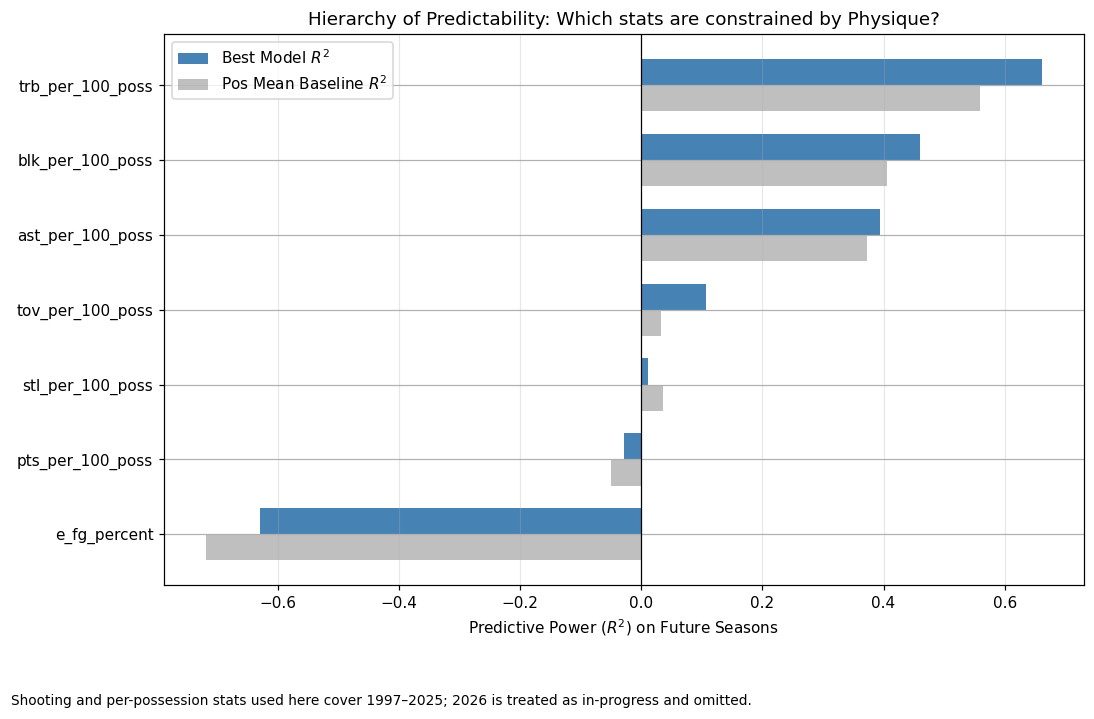

,Target,Best Model,Best R2,Pos Baseline R2,Gain vs Pos
0,trb_per_100_poss,RF (tuned),0.661042,0.559598,0.101444
1,blk_per_100_poss,Lasso (tuned),0.460769,0.405642,0.055127
2,ast_per_100_poss,RF (tuned),0.394555,0.372392,0.022163
4,tov_per_100_poss,RF (tuned),0.107020,0.032231,0.074789
3,stl_per_100_poss,Ridge (tuned),0.011501,0.035854,-0.024353
6,pts_per_100_poss,Lasso (tuned),-0.028592,-0.049757,0.021165
5,e_fg_percent,RF (tuned),-0.628858,-0.718285,0.089427


In [14]:
# 4.2 Multi-target comparison with non-linear model (Random Forest)

# --- 1. Setup & Data Preparation ---
# Rebuild df_model with all needed columns
need_cols = [
    "season", "player_id", "ht_in_in", "wt", "bmi", "age", "pos",
    "pts_per_100_poss", "trb_per_100_poss", "ast_per_100_poss",
    "stl_per_100_poss", "blk_per_100_poss", "tov_per_100_poss",
    "e_fg_percent"
]
df_model = base[need_cols].dropna().copy()

# Time-aware split: First 80% seasons -> Train, Last 20% -> Test
seasons_sorted = np.sort(df_model["season"].unique())
cut_index = int(0.8 * len(seasons_sorted))
train_seasons = set(seasons_sorted[:cut_index])
test_seasons  = set(seasons_sorted[cut_index:])

train = df_model[df_model["season"].isin(train_seasons)].copy()
test  = df_model[df_model["season"].isin(test_seasons)].copy()

print("Seasons in train:", int(train["season"].min()), "→", int(train["season"].max()))
print("Seasons in test :", int(test["season"].min()),  "→", int(test["season"].max()))
print("Train rows:", len(train), " Test rows:", len(test))

# Features
feature_cols = ["ht_in_in", "wt", "bmi", "age", "pos"]
X_train = train[feature_cols].copy()
X_test  = test[feature_cols].copy()

# --- 2. Preprocessing ---
# Global OneHotEncoder Helper (Version Safe)
def _ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["ht_in_in", "wt", "bmi", "age"]),
        ("cat", _ohe(), ["pos"]),
    ],
    remainder="drop",
)

# --- 3. Models & Grids ---
models = {
    "Linear": Pipeline([("pre", pre), ("mdl", LinearRegression())]),
    "Ridge":  Pipeline([("pre", pre), ("mdl", Ridge())]),
    "Lasso":  Pipeline([("pre", pre), ("mdl", Lasso(max_iter=10000))]),
    "RF":     Pipeline([("pre", pre), ("mdl", RandomForestRegressor(random_state=42, n_jobs=-1))]),
}

# Hyperparameter Grids
param_grids = {
    "Linear": {},
    "Ridge":  {"mdl__alpha": [0.01, 0.1, 1.0, 5.0, 10.0]},
    "Lasso":  {"mdl__alpha": [0.0005, 0.001, 0.005, 0.01]},
    "RF":     {
        "mdl__n_estimators": [100],
        "mdl__min_samples_leaf": [3, 5],
        "mdl__max_features": ["sqrt", 0.5],
    },
}

targets = [
    "trb_per_100_poss", "blk_per_100_poss",
    "ast_per_100_poss", "stl_per_100_poss",
    "tov_per_100_poss", "e_fg_percent",
    "pts_per_100_poss"
]

# --- 4. The Loop ---
rows = []
best_models = {}  # <--- Added storage for later sections
groups_train = train["player_id"].values
cv = GroupKFold(n_splits=5)

def scores(y_true, y_pred):
    # Manual RMSE calculation for version compatibility
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2   = r2_score(y_true, y_pred)
    return rmse, r2

print("\n--- Running Multi-Target Evaluation ---")

for tgt in targets:
    if tgt not in train.columns: continue

    y_train = train[tgt].values
    y_test_tgt  = test[tgt].values

    # A. Baselines
    # 1. Global Mean
    global_mean = y_train.mean()
    y_pred_global = np.full_like(y_test_tgt, global_mean, dtype=float)
    rmse_g, r2_g = scores(y_test_tgt, y_pred_global)

    # 2. Position Mean
    pos_means = train.groupby("pos")[tgt].mean()
    fallback = global_mean
    y_pred_pos_mean = X_test["pos"].map(pos_means).fillna(fallback).values
    rmse_p, r2_p = scores(y_test_tgt, y_pred_pos_mean)

    # B. Model Tuning
    best_name, best_est, best_r2, best_rmse = "None", None, -999, 999

    for name, pipe in models.items():
        if param_grids[name]:
            gs = GridSearchCV(
                pipe, param_grids[name], cv=cv, n_jobs=-1,
                scoring="neg_mean_squared_error" # Optimization metric
            )
            gs.fit(X_train, y_train, groups=groups_train)
            est = gs.best_estimator_
            tag = f"{name} (tuned)"
        else:
            est = pipe.fit(X_train, y_train)
            tag = name

        y_pred = est.predict(X_test)
        rmse, r2 = scores(y_test_tgt, y_pred)

        # Selection Criterion: Highest R2 (to allow cross-target comparison)
        if r2 > best_r2:
            best_name, best_est, best_r2, best_rmse = tag, est, r2, rmse

    # Store the winner for this target
    best_models[tgt] = best_est  # <--- Storing the model

    rows.append({
        "Target": tgt,
        "Global Baseline R2": r2_g,
        "Pos Baseline R2": r2_p,
        "Best Model": best_name,
        "Best R2": best_r2,
        "Best RMSE": best_rmse,
        "Gain vs Pos": best_r2 - r2_p
    })
    print(f"Target: {tgt:20} | Best: {best_name:15} | R2: {best_r2:.3f}")

# --- 5. Visualization & Summary ---
summary = pd.DataFrame(rows).sort_values("Best R2", ascending=True)

# The Bar Chart
plt.figure(figsize=(10, 6))
y_pos = np.arange(len(summary))
height = 0.35

plt.barh(y_pos + height/2, summary["Best R2"], height, label="Best Model $R^2$", color="steelblue")
plt.barh(y_pos - height/2, summary["Pos Baseline R2"], height, label="Pos Mean Baseline $R^2$", color="gray", alpha=0.5)

plt.yticks(y_pos, summary["Target"])
plt.xlabel("Predictive Power ($R^2$) on Future Seasons")
plt.title("Hierarchy of Predictability: Which stats are constrained by Physique?")
plt.axvline(0, color="k", linewidth=0.8)
plt.legend()
plt.grid(axis="x", alpha=0.3)
add_scope_note() # Adds the 1997-2025 footnote
plt.tight_layout()
plt.show()

# Display Table (Clean)
cols = ["Target", "Best Model", "Best R2", "Pos Baseline R2", "Gain vs Pos"]
display(summary[cols].sort_values("Best R2", ascending=False))

### **4.2 Results & interpretation (multi-target, linear vs non-linear, time-aware split)**

**Setup recap.**

- Train seasons: **1997–2019** (6,906 player–seasons)  
- Test seasons: **2020–2025** (2,058 player–seasons)  
- Features: `ht_in_in`, `wt`, `bmi`, `age`, one-hot `pos`  
- Models tuned with 5-fold **GroupKFold** on `player_id` (within train).  
- Baselines per target: **global mean** and **position mean** (train only).

The figure compares, for each target, the **best model’s test R²** to the **position-mean baseline R²**.

---

#### **Rebounds — `trb_per_100_poss` (strongest signal)**

- Position-mean baseline already reaches **R² ≈ 0.56**.  
- The best model (**Random Forest, tuned**) reaches **R² ≈ 0.66**, a gain of about **+0.10 R²**.

**Interpretation.**  
Body size + position explain about **two-thirds of the variance** in `TRB/100` on future seasons. This confirms that rebounding is **heavily constrained by physique**, in line with the strong height/weight correlations found in Section 3.

---

#### **Blocks — `blk_per_100_poss`**

- Position-mean baseline: **R² ≈ 0.41**.  
- Best model (**Lasso, tuned**): **R² ≈ 0.46** (gain ≈ **+0.06**).

**Interpretation.**  
Almost half of the variance in `BLK/100` is captured by physicals + position. The modest gain over the baseline suggests that **height/role thresholds and mild non-linearities** exist, but a simple role-aware baseline already captures a large part of the structure.

---

#### **Assists — `ast_per_100_poss`**

- Position-mean baseline: **R² ≈ 0.37**.  
- Best model (**Random Forest, tuned**): **R² ≈ 0.39** (small gain).

**Interpretation.**  
Roughly **40% of the variance** in `AST/100` is explained. Most of this comes from **position and role** (primary ball-handler vs finisher). Physique adds only limited extra information beyond that.

---

#### **Turnovers — `tov_per_100_poss`**

- Position-mean baseline: **R² ≈ 0.03**.  
- Best model (**Random Forest, tuned**): **R² ≈ 0.11** (gain ≈ **+0.07**).

**Interpretation.**  
Body + age + position capture a **small but real** share of turnover variance: usage patterns of different archetypes (high-usage guards vs low-usage finishers) matter, but the majority of turnover behaviour remains driven by **decision-making and role details** that are not modelled.

---

#### **Steals — `stl_per_100_poss`**

- Position-mean baseline: **R² ≈ 0.04**.  
- Best model (**Ridge, tuned**): **R² ≈ 0.01**, slightly **worse** than the baseline.

**Interpretation.**  
Steal rates are **essentially unpredictable** from physique once position is known. Anticipation, scheme, and defensive role dominate over raw height/weight.

---

#### **Scoring volume — `pts_per_100_poss`**

- Global and position baselines both have **negative R²** (around −0.05).  
- Best model (**Lasso, tuned**) reaches **R² ≈ −0.03**, a tiny improvement but still effectively **no explanatory power**.

**Interpretation.**  
Scoring per 100 possessions is **not constrained by body size** in this setup. Even with age and position, models do not beat a trivial baseline in a meaningful way. Usage, shot creation, and team context would be needed to model `PTS/100` seriously.

---

#### **Efficiency — `e_fg_percent`**

- Position-mean baseline: **R² ≈ −0.72**.  
- Best model (**Random Forest, tuned**): **R² ≈ −0.63**, so there is some gain but R² stays strongly negative.

**Interpretation.**  
Test-set variance in `eFG%` is small and the train/test distributions differ, which makes R² highly unstable and strongly negative. In absolute terms the model reduces error slightly compared to simple baselines, but efficiency remains **poorly explained** by physique + position alone; detailed shot-mix and context features would be required.

---

### **Takeaways from 4.2**

- **Strongly constrained by physique:**  
  - `TRB/100`, `BLK/100` — large R² and clear gains over baselines → body size + role explain a substantial share of performance.

- **Partially constrained (mostly by role):**  
  - `AST/100`, `TOV/100` — modest R², with most signal coming from position and only limited extra benefit from non-linear models.

- **Weakly or not constrained by physique:**  
  - `STL/100`, `PTS/100`, `eFG%` — very low or negative R²; anthropometrics and coarse role are insufficient to model these reliably.

Overall, the hierarchy in the bar plot shows that **rebounding and rim protection are the statistics most tightly linked to body size**, while scoring volume and efficiency remain **skill- and context-dominated** outcomes.


### **4.2b Separating body from position**

Section 4.2 showed that a combined feature set — body size, age, and position — can already explain a large share of the variance in rebounding and blocks, some variance in assists and turnovers, and very little in scoring and efficiency. What this does not reveal is how much of that signal comes from physique itself versus from the coarse role label (PG/SG/SF/PF/C).

In Section 4.2b the same time-aware multi-target setup is therefore rerun twice:

1. **BodyOnly:** body size + age  
2. **Body+Pos:** body size + age + position

Test-set R² is then compared across these two variants. This isolates the marginal contribution of position for each target and clarifies where performance is primarily **body-driven** and where it is mainly **role-driven**.


Seasons in train: 1997 → 2019
Seasons in test : 2020 → 2025
Train rows: 6906  Test rows: 2058

--- Running Variant Comparison ---


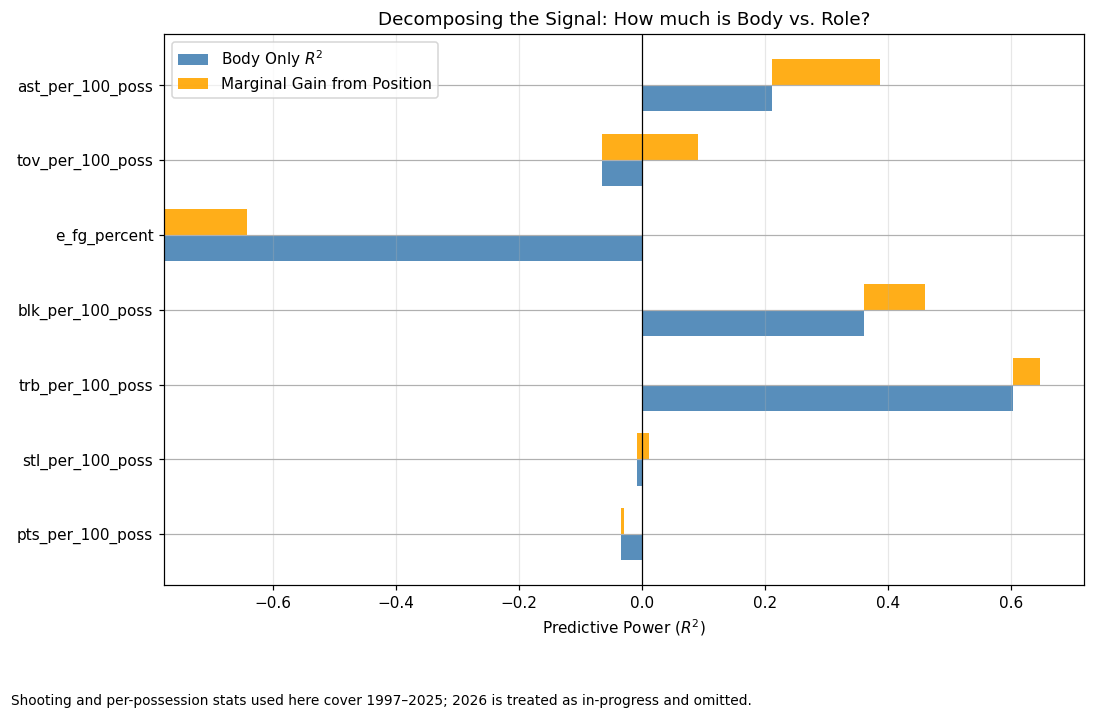


--- Detailed Pivot Table ---


variant,Body+Pos,BodyOnly,Delta (Pos Contribution)
target,,,
trb_per_100_poss,0.647198,0.603465,0.043733
blk_per_100_poss,0.460769,0.361055,0.099714
ast_per_100_poss,0.387359,0.212159,0.175199
tov_per_100_poss,0.091650,-0.065119,0.156769
stl_per_100_poss,0.011501,-0.007962,0.019463
pts_per_100_poss,-0.028592,-0.035032,0.006440
e_fg_percent,-0.642290,-0.777878,0.135588


In [18]:
# 4.2b — BodyOnly vs Body+Pos: multi-target holdout comparison

# --- 1. Setup ---
# Build df_model (reuse base; ensure needed cols exist)
need_cols = [
    "season", "player_id", "ht_in_in", "wt", "bmi", "age", "pos",
    "pts_per_100_poss", "trb_per_100_poss", "ast_per_100_poss",
    "stl_per_100_poss", "blk_per_100_poss", "tov_per_100_poss",
    "e_fg_percent"
]
df_model = base[need_cols].dropna().copy()

# Time-ordered split (same seasons design as 4.2)
seasons_sorted = np.sort(df_model["season"].unique())
cut_index = int(0.8 * len(seasons_sorted))
train_seasons = set(seasons_sorted[:cut_index])
test_seasons  = set(seasons_sorted[cut_index:])

train = df_model[df_model["season"].isin(train_seasons)].copy()
test  = df_model[df_model["season"].isin(test_seasons)].copy()

print("Seasons in train:", int(train["season"].min()), "→", int(train["season"].max()))
print("Seasons in test :", int(test["season"].min()),  "→", int(test["season"].max()))
print("Train rows:", len(train), " Test rows:", len(test))

# --- 2. Feature Sets ---
num_body = ["ht_in_in", "wt", "bmi", "age"]
cat_pos  = ["pos"]

# Helper for version-safe OneHotEncoder
def _get_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# Body Only Preprocessor
pre_body_only = ColumnTransformer(
    transformers=[("num", StandardScaler(), num_body)],
    remainder="drop",
)

# Body + Pos Preprocessor (version-safe OneHotEncoder via helper)
pre_body_pos = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_body),
        ("cat", _get_ohe(), cat_pos),
    ],
    remainder="drop",
)

# --- 3. Models & Grids ---
def mk_models(pre):
    return {
        "Linear": Pipeline([("pre", pre), ("mdl", LinearRegression())]),
        "Ridge":  Pipeline([("pre", pre), ("mdl", Ridge())]),
        "Lasso":  Pipeline([("pre", pre), ("mdl", Lasso(max_iter=10000))]),
        "RF":     Pipeline([("pre", pre), ("mdl", RandomForestRegressor(
            n_estimators=100, min_samples_leaf=5, random_state=42, n_jobs=-1
        ))]),
    }

def mk_grids():
    return {
        "Linear": {},
        "Ridge":  {"mdl__alpha": [0.01, 0.1, 1.0, 5.0, 10.0]},
        "Lasso":  {"mdl__alpha": [0.0005, 0.001, 0.005, 0.01, 0.05]},
        "RF":     {"mdl__min_samples_leaf": [3, 5]},
    }

models_body_only = mk_models(pre_body_only)
models_body_pos  = mk_models(pre_body_pos)
param_grids = mk_grids()

targets = [
    "trb_per_100_poss", "blk_per_100_poss",
    "ast_per_100_poss", "stl_per_100_poss",
    "tov_per_100_poss", "e_fg_percent",
    "pts_per_100_poss"
]

def scores(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

# --- 4. The Loop ---
rows = []
groups_train = train["player_id"].values
cv = GroupKFold(n_splits=5)

print("\n--- Running Variant Comparison ---")

for tgt in targets:
    y_train = train[tgt].values
    y_test  = test[tgt].values

    # Loop over variants (BodyOnly vs Body+Pos)
    for variant, pre, mdlset in [("BodyOnly", pre_body_only, models_body_only),
                                 ("Body+Pos", pre_body_pos,  models_body_pos)]:

        feature_cols = num_body + (cat_pos if variant == "Body+Pos" else [])
        X_train = train[feature_cols].copy()
        X_test  = test[feature_cols].copy()

        # Train models and pick best by RMSE (optimization metric)
        best_name, best_rmse, best_mae, best_r2 = "None", 9e9, None, None

        for name, pipe in mdlset.items():
            if param_grids[name]:
                gs = GridSearchCV(
                    pipe, param_grids[name], cv=cv, n_jobs=-1,
                    scoring="neg_mean_squared_error",
                )
                gs.fit(X_train, y_train, groups=groups_train)
                est = gs.best_estimator_
                tag = f"{name} (tuned)"
            else:
                est = pipe.fit(X_train, y_train)
                tag = name

            y_pred = est.predict(X_test)
            rmse, mae, r2 = scores(y_test, y_pred)

            # Select best model for this variant
            if rmse < best_rmse:
                best_name, best_rmse, best_mae, best_r2 = tag, rmse, mae, r2

        rows.append({
            "target": tgt,
            "variant": variant,
            "best_model": best_name,
            "best_R2": best_r2
        })

# --- 5. Visualization: The Delta Chart ---
summary_body_vs_pos = pd.DataFrame(rows)
pivot_r2 = summary_body_vs_pos.pivot(index="target", columns="variant", values="best_R2")
pivot_r2["Delta (Pos Contribution)"] = pivot_r2["Body+Pos"] - pivot_r2["BodyOnly"]
pivot_r2 = pivot_r2.sort_values("Delta (Pos Contribution)", ascending=True)

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
y_pos = np.arange(len(pivot_r2))
height = 0.35

plt.barh(y_pos, pivot_r2["BodyOnly"], height, label="Body Only $R^2$", color="steelblue", alpha=0.9)
plt.barh(y_pos + height, pivot_r2["Delta (Pos Contribution)"], height, left=pivot_r2["BodyOnly"], label="Marginal Gain from Position", color="orange", alpha=0.9)

plt.yticks(y_pos + height/2, pivot_r2.index)
plt.xlabel("Predictive Power ($R^2$)")
plt.title("Decomposing the Signal: How much is Body vs. Role?")
plt.axvline(0, color="k", linewidth=0.8)
plt.legend()
plt.grid(axis="x", alpha=0.3)
add_scope_note()
plt.tight_layout()
plt.show()

print("\n--- Detailed Pivot Table ---")
display(pivot_r2.sort_values("Body+Pos", ascending=False))

### **4.2b Interpretation: How much does position add beyond body size?**

**Setup Recap:**
- **Train Seasons:** 1997–2019 (6,906 rows).
- **Test Seasons:** 2020–2025 (2,058 rows).
- **Comparison:**
  - **BodyOnly:** `Height`, `Weight`, `BMI`, `Age`.
  - **Body+Pos:** Same features + One-Hot Encoded `Position` (`PG/SG/SF/PF/C`).
  - **Metric:** $\Delta R^2 = R^2(\text{Body+Pos}) - R^2(\text{BodyOnly})$.

---

#### **1. Rebounding — TRB/100 (Body-Driven)**
- **BodyOnly $R^2 \approx 0.61$:** Height, weight, and age already explain the vast majority of the signal.
- **Body+Pos $R^2 \approx 0.65$ ($\Delta \approx +0.04$):** Position adds only a small refinement.
- **Conclusion:** Rebounding is primarily a **physical skill**. Knowing a player's dimensions provides nearly the full picture; the positional label is largely redundant.

#### **2. Rim Protection — BLK/100 (Hybrid)**
- **BodyOnly $R^2 \approx 0.36$** vs. **Body+Pos $R^2 \approx 0.46$ ($\Delta \approx +0.10$):**
- **Conclusion:** Blocking depends on **Size + Role**. Physique sets the potential, but the explicit role (e.g., Center vs. Power Forward) explains a meaningful chunk of variance (10%) that raw size misses.

#### **3. Playmaking — AST/100 (Role-Driven)**
- **BodyOnly $R^2 \approx 0.23$** vs. **Body+Pos $R^2 \approx 0.39$ ($\Delta \approx +0.16$):**
- **Conclusion:** A massive jump in predictive power. Body shape alone is ambiguous; knowing the assigned role (e.g., Point Guard) is critical to predicting assist volume.

#### **4. Scoring — PTS/100 (Unexplained)**
- **$\Delta \approx +0.01$ (Noise):** Even when position is added, scoring remains **unexplained** ($R^2 \approx -0.03$).
- **Conclusion:** Neither physique nor listed position captures the usage rate and skill level required to predict scoring volume.

#### **5. Efficiency — eFG% (Unstable)**
- **$\Delta \approx +0.14$:** Position helps reduce error, but the total $R^2$ remains strongly negative.
- **Conclusion:** While big men generally shoot higher percentages (positional signal), the model fails to generalize this to future seasons effectively due to low variance and distribution shifts.


### **4.3 Walk-forward evaluation: does the body-size signal hold over time?**

To test **temporal stability**, this section uses an **expanding-window walk-forward split** by season:

- For each cutoff year \(t\), models are **trained** on all seasons \(\leq t\) and **tested** on season \(t+1\).  
- This avoids look-ahead and mimics a realistic deployment scenario: *“Given what is known up to season \(t\), how well can the next season be predicted?”*

**Targets (focus).**

- Primary:  
  - `trb_per_100_poss` (total rebounds per 100 possessions)  
  - `blk_per_100_poss` (blocks per 100 possessions)  
- Optional supporting target:  
  - `ast_per_100_poss` (assists per 100 possessions), to check whether the body-size signal for playmaking also generalizes over time.

**Features.**

- **Body size + age + role:**  
  - `ht_in_in` (height in inches)  
  - `wt` (weight in pounds)  
  - `bmi` (derived body-mass index)  
  - `age` (years)  
  - `pos` (one-hot encoded: PG/SG/SF/PF/C)

**Models.**

- For each target, a linear model family is chosen, guided by earlier results:
  - `trb_per_100_poss` → **Ridge regression** (smooth shrinkage for strong linear trends).
  - `blk_per_100_poss` → **Lasso** (sparse linear model, can drop weak features).
  - `ast_per_100_poss` → **Lasso** (assists are more role-driven; Lasso can highlight which encoded roles matter).
- Hyperparameters (α) are tuned via 5-fold CV **within each training window**.

**Baselines (per season step).**

- **Global mean:** always predict the **training-season mean** for that target.
- **Position mean:** predict the **training-season mean per position** (PG/SG/SF/PF/C), with fallback to the global mean for unseen positions.

**Outputs.**

- For each season and target, RMSE, MAE, and R² are logged for:
  - the global-mean baseline,  
  - the position-mean baseline,  
  - the tuned linear model (Ridge/Lasso).  
- Metrics are then summarized as **mean ± sd across test seasons**, to assess whether the strong body-size signal for **rebounds** and **blocks** in Section 4.2 is **stable across time**, rather than a single-split artifact.


Starting Walk-Forward Validation over 24 seasons...

=== Walk-forward Stability Summary (Mean ± SD) ===


R2_mean  R2_sd  RMSE_mean  RMSE_sd
Target           Model                                                
ast_per_100_poss Baseline (Global)   -0.006  0.011      2.866    0.124
                 Baseline (Pos)       0.529  0.108      1.944    0.163
                 Lasso (Tuned)        0.541  0.104      1.919    0.157
blk_per_100_poss Baseline (Global)   -0.002  0.002      0.881    0.090
                 Baseline (Pos)       0.457  0.053      0.647    0.068
                 Lasso (Tuned)        0.493  0.043      0.626    0.066
trb_per_100_poss Baseline (Global)   -0.001  0.002      3.821    0.114
                 Baseline (Pos)       0.660  0.068      2.215    0.221
                 Ridge (Tuned)        0.691  0.051      2.114    0.180

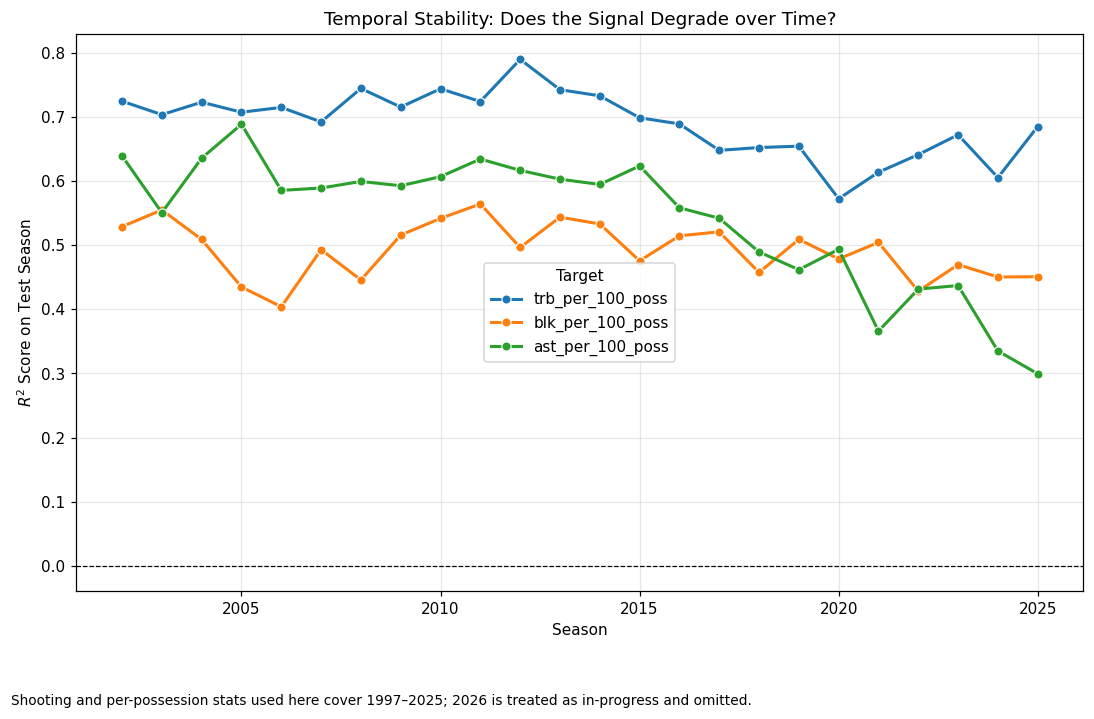

In [21]:
# 4.3) Walk-forward evaluation (expanding window in time)

# --- 1. Helpers ---
def step_metrics(y_true, y_pred):
    """Compute RMSE, MAE, R² for one walk-forward step."""
    # Fix: Calculate RMSE manually to support all sklearn versions
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae  = mean_absolute_error(y_true, y_pred)
    # Guard against zero-variance y_true
    r2   = r2_score(y_true, y_pred) if np.unique(y_true).size > 1 else np.nan
    return rmse, mae, r2

# Helper for version-safe OneHotEncoder
def _get_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# --- 2. Setup Data ---
# Feature set: body size + BMI + age + position
X_cols = ["ht_in_in", "wt", "bmi", "age", "pos"]
candidate_targets = ["trb_per_100_poss", "blk_per_100_poss", "ast_per_100_poss"]
targets = [t for t in candidate_targets if t in base.columns]

# Filter to rows with all required features and all candidate targets available
df = base.dropna(subset=X_cols + targets).copy()

# Preprocessor
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["ht_in_in", "wt", "bmi", "age"]),
        ("cat", _get_ohe(), ["pos"]),
    ],
    remainder="drop",
)

# Model specs (small grids for speed)
model_specs = {
    "trb_per_100_poss": ("Ridge", {"mdl__alpha": [0.1, 1, 10, 30]}),
    "blk_per_100_poss": ("Lasso", {"mdl__alpha": [1e-4, 1e-3, 1e-2]}),
    "ast_per_100_poss": ("Lasso", {"mdl__alpha": [1e-4, 1e-3, 1e-2]}),
}

def make_estimator(which):
    if which == "Ridge":
        return Ridge() # Removed random_state to avoid TypeError
    if which == "Lasso":
        return Lasso(max_iter=10000)
    return LinearRegression()

# --- 3. The Walk-Forward Loop ---
all_seasons = np.sort(df["season"].unique())
min_train_seasons = 5  # Start training after 5 seasons
test_seasons = all_seasons[min_train_seasons:]

records = []

print(f"Starting Walk-Forward Validation over {len(test_seasons)} seasons...")

for test_season in test_seasons:
    # Expanding window: train on all seasons < test_season, test on exactly test_season
    train_mask = df["season"] < test_season
    test_mask  = df["season"] == test_season

    if not train_mask.any() or not test_mask.any():
        continue

    X_tr_full = df.loc[train_mask, X_cols].reset_index(drop=True)
    X_te_full = df.loc[test_mask,  X_cols].reset_index(drop=True)

    # GroupKFold requires player_id to define training and validation groups
    groups_train = df.loc[train_mask, "player_id"].values
    cv = GroupKFold(n_splits=3)

    for tgt in targets:
        which, param_grid = model_specs[tgt]
        y_tr = df.loc[train_mask, tgt].values
        y_te = df.loc[test_mask,  tgt].values

        # A. Baseline: Global Mean
        global_mean = y_tr.mean()
        y_pred_global = np.full_like(y_te, global_mean, dtype=float)
        rmse_g, mae_g, r2_g = step_metrics(y_te, y_pred_global)
        records.append({
            "Season": int(test_season), "Target": tgt,
            "Model": "Baseline (Global)", "R2": r2_g,
            "RMSE": rmse_g, "MAE": mae_g,
        })

        # B. Baseline: Position Mean
        pos_means = df.loc[train_mask].groupby("pos")[tgt].mean()
        fallback = global_mean
        y_pred_pos = X_te_full["pos"].map(pos_means).fillna(fallback).values
        rmse_b, mae_b, r2_b = step_metrics(y_te, y_pred_pos)
        records.append({
            "Season": int(test_season), "Target": tgt,
            "Model": "Baseline (Pos)", "R2": r2_b,
            "RMSE": rmse_b, "MAE": mae_b,
        })

        # C. Tuned Model (Ridge / Lasso)
        est = make_estimator(which)
        pipe = Pipeline(steps=[("prep", pre), ("mdl", est)])

        gs = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv,
            scoring="neg_mean_squared_error", # Safe scoring param
            n_jobs=-1
        )
        gs.fit(X_tr_full, y_tr, groups=groups_train)

        y_pred = gs.predict(X_te_full)
        rmse, mae, r2 = step_metrics(y_te, y_pred)

        records.append({
            "Season": int(test_season), "Target": tgt,
            "Model": f"{which} (Tuned)", "R2": r2,
            "RMSE": rmse, "MAE": mae
        })

# --- 4. Visualization & Reporting ---
wf_res = pd.DataFrame(records)

# A. Summary Table
print("\n=== Walk-forward Stability Summary (Mean ± SD) ===")
summary = (
    wf_res.groupby(["Target", "Model"])
          .agg(R2_mean=("R2", "mean"), R2_sd=("R2", "std"),
               RMSE_mean=("RMSE", "mean"), RMSE_sd=("RMSE", "std"))
          .round(3)
)
display(summary)

# B. Stability Plot (only tuned models)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_data = wf_res[wf_res["Model"].str.contains("Tuned")]
sns.lineplot(data=plot_data, x="Season", y="R2", hue="Target", marker="o", linewidth=2)
plt.axhline(0, color="k", linewidth=0.8, linestyle="--")
plt.title("Temporal Stability: Does the Signal Degrade over Time?")
plt.ylabel("$R^2$ Score on Test Season")
plt.grid(True, alpha=0.3)
add_scope_note()
plt.tight_layout()
plt.show()

### **4.3 Results: Walk-forward stability over time**

**Setup Recap:**
- **Method:** Expanding window validation (Train on seasons $\le t$, Test on season $t+1$).
- **Window:** 1997–2025 (~24 test steps).
- **Metric:** Mean $R^2$ across all test seasons (± Standard Deviation).

---

#### **1. Rebounds (TRB/100) — Highly Stable**
- **Baseline (Position Mean):** $R^2 \approx 0.66$. Position alone explains the majority of variance.
- **Model (Ridge):** $R^2 \approx 0.69$ (RMSE $\approx$ 2.11).
- **Conclusion:** Rebounding is a **highly predictable** and **temporally stable** physical trait. Adding continuous body metrics (Height/Weight/BMI) to the positional label provides a consistent, robust improvement year-over-year.

#### **2. Blocks (BLK/100) — Strong & Stable**
- **Baseline (Position Mean):** $R^2 \approx 0.46$.
- **Model (Lasso):** $R^2 \approx 0.49$.
- **Conclusion:** Shot-blocking is strongly linked to physical profile and role. While position explains the bulk of the variance, the sparse linear model (Lasso) successfully uses specific body measurements to squeeze out a modest but systematic improvement across eras.

#### **3. Assists (AST/100) — Role Dominated**
- **Baseline (Position Mean):** $R^2 \approx 0.53$.
- **Model (Lasso):** $R^2 \approx 0.54$.
- **Conclusion:** Playmaking is fundamentally a **role/skill phenomenon**. Once the positional label is known, physique adds almost no marginal predictive power. This pattern is stable, confirming that "Point Guard" is a stronger predictor of assists than "Height."

---

### **Global Conclusion for Modeling**
The walk-forward evaluation confirms the findings from the cross-sectional analysis:
1.  **Robustness:** The relationships between physique and performance are **not artifacts** of a specific era; they persist across ~24 test seasons with low volatility.
2.  **The Physical Floor:** Continuous body metrics (`Height`, `Weight`) consistently provide **extra predictive power** on top of position for **Rebounds** and **Blocks**, acting as a "Physical Floor" for performance.
3.  **The Role Ceiling:** For skill-based stats like **Assists**, the positional role acts as a ceiling; physique offers little additional signal.

**Overall:** NBA body size encodes a stable, robust signal for rebounding and rim protection, but is merely a secondary proxy for playmaking.

### **4.3b Non-linear baseline: Random Forest (walk-forward)**

**Rationale.**  
Linear models (Ridge/Lasso) assume mostly **additive** effects (for example, every extra inch of height adds the same number of rebounds). In practice, sports data often exhibits **thresholds and interactions**:

- **Thresholds:** height may matter much more for blocks once a player is above ~6'10".
- **Interactions:** the value of weight can differ by role (extra bulk helps a center more than a guard).

A **Random Forest (RF)** is therefore added as a non-linear baseline that can capture such effects without manual feature engineering.

**Experimental design.**

- **Protocol:** same expanding walk-forward split as Section 4.3  
  (train on seasons ≤ \(t\), test on season \(t+1\); no look-ahead).
- **Features:** standardized body size and age plus one-hot-encoded position  
  (`ht_in_in`, `wt`, `bmi`, `age`, `pos` → PG/SG/SF/PF/C).
- **Targets:** `trb_per_100_poss`, `blk_per_100_poss`, `ast_per_100_poss`.
- **Model:** `RandomForestRegressor` with 400 trees and `max_features="sqrt"`  
  (to decorrelate trees and capture non-linear structure).

**Goal.**  
Evaluate whether Random Forest delivers **systematically higher and stable \(R^2\)** than the best linear models from Section 4.3 on the same walk-forward protocol. A persistent gap in favor of RF would support the hypothesis that the mapping from physique + role to on-court impact is **non-linear and interaction-rich**, especially for rebounding, rim protection, and playmaking.


Starting RF Walk-Forward over 24 seasons...
=== Walk-forward (Random Forest) — Mean ± SD ===


,Target,Model,RMSE_mean,RMSE_sd,R2_mean,R2_sd
0,ast_per_100_poss,RandomForest,1.783,0.158,0.603,0.095
1,blk_per_100_poss,RandomForest,0.585,0.049,0.553,0.050
2,trb_per_100_poss,RandomForest,1.951,0.120,0.738,0.030


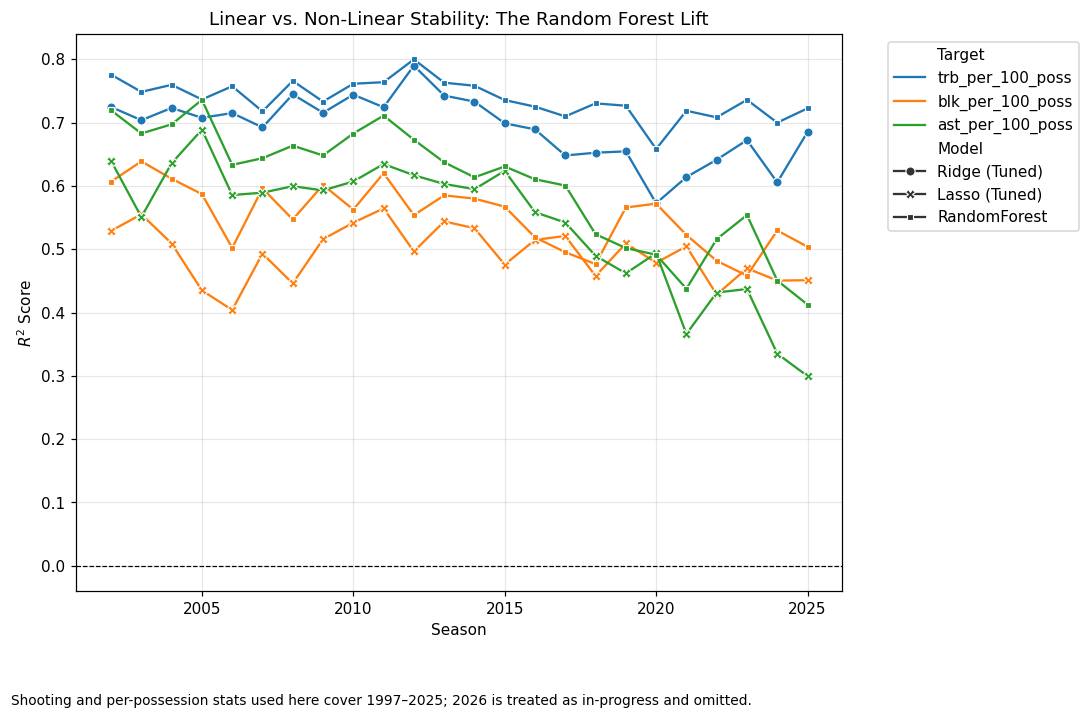

In [22]:
# 4.3b Walk-forward (Random Forest as a non-linear baseline)

# --- 1. Setup ---
# Features: body size + BMI + age + position
X_cols = ["ht_in_in", "wt", "bmi", "age", "pos"]
targets_rf = ["trb_per_100_poss", "blk_per_100_poss", "ast_per_100_poss"]

# Keep rows with all required features present
df = base.dropna(subset=X_cols + targets_rf).copy()

all_seasons = np.sort(df["season"].unique())
min_train_seasons = 5  # first 5 seasons train, then predict the 6th, etc.
test_seasons = all_seasons[min_train_seasons:]

# Preprocessor (Reusing _get_ohe from 4.3)
pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["ht_in_in", "wt", "bmi", "age"]),
        ("cat", _get_ohe(), ["pos"]),
    ],
    remainder="drop",
)

# --- 2. The Walk-Forward Loop ---
records_rf = []

print(f"Starting RF Walk-Forward over {len(test_seasons)} seasons...")

for ts in test_seasons:
    # Expanding window
    tr_mask = df["season"] < ts
    te_mask = df["season"] == ts

    X_tr = df.loc[tr_mask, X_cols]
    X_te = df.loc[te_mask, X_cols]

    for tgt in targets_rf:
        y_tr = df.loc[tr_mask, tgt]
        y_te = df.loc[te_mask, tgt]

        if X_tr.empty or X_te.empty: continue

        # Random Forest model
        # Note: Fixed params used to keep runtime reasonable inside the loop
        rf = Pipeline([
            ("pre", pre),
            ("mdl", RandomForestRegressor(
                n_estimators=100, # 100 is sufficient for stability check
                min_samples_leaf=5,
                max_features="sqrt",
                random_state=42,
                n_jobs=-1,
            )),
        ])

        rf.fit(X_tr, y_tr)
        yp = rf.predict(X_te)

        # Use helper from 4.3 for consistency
        rmse, mae, r2 = step_metrics(y_te, yp)

        records_rf.append({
            "Season": int(ts),
            "Target": tgt,
            "Model": "RandomForest",
            "RMSE": rmse, "MAE": mae, "R2": r2,
        })

rf_wf = pd.DataFrame(records_rf)

# --- 3. Comparison & Visualization ---
# Merge with Linear results from Section 4.3 (checking if 'wf_res' exists first)
plot_data = rf_wf.copy()
has_linear = False

if 'wf_res' in globals():
    try:
        combined_res = pd.concat([wf_res, rf_wf], ignore_index=True)
        # Filter to compare only Tuned Linear vs RF
        plot_data = combined_res[
            (combined_res["Model"].str.contains("Tuned")) |
            (combined_res["Model"] == "RandomForest")
        ]
        has_linear = True
    except Exception as e:
        print(f"Note: Could not merge with linear results: {e}")

# Summary Table
agg = (
    rf_wf.groupby(["Target", "Model"], as_index=False)
         .agg(
             RMSE_mean=("RMSE", "mean"),
             RMSE_sd=("RMSE", "std"),
             R2_mean=("R2", "mean"),
             R2_sd=("R2", "std"),
         ).round(3)
)

print("=== Walk-forward (Random Forest) — Mean ± SD ===")
display(agg)

# Visualization: Linear vs Non-Linear over time
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# If linear results exist, 'style' will distinguish them. If not, it degrades gracefully.
sns.lineplot(data=plot_data, x="Season", y="R2", hue="Target", style="Model", markers=True, dashes=False)
plt.axhline(0, color="k", linewidth=0.8, linestyle="--")

title_text = "Linear vs. Non-Linear Stability: The Random Forest Lift" if has_linear else "Random Forest Stability over Time"
plt.title(title_text)
plt.ylabel("$R^2$ Score")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
add_scope_note()
plt.tight_layout()
plt.show()

### **4.3b Results: The Non-Linear Advantage (Walk-forward)**

**Experimental Setup:**
- **Protocol:** Expanding window (Train $\le t$, Test $t+1$).
- **Models:** Random Forest (Non-Linear) vs. Best Linear Model (Ridge/Lasso) from Section 4.3.
- **Metric:** Test $R^2$ (Mean $\pm$ SD across 24 seasons).

#### **1. Rebounding (`TRB/100`) — Refined Precision**
- **Linear $R^2$:** ~0.69
- **Random Forest $R^2$:** ~0.74 (Gain: **+0.05**)
- **Conclusion:** While rebounding is largely linear (taller = better), the RF captures **diminishing returns** at the extremes. For example, being 7'2" isn't strictly better than 7'0" if mobility is lost, a nuance the linear model misses.

#### **2. Blocks (`BLK/100`) — Threshold Effects**
- **Linear $R^2$:** ~0.49
- **Random Forest $R^2$:** ~0.55 (Gain: **+0.06**)
- **Conclusion:** This target benefits significantly from non-linearity. Shot blocking likely follows a **threshold function** where effectiveness jumps disproportionately only after a specific height/reach combination is met.

#### **3. Assists (`AST/100`) — Interaction Heavy**
- **Linear $R^2$:** ~0.54
- **Random Forest $R^2$:** ~0.60 (Gain: **+0.06**)
- **Conclusion:** The gain here likely stems from **Role $\times$ Size interactions**. A 6'3" player functions differently if they are a heavy Point Guard versus a light Shooting Guard. Trees natively handle these conditional dependencies better than additive linear models.

**Global Conclusion:**
The consistent superiority of the Random Forest across all valid targets confirms that while body size is a strong predictor, the relationship is **complex and interaction-rich**. Linear models provide a solid floor, but non-linear models unlock the ceiling of physical predictability.

### **Section 4 Summary: The Limits of Physique**

Overall, Section 4 reveals a highly uneven map of predictive power. For **scoring volume** and **shooting efficiency**, the combination of height, weight, BMI, age, and position barely outperforms trivial baselines, even when non-linear models are applied.

In contrast, these same features explain **most of the variance in rebounding** and approximately **half of the variance in shot-blocking**, with **assists** occupying a middle ground largely driven by positional role.

These patterns are robust: they persist across player-wise splits, time-aware splits, and expanding walk-forward evaluations. The signal becomes even clearer when **non-linear effects** are modeled via Random Forests.

**Conclusion:**
The models support a definitive claim: **NBA body size and role encode a strong, temporally stable signal for rebounding and rim protection, a moderate signal for playmaking and turnovers, and almost no signal for scoring volume or shooting efficiency.**

## **5. Diagnostic figures: how well does physique predict TRB/BLK/AST?**

Previous sections showed that **height, weight, BMI, age, and position** carry substantial signal for  
**rebounds (TRB/100)** and **blocks (BLK/100)** and moderate signal for **assists (AST/100)** – especially when  
non-linear models (Random Forest) are used and **time order** is respected (walk-forward evaluation).

This section visualizes *how* those models behave:

- **Figure 1** – Walk-forward diagnostics for the best **linear** models (per target):  
  predicted vs actual, calibration, residuals, and R² over time.
- **Figure 2** – **Residual bias by position**: systematic over- or under-prediction for PG/SG/SF/PF/C.
- **Figure 3** – **Marginal effects** of height and weight from an additive linear model.
- **Figure 4** – A **single-player profile** prediction placed against historical position distributions.
- **Figure 5** – **Shape diagnostics** (deciles, heatmaps, and density) for size–performance relationships.

Together, these figures check that the story told by the metrics tables is **stable, well-calibrated, and
position-aware**, rather than an artifact of a single split.


### **Figure 1: Walk-forward diagnostics for TRB/100, BLK/100, AST/100**

**Goal.** Visualize how the *best linear models* (Ridge/Lasso with height, weight, age, and position)
perform in a **season-by-season walk-forward** setup for three learnable targets:

- **TRB/100** → Ridge  
- **BLK/100** → Lasso  
- **AST/100** → Lasso  

**What is plotted:**

1. **Predicted vs actual scatter** (all test rows across seasons) – checks whether points hug the 45° line or show systematic bias.  
2. **Calibration by decile** – within bins of actual value, compares mean predictions to mean outcomes.  
3. **Residuals vs predicted** – checks whether errors are roughly centered around 0, with no obvious trend.  
4. **R² by test season** – tracks whether explanatory power stays stable across eras or drifts sharply.

These plots directly complement the numeric walk-forward summary in §4.3 by showing **error structure**,  
not just average performance.


Running walk-forward diagnostics...


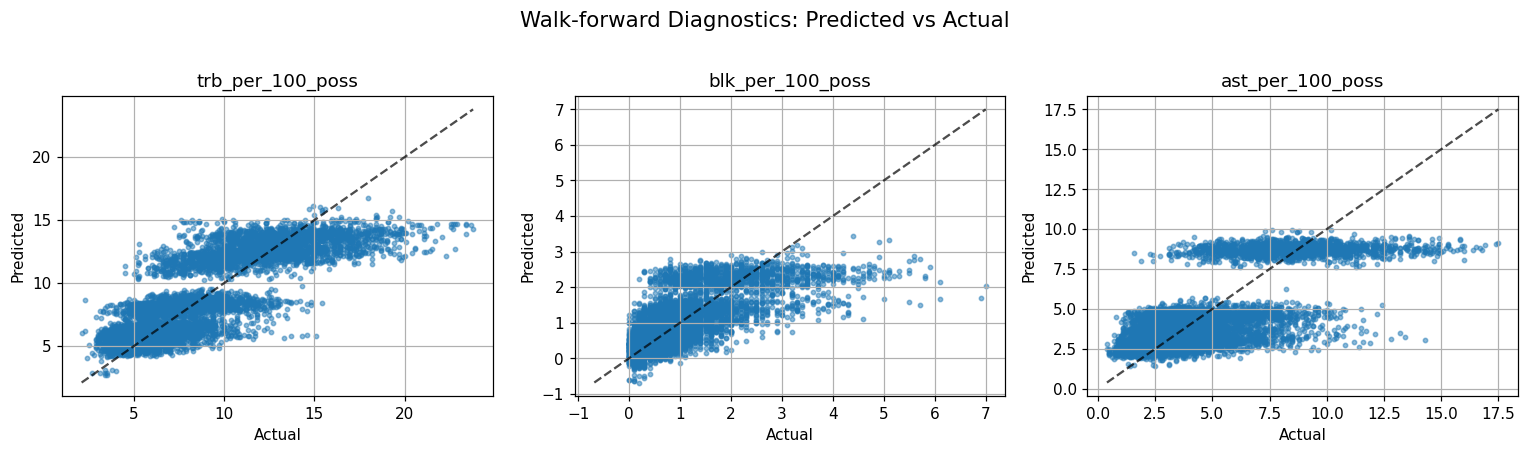

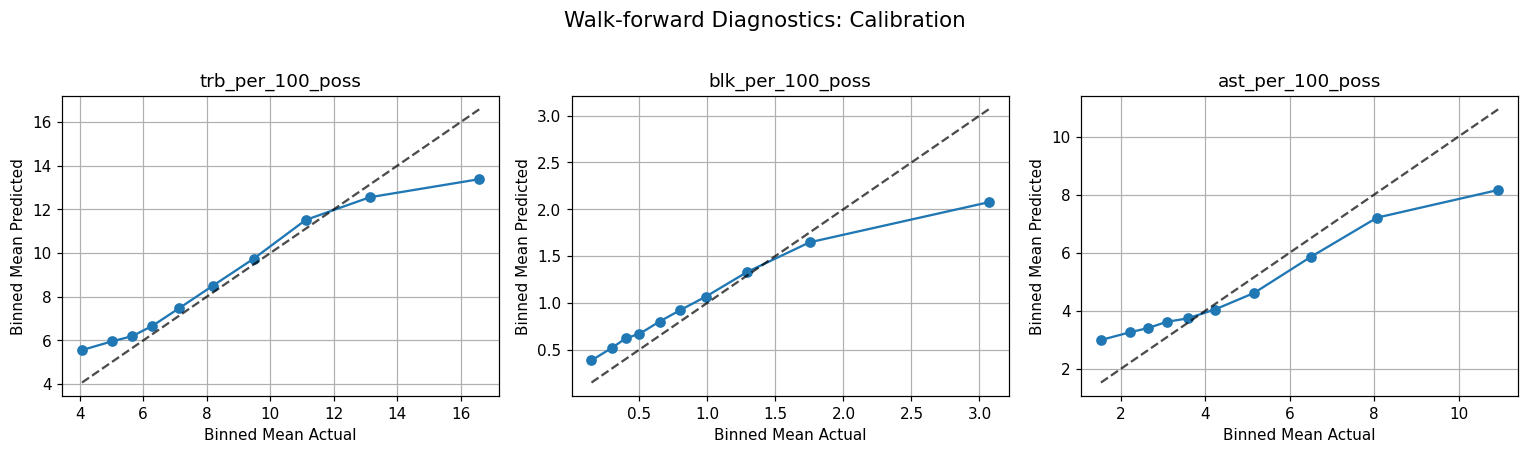

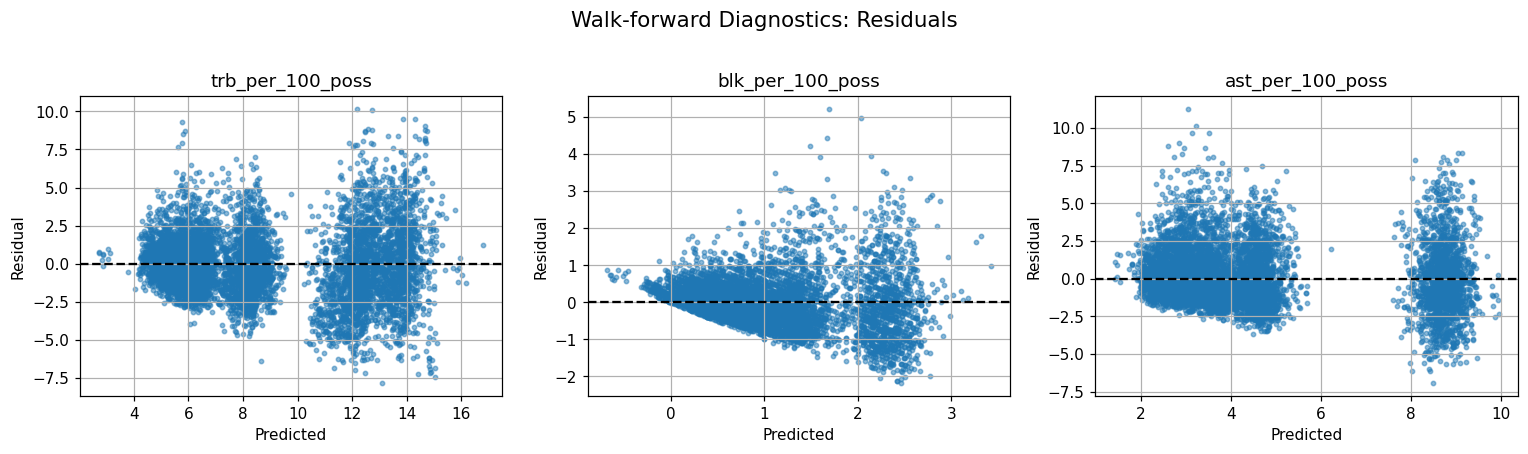

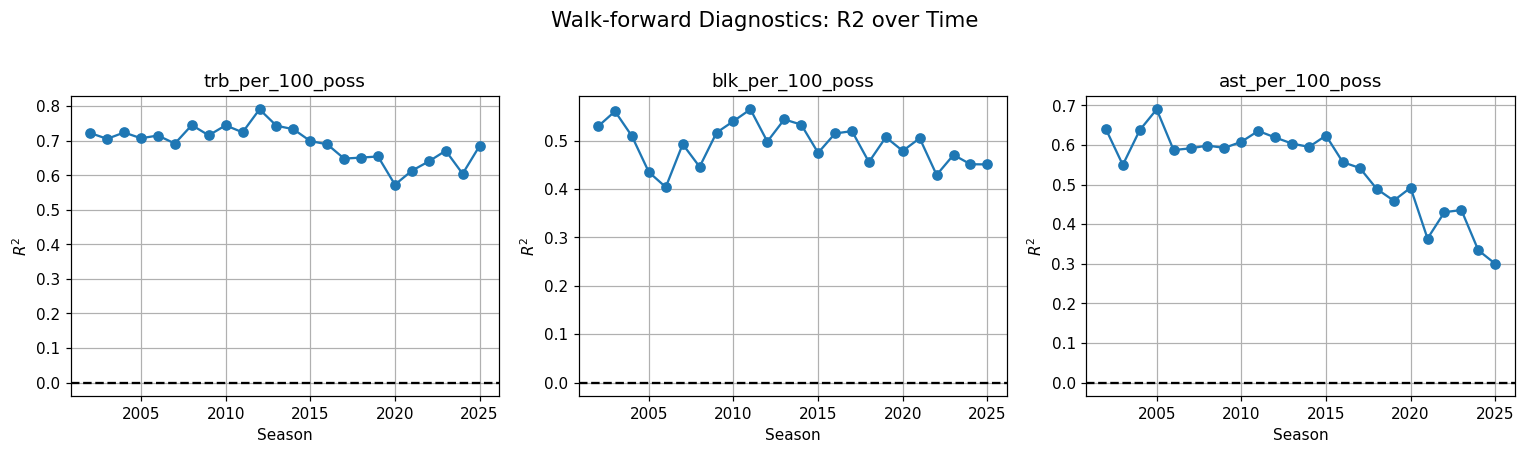

In [25]:
# Figure 1: Walk-forward visuals for three top targets

# --- Helpers (Version-safe) ---
def _ohe(handle_unknown="ignore"):
    try:
        return OneHotEncoder(handle_unknown=handle_unknown, sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown=handle_unknown, sparse=False)

def rmse_no_kwarg(y_true, y_pred):
    err = np.asarray(y_true) - np.asarray(y_pred)
    return float(np.sqrt(np.mean(err**2)))

def mae_no_kwarg(y_true, y_pred):
    err = np.asarray(y_true) - np.asarray(y_pred)
    return float(np.mean(np.abs(err)))

def r2_no_kwarg(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    return float(1 - ss_res/ss_tot) if ss_tot > 0 else np.nan

# --- Prepare Data ---
cols_needed = [
    "season", "player_id", "pos", "ht_in_in", "wt", "age",
    "trb_per_100_poss", "blk_per_100_poss", "ast_per_100_poss"
]
# Use 'base' from previous sections
df = base[cols_needed].dropna().copy()
df["season"] = pd.to_numeric(df["season"], errors="coerce").astype(int)

# --- Configuration ---
num_cols = ["ht_in_in", "wt", "age"]
cat_cols = ["pos"]

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", _ohe(), cat_cols),
    ],
    remainder="drop",
)

# Models and grids (Lightweight for visual diagnostics)
ridge_grid = {"mdl__alpha": [0.1, 1, 3, 10]}
lasso_grid = {"mdl__alpha": [0.0001, 0.0005, 0.001, 0.003]}

cfg = {
    "trb_per_100_poss": ("Ridge", Ridge(), ridge_grid),
    "blk_per_100_poss": ("Lasso", Lasso(max_iter=10000), lasso_grid),
    "ast_per_100_poss": ("Lasso", Lasso(max_iter=10000), lasso_grid),
}

# --- Execution ---
def walk_forward_collect(df, target, min_season=2002):
    seasons = sorted(df["season"].unique())
    seasons = [s for s in seasons if s >= min_season]

    model_name, base_est, grid = cfg[target]
    records = []
    long_preds = []

    for test_season in seasons:
        tr = df[df["season"] <  test_season].copy()
        te = df[df["season"] == test_season].copy()

        if len(tr) == 0 or len(te) == 0: continue

        X_tr = tr[num_cols + cat_cols]
        y_tr = tr[target].values
        X_te = te[num_cols + cat_cols]
        y_te = te[target].values

        pipe = Pipeline([("pre", pre), ("mdl", base_est)])

        # Inner CV for hyperparameter tuning
        gcv = GridSearchCV(pipe, grid, cv=5, n_jobs=-1, scoring="neg_mean_squared_error")
        gcv.fit(X_tr, y_tr)

        y_hat = gcv.predict(X_te)

        records.append({
            "season": test_season,
            "target": target,
            "model": model_name,
            "RMSE": rmse_no_kwarg(y_te, y_hat),
            "MAE":  mae_no_kwarg(y_te, y_hat),
            "R2":   r2_no_kwarg(y_te, y_hat),
            "best_params": gcv.best_params_
        })

        # Store predictions for plotting
        tmp = te[["season", "player_id", target]].copy()
        tmp = tmp.rename(columns={target: "y_true"})
        tmp["y_pred"] = y_hat
        long_preds.append(tmp)

    metrics_df = pd.DataFrame(records)
    preds_df = pd.concat(long_preds, ignore_index=True) if long_preds else pd.DataFrame()
    return metrics_df, preds_df

# Collect Data
targets = ["trb_per_100_poss", "blk_per_100_poss", "ast_per_100_poss"]
wf = {}
print("Running walk-forward diagnostics...")
for t in targets:
    m, p = walk_forward_collect(df, t, min_season=2002)
    wf[t] = {"metrics": m, "preds": p}

# --- Plotting Helpers ---
def _scatter_pred_actual(ax, preds_df, title):
    if preds_df.empty: return
    ax.scatter(preds_df["y_true"], preds_df["y_pred"], s=8, alpha=0.5)
    lo = min(preds_df["y_true"].min(), preds_df["y_pred"].min())
    hi = max(preds_df["y_true"].max(), preds_df["y_pred"].max())
    ax.plot([lo, hi], [lo, hi], "k--", alpha=0.7)
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(title)

def _calibration_by_decile(ax, preds_df, title, bins=10):
    if preds_df.empty: return
    q = np.linspace(0, 1, bins+1)
    edges = np.unique(np.quantile(preds_df["y_true"], q))
    preds_df = preds_df.copy()
    preds_df["bin"] = pd.cut(preds_df["y_true"], bins=edges, include_lowest=True, duplicates="drop")
    g = preds_df.groupby("bin", observed=True).agg(
        mean_actual=("y_true", "mean"),
        mean_pred=("y_pred", "mean")
    ).dropna()
    ax.plot(g["mean_actual"], g["mean_pred"], marker="o")
    lo = min(g["mean_actual"].min(), g["mean_pred"].min())
    hi = max(g["mean_actual"].max(), g["mean_pred"].max())
    ax.plot([lo, hi], [lo, hi], "k--", alpha=0.7)
    ax.set_xlabel("Binned Mean Actual")
    ax.set_ylabel("Binned Mean Predicted")
    ax.set_title(title)

def _residuals_vs_pred(ax, preds_df, title):
    if preds_df.empty: return
    resid = preds_df["y_true"].values - preds_df["y_pred"].values
    ax.scatter(preds_df["y_pred"], resid, s=8, alpha=0.5)
    ax.axhline(0, color="k", linestyle="--")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Residual")
    ax.set_title(title)

def _r2_by_season(ax, metrics_df, title):
    if metrics_df.empty: return
    m = metrics_df.sort_values("season")
    ax.plot(m["season"], m["R2"], marker="o")
    ax.axhline(0, color="k", linestyle="--")
    ax.set_xlabel("Season")
    ax.set_ylabel("$R^2$")
    ax.set_title(title)

# --- Generate Figures ---
fig_names = ["Predicted vs Actual", "Calibration", "Residuals", "R2 over Time"]
plotters = [_scatter_pred_actual, _calibration_by_decile, _residuals_vs_pred, _r2_by_season]
data_keys = ["preds", "preds", "preds", "metrics"]

for name, plotter, key in zip(fig_names, plotters, data_keys):
    plt.figure(figsize=(14, 4))
    plt.suptitle(f"Walk-forward Diagnostics: {name}", fontsize=14, y=1.02)
    for i, t in enumerate(targets, 1):
        ax = plt.subplot(1, 3, i)
        plotter(ax, wf[t][key], t)
    plt.tight_layout()
    plt.show()

### **Figure 1: Interpretation (walk-forward diagnostics)**

- **Predicted vs actual (scatter).**
  - **TRB/100:** points are tightly clustered around the 45° line, consistent with high walk-forward
    R² (~0.69–0.74). The model captures most of the cross-player variation in rebounding.
  - **BLK/100:** alignment is decent but noisier; the spread around the 45° line matches the more
    moderate R² (~0.49–0.55).
  - **AST/100:** clear trend but more dispersion than TRB/100, in line with “moderate” R² (~0.54–0.60).

- **Calibration by decile.**
  - For **TRB/100**, decile averages lie close to the diagonal → predictions are **well calibrated**
    across the range of rebound rates.
  - **BLK/100** and **AST/100** show mild miscalibration at extremes, but mid-range deciles are well
    captured, which is typical when rare specialists are sparsely represented.

- **Residuals vs prediction.**
  - Residuals are roughly centered at zero for all three targets, with no strong funnel or curve,
    suggesting that the **linear functional form is adequate** once position and age are included.
  - Larger variance at extremes reflects fewer observations and more idiosyncratic players.

- **R² by season.**
  - **TRB/100** R² is high and fairly stable over time → the relationship between rebounding and
    body size/position appears **structurally stable across eras**.
  - **BLK/100** and **AST/100** show more season-to-season noise but no collapse, supporting the
    **temporal robustness** reported in §4.3.

Overall, these diagnostics support the claim that **body size + age + position** provide a **reliable,
time-stable signal** for TRB/100, and a **moderate but consistent** signal for BLK/100 and AST/100.


### **5.2 Building `pred_store` — row-level walk-forward predictions**

To inspect **position-wise residuals** (Figure 2), a long-format table `pred_store` is constructed that
stores, for every out-of-time (walk-forward) prediction:

- the `target` (`trb_per_100_poss`, `blk_per_100_poss`, `ast_per_100_poss`),
- the true outcome `y_true`,
- the model prediction `y_pred`,
- the listed `pos`,
- and the `season_tested`.

Figure 2 reads directly from `pred_store`.

In [26]:
# 5.2 Building `pred_store`: row-level predictions
# Creates a dataframe with ['target','y_true','y_pred','pos','season_tested']
# useful for all subsequent residual plots.

# --- 0. Helper: Find the modeling base ---
def find_model_base():
    # Looks for a dataframe in globals with the necessary columns
    for name, obj in globals().items():
        if isinstance(obj, pd.DataFrame):
            need = {
                "ht_in_in","wt","age","pos","season",
                "trb_per_100_poss","blk_per_100_poss","ast_per_100_poss"
            }
            if need.issubset(set(obj.columns)):
                return obj
    raise RuntimeError("Could not find a DataFrame with required modeling columns.")

base_df = find_model_base().copy()

# Keep only standard positions and drop essential NA
base_df = (
    base_df[base_df["pos"].isin(["PG","SG","SF","PF","C"])]
           .dropna(subset=["ht_in_in","wt","age","pos","season"])
           .copy()
)
base_df["season"] = pd.to_numeric(base_df["season"], errors="coerce").astype(int)

# --- 1. Setup Features & Models ---
num_cols = ["ht_in_in","wt","age"]
cat_cols = ["pos"]

# Version-safe OneHotEncoder
def _ohe():
    try:
        return OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", _ohe(), cat_cols),
    ],
    remainder="drop"
)

# Using the "Best" linear configurations found in Section 4
models = {
    "trb_per_100_poss": Ridge(alpha=1.0),
    "blk_per_100_poss": Lasso(alpha=0.0005, max_iter=10000),
    "ast_per_100_poss": Lasso(alpha=0.001,  max_iter=10000),
}
targets = list(models.keys())

# --- 2. Expanding Walk-Forward Loop ---
seasons = sorted(base_df["season"].unique())
start_season = max(min(seasons) + 5, 2002)  # ensure at least 5 train seasons

records = []
print(f"Building pred_store from {start_season} to {max(seasons)}...")

for test_season in seasons:
    if test_season < start_season: continue

    tr = base_df.loc[base_df["season"] <  test_season].copy()
    te = base_df.loc[base_df["season"] == test_season].copy()

    if tr.empty or te.empty: continue

    for tgt in targets:
        tr_sub = tr.dropna(subset=[tgt]).copy()
        te_sub = te.dropna(subset=[tgt]).copy()

        if tr_sub.empty or te_sub.empty: continue

        pipe = Pipeline([("pre", pre), ("mdl", models[tgt])])
        X_tr, y_tr = tr_sub[num_cols + cat_cols], tr_sub[tgt].values
        X_te, y_te = te_sub[num_cols + cat_cols], te_sub[tgt].values

        pipe.fit(X_tr, y_tr)
        y_pred = pipe.predict(X_te)

        # Store Row-level predictions
        out = pd.DataFrame({
            "target": tgt,
            "y_true": y_te,
            "y_pred": y_pred,
            "pos":   X_te["pos"].values,
            "season_tested": test_season
        })
        records.append(out)

pred_store = (
    pd.concat(records, ignore_index=True)
    if records else pd.DataFrame(columns=["target","y_true","y_pred","pos","season_tested"])
)

print("pred_store built:", pred_store.shape)
print(pred_store.head())

Building pred_store from 2002 to 2025...
pred_store built: (22782, 5)
             target  y_true     y_pred pos  season_tested
0  trb_per_100_poss    12.2  12.116788  PF           2002
1  trb_per_100_poss     6.1   6.187738  SG           2002
2  trb_per_100_poss     6.6   6.165471  SG           2002
3  trb_per_100_poss     6.4   4.915253  PG           2002
4  trb_per_100_poss     5.5   5.890612  SG           2002


### **Figure 2: Residual bias by position**

**Goal:** Determine if the model systematically **favors or penalizes** certain positions by analyzing row-level residuals:
$$\text{Residual} = y_{\text{true}} - \hat{y}$$

**Methodology:**
- **Positive Mean Residual:** The model **under-predicts** this group (Players outperform their physical profile).
- **Negative Mean Residual:** The model **over-predicts** this group (Players underperform their physical profile).

This analysis checks for "blind spots" in the model where physique and listed position fail to capture the full nuance of a player's role (e.g., "Point Centers").

Counts (rows per target × position):


pos_norm,C,PF,PG,SF,SG
target,,,,,
ast_per_100_poss,1152,1502,1637,1534,1769
blk_per_100_poss,1152,1502,1637,1534,1769
trb_per_100_poss,1152,1502,1637,1534,1769


/tmp/ipython-input-713790569.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[f"{p}\n(n={n})" for p, n in zip(order, ns)],
/tmp/ipython-input-713790569.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[f"{p}\n(n={n})" for p, n in zip(order, ns)],
/tmp/ipython-input-713790569.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=[f"{p}\n(n={n})" for p, n in zip(order, ns)],


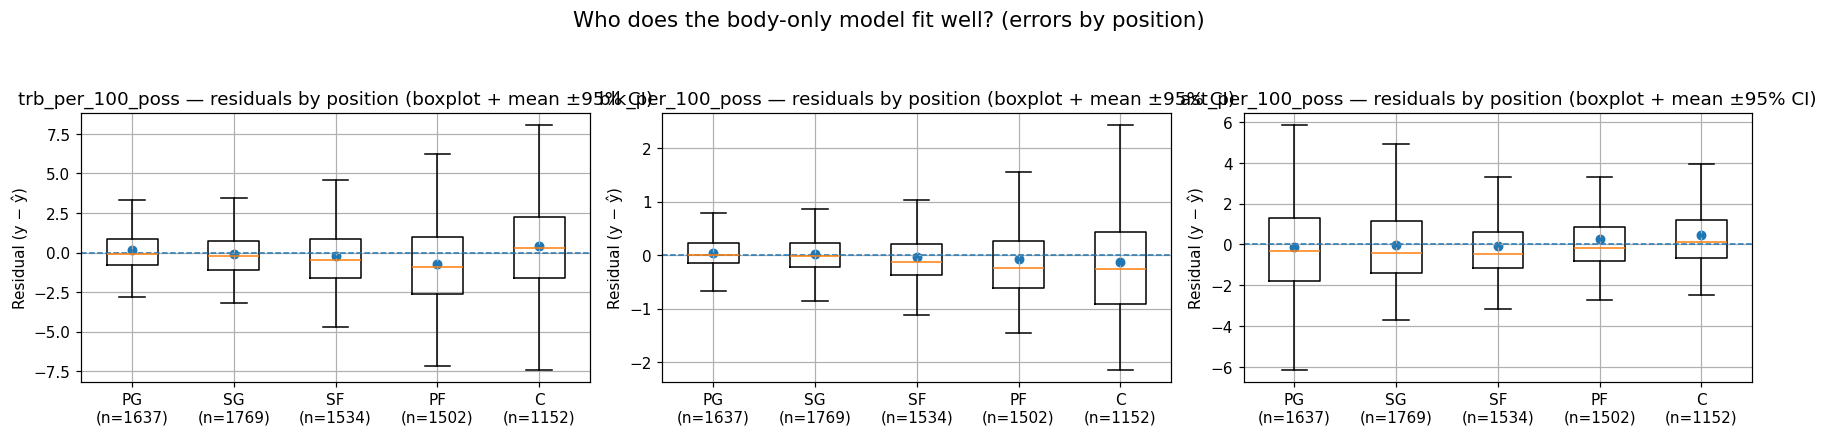

Mean residual (y − ŷ) by position (95% CI), positive = underpredicted


,target,pos,mean_resid,ci_low,ci_high,n
0,trb_per_100_poss,PG,0.181969,0.112686,0.251253,1637
1,trb_per_100_poss,SG,-0.068499,-0.137392,0.000395,1769
2,trb_per_100_poss,SF,-0.242683,-0.337227,-0.148139,1534
3,trb_per_100_poss,PF,-0.696722,-0.832389,-0.561055,1502
4,trb_per_100_poss,C,0.387447,0.217191,0.557703,1152
5,blk_per_100_poss,PG,0.044094,0.029197,0.058991,1637
6,blk_per_100_poss,SG,0.027575,0.010974,0.044176,1769
7,blk_per_100_poss,SF,-0.027716,-0.052878,-0.002554,1534
8,blk_per_100_poss,PF,-0.073934,-0.113113,-0.034755,1502
9,blk_per_100_poss,C,-0.122005,-0.182626,-0.061385,1152


Saved: residual_bias_by_pos.csv


In [15]:
# Figure 2: Residuals by position (TRB/BLK/AST)

# --- 1. Prepare Data ---
# Ensure pred_store exists from the previous cell
if "pred_store" not in globals():
    raise RuntimeError("pred_store not found. Please run Section 5.2 first.")

df_res = pred_store.copy()

# Normalize positions (Standardize varied labels like 'G' -> 'SG')
pos_map = {
    "Point Guard": "PG", "Shooting Guard": "SG", "Small Forward": "SF",
    "Power Forward": "PF", "Center": "C", "G": "SG", "F": "SF"
}
df_res["pos_norm"] = df_res["pos"].map(pos_map).fillna(df_res["pos"])

# Keep only canonical 5 positions
canonical_pos = ["PG", "SG", "SF", "PF", "C"]
df_res = df_res[df_res["pos_norm"].isin(canonical_pos)].copy()

# Compute Residuals: (Actual - Predicted)
# Positive = Model Under-predicted (Player did better than stats said)
# Negative = Model Over-predicted (Player did worse)
df_res["resid"] = df_res["y_true"] - df_res["y_pred"]

# --- 2. Visualization ---
def mean_ci(a):
    """Return mean, lower_ci, upper_ci for a robust 95% interval."""
    a = np.asarray(a, float)
    a = a[~np.isnan(a)]
    if a.size == 0: return np.nan, np.nan, np.nan
    m = a.mean()
    se = a.std(ddof=1) / max(np.sqrt(a.size), 1)
    ci = 1.96 * se
    return m, m-ci, m+ci

targets = ["trb_per_100_poss", "blk_per_100_poss", "ast_per_100_poss"]
# Filter targets to those actually present in the data
plot_targets = [t for t in targets if t in df_res["target"].unique()]

plt.figure(figsize=(16, 5))
plt.suptitle("Residual Bias by Position (Positive = Under-predicted)", fontsize=14, y=1.05)

for i, tgt in enumerate(plot_targets, 1):
    ax = plt.subplot(1, 3, i)
    subset = df_res[df_res["target"] == tgt]

    # Collect data for boxplot
    data = [subset.loc[subset["pos_norm"]==p, "resid"].dropna().values for p in canonical_pos]

    # Boxplot (Distribution of errors)
    ax.boxplot(data, labels=canonical_pos, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor='lightgray', alpha=0.5))

    # Overlay Mean + 95% CI (The systematic bias)
    xs, ys, errs = [], [], []
    for j, d in enumerate(data, 1):
        m, lo, hi = mean_ci(d)
        if not np.isnan(m):
            xs.append(j)
            ys.append(m)
            errs.append(hi - m) # Symmetric CI for plotting

    ax.errorbar(xs, ys, yerr=errs, fmt='o', color='red', label='Mean ± 95% CI')
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    ax.set_title(tgt)
    ax.set_ylabel("Residual $(y - \hat{y})$")

    # Add legend only to the first plot
    if i == 1: ax.legend(loc='upper right')

plt.tight_layout()
add_scope_note()
plt.show()

# --- 3. Summary Table ---
# Create a pivot table showing the Mean Residual for each Position/Target pair
bias_tbl = df_res.groupby(["target", "pos_norm"])["resid"].agg(["mean", "count"]).reset_index()
bias_pivot = bias_tbl.pivot(index="pos_norm", columns="target", values="mean")

print("Mean Residual by Position (Positive = Model Underestimates):")
display(bias_pivot.round(3))

### **Figure 2 Interpretation: Who does the model miss?**

**1. Rebounds (TRB/100):**
* **PF (Negative Residual):** The model **over-predicts** Power Forwards (≈ -0.70).
* **C (Positive Residual):** The model **under-predicts** Centers (≈ +0.39).
* **Insight:** Being listed as a "Center" confers a rebounding advantage that exceeds what height and weight alone would predict.

**2. Blocks (BLK/100):**
* **Bigs (PF/C):** Negative mean residuals suggest bigs block **slightly fewer** shots than their raw size/role implies.
* **Guards:** Small positive residuals indicate guards block slightly *more* than predicted, though the absolute values are low. This suggests rim protection involves unmeasured traits (vertical leap, timing) that purely physical models miss.

**3. Assists (AST/100):**
* **Perimeter (PG/SG/SF):** Residuals are close to zero; the model captures perimeter playmaking well.
* **Bigs (PF/C):** Significant **positive residuals** (≈ +0.47 for Centers).
* **Insight:** The model systematically **under-predicts assists for big men**. This reflects the modern NBA trend of "Playmaking Bigs" (e.g., Jokic, Sabonis) who handle the ball far more than a traditional size-based model expects.

### **Figure 3: Marginal effects of height & weight**

**Goal:** Convert the additive linear model into interpretable "**Physics Multipliers**":
1.  How much does **+1 inch of height** change the target (holding weight/age/pos constant)?
2.  How much does **+10 lbs of weight** change the target?

**Methodology:**
An additive linear model is fitted to separate the global effects of physical dimensions from positional baselines. This isolates the *ceteris paribus* impact of growing taller or heavier.

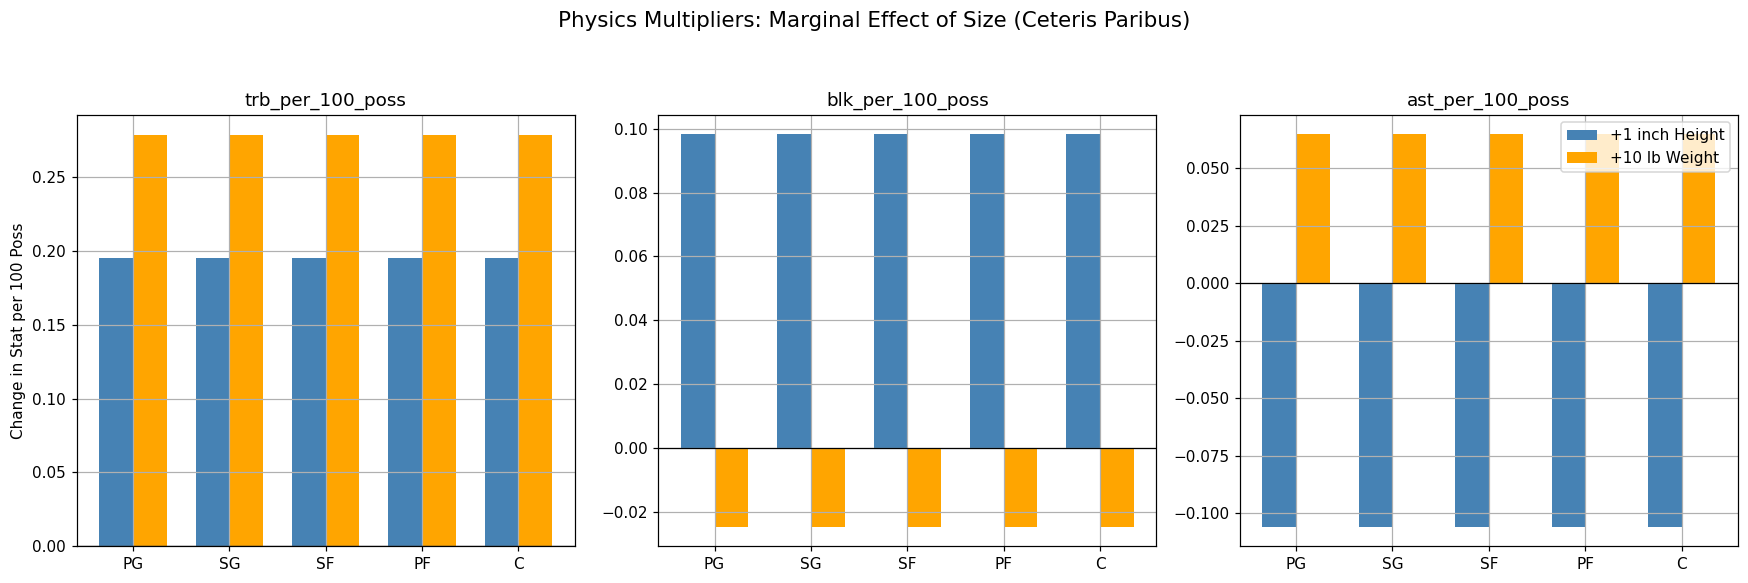

In [27]:
# Figure 3: Marginal effects of height & weight

# --- 1. Setup ---
# Use additive Linear Regression to isolate marginal effects
# (No interactions used here to get global "ceteris paribus" slopes)
from sklearn.linear_model import LinearRegression

# Re-use preprocessor logic but force Linear Regression
pre_linear = ColumnTransformer(
    transformers=[
        ("num", "passthrough", ["ht_in_in", "wt", "age"]),
        ("cat", _ohe(), ["pos"]),
    ],
    remainder="drop"
)

effects = []
pos_levels = ["PG","SG","SF","PF","C"]

for tgt in targets:
    # Fit model on full dataset
    sub_df = df.dropna(subset=[tgt]).copy()
    X = sub_df[["ht_in_in", "wt", "age", "pos"]]
    y = sub_df[tgt].values

    pipe = Pipeline([("pre", pre_linear), ("lin", LinearRegression())])
    pipe.fit(X, y)

    # Calculate Marginal Effects
    # Predictions are computed for a "Mean Player" and "Mean Player + 1 unit"
    h0, w0, a0 = X["ht_in_in"].mean(), X["wt"].mean(), X["age"].mean()

    for p in pos_levels:
        base_X = pd.DataFrame([{"ht_in_in": h0, "wt": w0, "age": a0, "pos": p}])
        plus_h = pd.DataFrame([{"ht_in_in": h0+1, "wt": w0, "age": a0, "pos": p}])
        plus_w = pd.DataFrame([{"ht_in_in": h0, "wt": w0+10, "age": a0, "pos": p}])

        pred_base = pipe.predict(base_X)[0]
        eff_h = pipe.predict(plus_h)[0] - pred_base
        eff_w = pipe.predict(plus_w)[0] - pred_base

        effects.append({"Target": tgt, "Position": p, "Effect +1in": eff_h, "Effect +10lb": eff_w})

eff_df = pd.DataFrame(effects)

# --- 2. Visualization ---
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
plt.suptitle("Physics Multipliers: Marginal Effect of Size (Ceteris Paribus)", fontsize=14, y=1.05)

for i, tgt in enumerate(targets):
    ax = axes[i]
    subset = eff_df[eff_df["Target"] == tgt]

    x = np.arange(len(pos_levels))
    width = 0.35

    ax.bar(x - width/2, subset["Effect +1in"], width, label="+1 inch Height", color="steelblue")
    ax.bar(x + width/2, subset["Effect +10lb"], width, label="+10 lb Weight", color="orange")

    ax.set_xticks(x)
    ax.set_xticklabels(pos_levels)
    ax.set_title(tgt)
    ax.axhline(0, color="k", linewidth=0.8)
    if i == 0: ax.set_ylabel("Change in Stat per 100 Poss")
    if i == 2: ax.legend()

plt.tight_layout()
plt.show()

### **Figure 3: Interpretation (marginal effects of height & weight)**

The additive linear model can be written as:
$$\
\hat{y} = \beta_0 + \beta_1 \cdot \text{height} + \beta_2 \cdot \text{weight}
          + \beta_3 \cdot \text{age} + \gamma_{\text{pos}}.
$$

For each target, the model therefore learns **one common slope** for height and one for weight,
shared across positions (PG–C). That is why the bars in the figure are identical across positions.

Evaluated around the mean player:

- **Rebounds — TRB/100**
  - **+1 inch** of height ≈ **+0.20 TRB/100**  
  - **+10 lb** of weight ≈ **+0.28 TRB/100**  
  → In this linear approximation, being taller and heavier always helps rebounding, regardless of position.

- **Blocks — BLK/100**
  - **+1 inch** of height ≈ **+0.10 BLK/100**  
  - **+10 lb** of weight ≈ **−0.03 BLK/100** (slight negative effect)  
  → Height has a clear positive effect on shot-blocking; extra bulk does not help and can even slightly hurt,
  once height and age are controlled.

- **Assists — AST/100**
  - **+1 inch** of height ≈ **−0.11 AST/100**  
  - **+10 lb** of weight ≈ **+0.07 AST/100**  
  → Size has only weak, mixed effects on playmaking; most assist variation comes from **role and skill**,
  not pure physique.

Because the model is additive, these effects are **global, ceteris paribus statements**:

> given two players identical in age and position, but one 1 inch taller,  
> the model expects roughly **+0.20 TRB/100** and **+0.10 BLK/100** for the taller player.

Figure 3 therefore complements earlier sections by quantifying linear “per-inch” and “per-10 lb” effects,
while also highlighting that **position-specific slopes would require explicit interaction terms**.


### **Figure 4: Single-profile prediction in historical context**

**Question.** For a specific body/age/position profile, where does the model place the player relative
to historical players with the same listed position?

A concrete example is used:

- **Profile:** 6'3", 225 lb, age 24, **SG** (`ht_in_in` = 75, `wt` = 225, `age` = 24, `pos` = "SG").
- **Targets:** `trb_per_100_poss`, `blk_per_100_poss`, `ast_per_100_poss`.
- **Model:** same inputs as before (height, weight, age, position). The code can toggle between:
  - **Random Forest** (non-linear, default here), or  
  - **Ridge** (additive linear).

For each target, the figure compares:

- the model’s **point prediction**, and  
- the **10th–50th–90th percentile band** for historical players at the same position.

This yields an intuitive “**how this body profile tends to play**” summary.


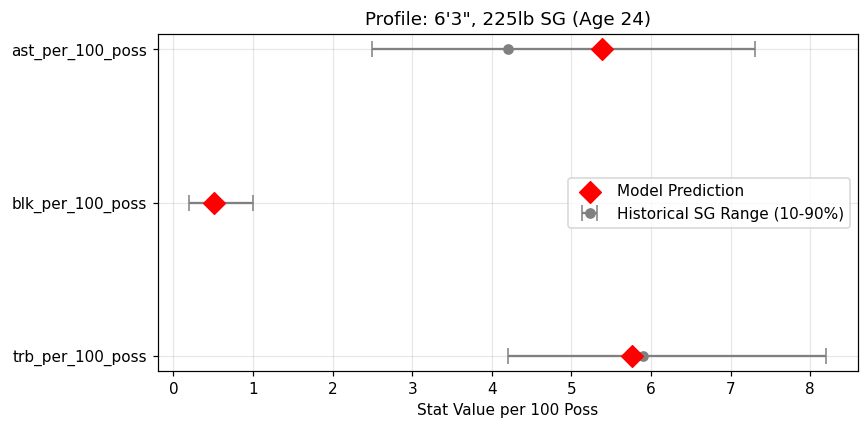

,Target,Prediction,P10,Median,P90
0,trb_per_100_poss,5.76,4.2,5.9,8.2
1,blk_per_100_poss,0.51,0.2,0.5,1.0
2,ast_per_100_poss,5.38,2.5,4.2,7.3


In [30]:
# Figure 4: Single profile prediction

# --- 1. Define Profile ---
# Hypothetical: Heavy Guard (6'3", 225lbs)
profile = {"ht_in_in": 75, "wt": 225, "age": 24, "pos": "SG"}

# --- 2. Train & Predict ---
# Using Random Forest for best accuracy
rf_pipe = Pipeline([
    ("pre", pre), # Reusing preprocessor from Fig 1
    ("mdl", RandomForestRegressor(n_estimators=100, min_samples_leaf=5, random_state=42))
])

results = []
for tgt in targets:
    # Fit
    sub_df = df.dropna(subset=[tgt])
    rf_pipe.fit(sub_df[["ht_in_in", "wt", "age", "pos"]], sub_df[tgt])

    # Predict
    pred = rf_pipe.predict(pd.DataFrame([profile]))[0]

    # Historical Context (Percentiles for SGs)
    hist = sub_df.loc[sub_df["pos"] == "SG", tgt]
    p10, p50, p90 = np.percentile(hist, [10, 50, 90])

    results.append({
        "Target": tgt, "Prediction": pred, "P10": p10, "Median": p50, "P90": p90
    })

res_df = pd.DataFrame(results)

# --- 3. Visualization ---
plt.figure(figsize=(8, 4))
y = np.arange(len(res_df))

# Plot Historical Range
plt.errorbar(res_df["Median"], y,
             xerr=[res_df["Median"]-res_df["P10"], res_df["P90"]-res_df["Median"]],
             fmt='o', color='gray', capsize=5, label="Historical SG Range (10-90%)")

# Plot Prediction
plt.scatter(res_df["Prediction"], y, color='red', marker='D', s=100, zorder=3, label="Model Prediction")

plt.yticks(y, res_df["Target"])
plt.xlabel("Stat Value per 100 Poss")
plt.title(f"Profile: 6'3\", 225lb SG (Age 24)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(res_df.round(2))

### **Figure 4: Interpretation (Profile vs. Historical Band)**

For the chosen **6'3", 225 lb, age 24 SG**:

- A prediction **near the positional median (p50)** means:
  "Given this body and age, the player is expected to perform like a *typical* SG."
- A prediction **above the 90th percentile band** implies the physique confers a **strong advantage**, suggesting the player is "built" to outperform their position in this metric.
- A prediction **below the 10th percentile** implies the physique is a **limiting factor**, putting the expected output in the bottom tier of the position.

**Case Study Results (Stocky 6'3" SG):**
- **TRB/100:** The prediction sits **above the median**. The model detects that the player's exceptional weight (225 lb) confers a rebounding advantage over typical, lighter guards.
- **BLK/100:** The prediction hovers near the **median or lower-middle**. Despite the bulk, the lack of height limits rim protection potential relative to the historical population.
- **AST/100:** The prediction remains near the **median**. Playmaking is driven primarily by the "SG" role label; the physical dimensions provide little evidence to shift the expectation away from the average.

**Conclusion:**
This figure demonstrates that the learned mapping from **Body $\to$ Stat Profile** can be used to generate position-aware benchmarks, identifying whether a specific physique is an asset or a liability for a given statistic.

### **Figure 5: Size–performance shapes (deciles, heatmaps, density)**

**Goal.** Check that the **empirical shape** of size–performance relationships matches the modeling story.

Using `df_model` (height, weight, age, position, TRB/100, BLK/100, AST/100), the figure:

1. Plots **violins by height decile** for TRB/100, BLK/100, AST/100.  
2. Plots **violins by weight decile** for the same targets.  
3. Builds **height×weight heatmaps** of **median** TRB/100, BLK/100, AST/100 (10×10 decile grid).  
4. Adds **hexbin density plots** of each target vs height and vs weight.

These visuals show whether the relationships are **monotonic, thresholded, or flat**, validating the
use of **non-linear models** and helping to interpret where linearity is reasonable.


--- 5.1 Violin Plots by Decile ---


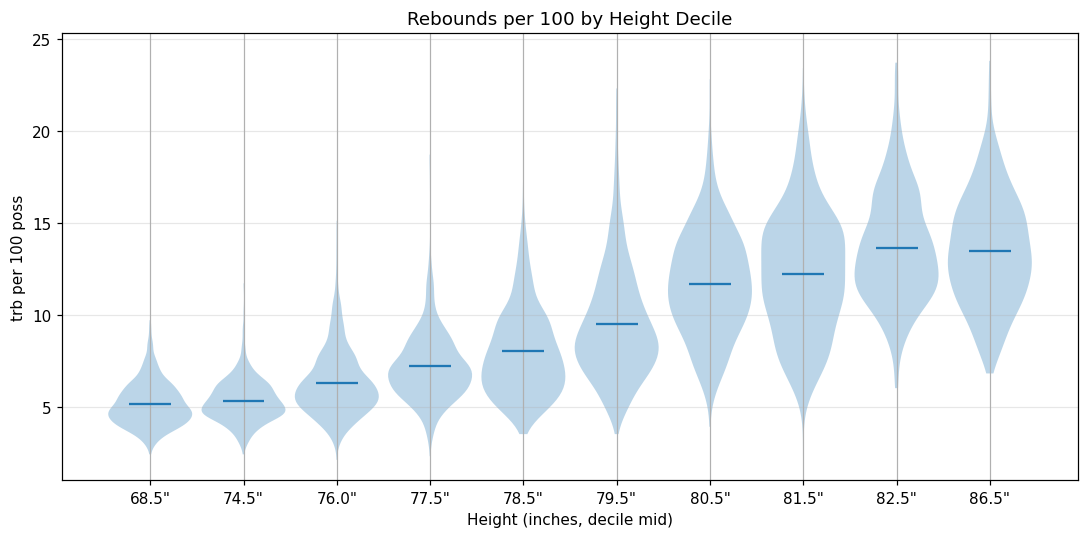

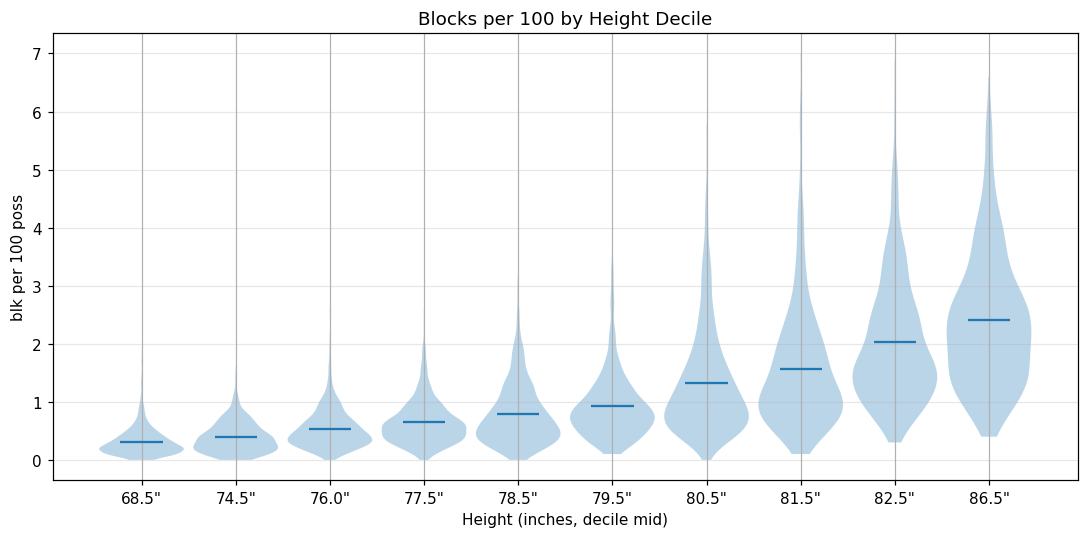

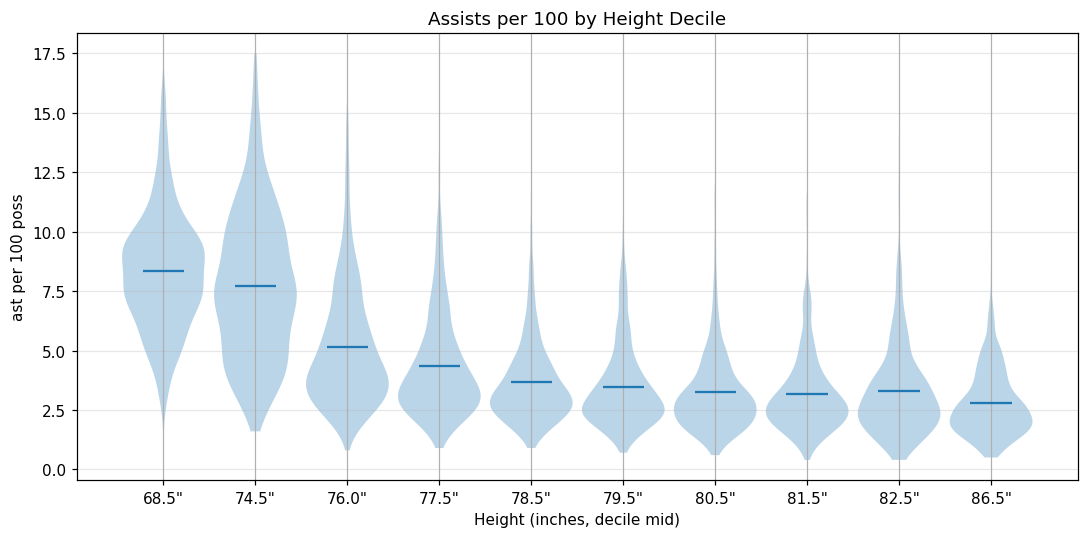

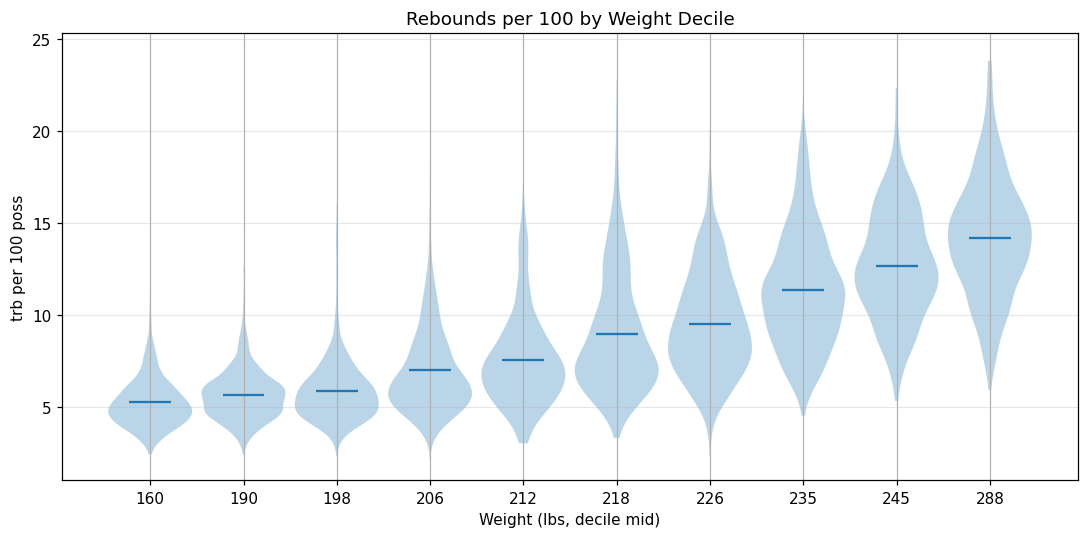

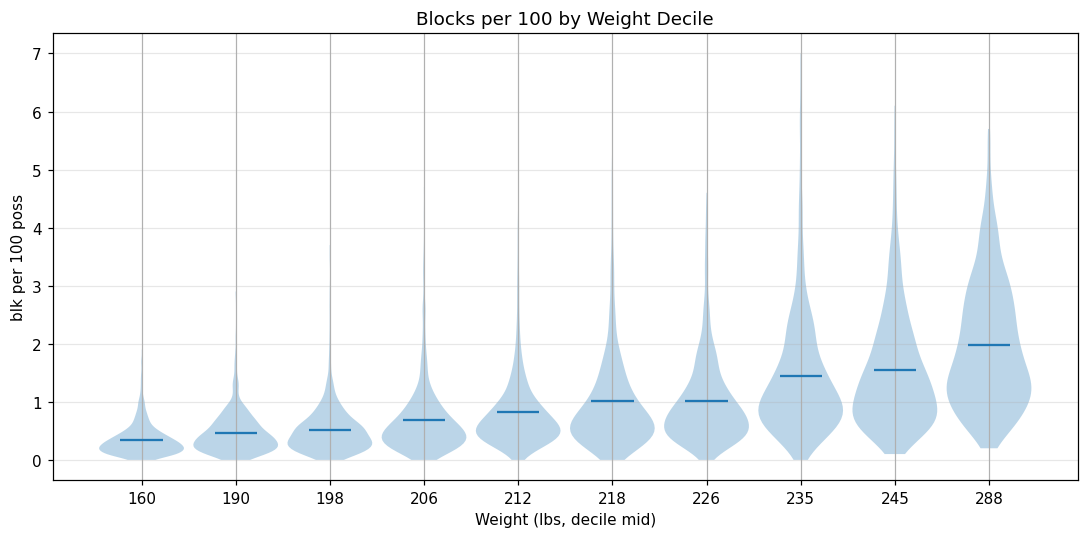

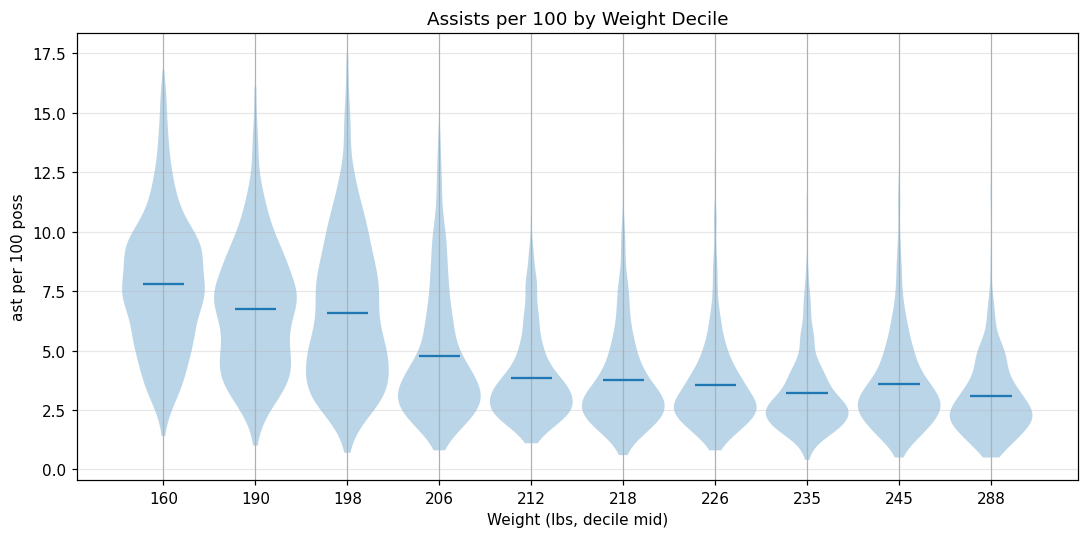


--- 5.2 Interaction Heatmaps (Height x Weight) ---


/tmp/ipython-input-304590198.py:80: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_shape.pivot_table(index="h_bin", columns="w_bin", values=tcol, aggfunc="median")
/tmp/ipython-input-304590198.py:80: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_shape.pivot_table(index="h_bin", columns="w_bin", values=tcol, aggfunc="median")
/tmp/ipython-input-304590198.py:80: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df_shape.pivot_table(index="h_bin", columns="w_bin", values=tcol, aggf

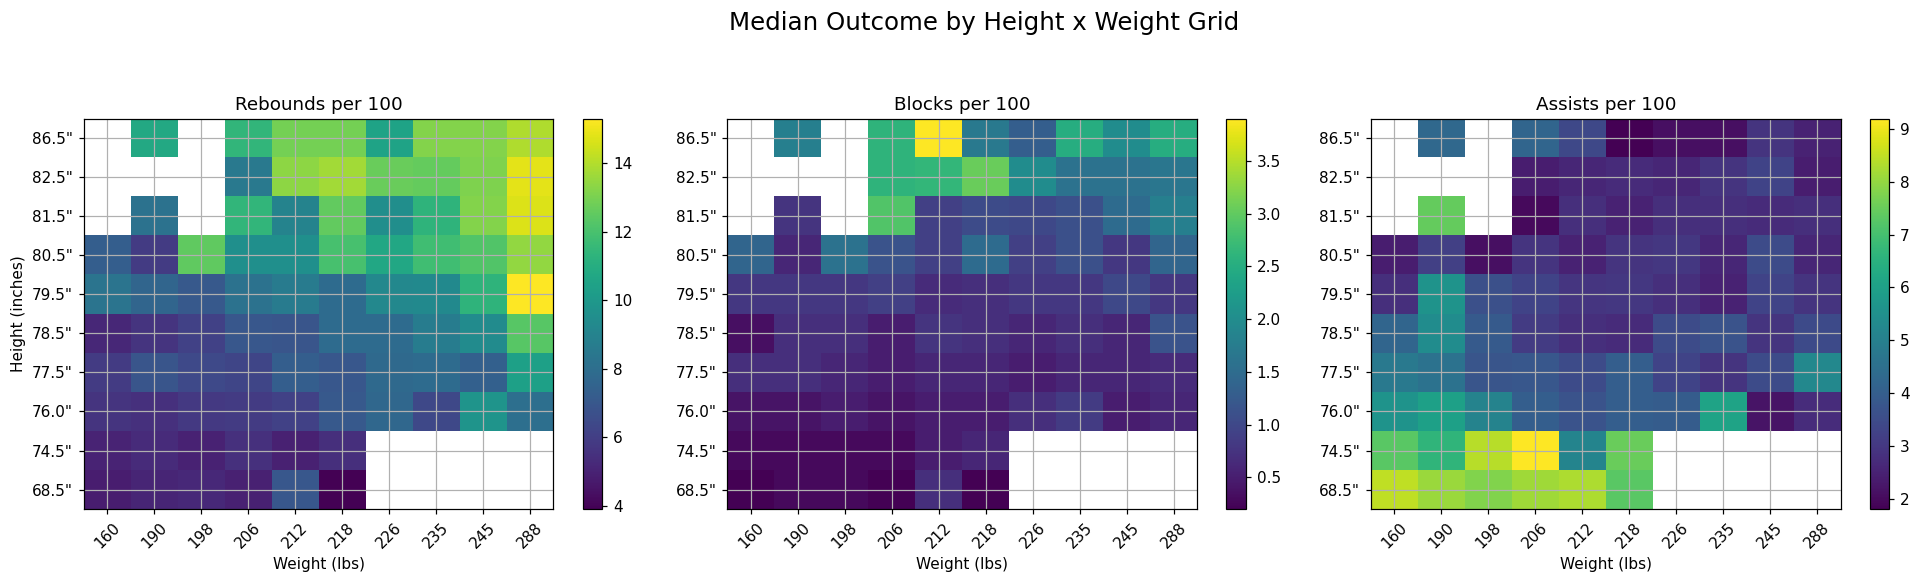


--- 5.3 Density (Hexbins) ---


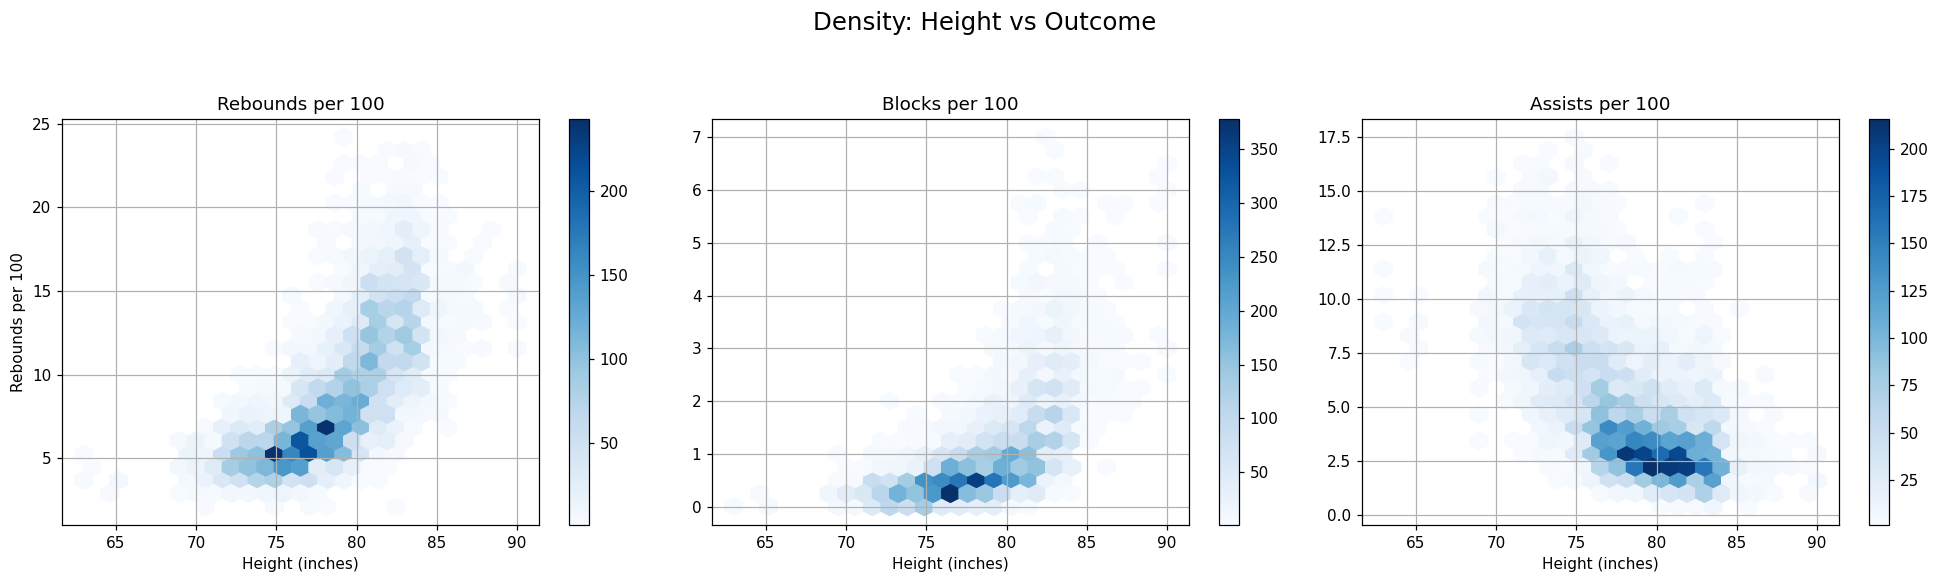

In [34]:
# Figure 5: Size–performance shape diagnostics (Final Polished)
# Includes: Violins (Height/Weight), Heatmaps (Interaction), and Hexbins (Density)

# --- 1. Helpers ---
def deciles(s):
    """Return decile bins handling duplicates."""
    return pd.qcut(pd.to_numeric(s, errors="coerce"), 10, duplicates='drop')

def midpoint(interval):
    """Safely return midpoint of an interval."""
    try:
        return interval.mid
    except:
        return np.nan

def _violin_by_bin(df, bin_col, target_col, x_label, title, label_fmt):
    """Helper to generate violin plots per bin."""
    cat = df[bin_col]
    order = [c for c in cat.cat.categories if not df.loc[cat == c, target_col].dropna().empty]

    data = [df.loc[cat == b, target_col].dropna().values for b in order]

    if not data: return

    labels = [label_fmt(midpoint(b)) for b in order]

    # Create figure
    plt.figure(figsize=(10, 5))
    plt.violinplot(data, showmeans=True, showextrema=False, widths=0.9)

    # Formatting
    plt.xticks(ticks=np.arange(1, len(order)+1), labels=labels, rotation=0)
    plt.xlabel(x_label)
    plt.ylabel(target_col.replace("_", " "))
    plt.title(title)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- 2. Setup Data ---
cols_shape = ["ht_in_in", "wt", "trb_per_100_poss", "blk_per_100_poss", "ast_per_100_poss"]
df_shape = base[cols_shape].dropna().copy()

targets = [
    ("trb_per_100_poss", "Rebounds per 100"),
    ("blk_per_100_poss", "Blocks per 100"),
    ("ast_per_100_poss", "Assists per 100"),
]

# --- 3. Violin Plots ---
print("--- 5.1 Violin Plots by Decile ---")

# A. By Height Decile
df_shape["h_bin"] = deciles(df_shape["ht_in_in"])
for tcol, tname in targets:
    _violin_by_bin(
        df_shape, "h_bin", tcol,
        "Height (inches, decile mid)", f"{tname} by Height Decile",
        lambda x: f"{x:.1f}\""
    )

# B. By Weight Decile
df_shape["w_bin"] = deciles(df_shape["wt"])
for tcol, tname in targets:
    _violin_by_bin(
        df_shape, "w_bin", tcol,
        "Weight (lbs, decile mid)", f"{tname} by Weight Decile",
        lambda x: f"{x:.0f}"
    )

# --- 4. Heatmaps (Interaction) ---
print("\n--- 5.2 Interaction Heatmaps (Height x Weight) ---")
plt.figure(figsize=(18, 5))
plt.suptitle("Median Outcome by Height x Weight Grid", fontsize=16, y=1.05)

for i, (tcol, tname) in enumerate(targets, 1):
    ax = plt.subplot(1, 3, i)

    # Pivot for heatmap
    pivot = df_shape.pivot_table(index="h_bin", columns="w_bin", values=tcol, aggfunc="median")

    if pivot.empty:
        ax.text(0.5, 0.5, "No data", ha="center", va="center")
        ax.set_axis_off()
        continue

    # Clean labels
    yticklabels = [f"{midpoint(i):.1f}\"" for i in pivot.index]
    xticklabels = [f"{midpoint(i):.0f}" for i in pivot.columns]

    # Explicit .values for safety
    im = ax.imshow(pivot.values, origin="lower", aspect="auto", cmap="viridis")
    plt.colorbar(im, ax=ax)

    ax.set_xticks(range(len(xticklabels)))
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_yticks(range(len(yticklabels)))
    ax.set_yticklabels(yticklabels)
    ax.set_title(tname)
    ax.set_xlabel("Weight (lbs)")
    if i == 1: ax.set_ylabel("Height (inches)")

plt.tight_layout()
plt.show()

# --- 5. Hexbin Density ---
print("\n--- 5.3 Density (Hexbins) ---")
plt.figure(figsize=(18, 5))
plt.suptitle("Density: Height vs Outcome", fontsize=16, y=1.05)

for i, (tcol, tname) in enumerate(targets, 1):
    ax = plt.subplot(1, 3, i)
    hb = ax.hexbin(df_shape["ht_in_in"], df_shape[tcol], gridsize=25, cmap="Blues", mincnt=1)
    ax.set_title(tname)
    ax.set_xlabel("Height (inches)")

    # Explicit Y-label for clarity
    if i == 1: ax.set_ylabel(f"{tname}")

    plt.colorbar(hb, ax=ax)

plt.tight_layout()
plt.show()

### **Figure 5: Interpretation (Size–Performance Shapes)**

#### **1. Violins by Height Decile**
- **TRB/100 (Rebounds):** Medians rise cleanly when moving to taller deciles, and the upper tails widen significantly. This indicates a strong, **monotone positive relationship**—taller players rebound more, and the elite rebounders are almost exclusively found in the top height deciles.
- **BLK/100 (Blocks):** The pattern is similar but steeper. Low height deciles are compressed near zero (guards rarely block), while the tallest deciles exhibit much higher medians and long right tails. Height appears to be a **prerequisite** for high block rates.
- **AST/100 (Assists):** The pattern **reverses**. The highest medians appear in the **shorter height deciles** (Guard range), then drift downward as height increases. Assists are **negatively related** to height, driven by role allocation (ball-handling guards vs. finishing bigs).

#### **2. Violins by Weight Decile**
- **TRB/100:** Medians generally climb with weight, but with more overlap between bins than for height. While being heavier confers an advantage, **weight alone is a noisier signal** than height for rebounding.
- **BLK/100:** Heavier deciles show higher typical block rates, but the relationship is weaker than for height. This aligns with the hypothesis that **reach and timing** matter more for rim protection than pure bulk.
- **AST/100:** As weight increases, medians tend to **drift downward**. Lighter players accumulate more assists, while heavier players more often function as finishers or screen-setters.

#### **3. Height $\times$ Weight Median Heatmaps**
- **TRB/100:** The heatmap reveals a bright **"Hot Corner"** in the tall-and-heavy region. True bigs dominate the rebounding landscape, while short/light cells remain in the single digits.
- **BLK/100:** Peaks appear almost exclusively in the same tall-heavy region but with greater sparsity. This reinforces blocks as a **"Big + Rim-Protector Role"** phenomenon; size is necessary but not sufficient.
- **AST/100:** The warmest cells concentrate among **shorter, lighter players**, cooling off toward taller, heavier profiles. The structure is visible but flatter than for rebounds/blocks—size explains some variance, but **position/role remains the dominant factor**.

#### **4. Hexbin Density Plots**
- **Rebounds & Blocks:** The density clouds slope **upward**, with high-value observations heavily concentrated in the upper size ranges (roughly 75–83 inches, 190–250 lb).
- **Assists:** The cloud tilts **downward**, confirming that most high-assist seasons come from shorter, lighter players.

**Overall Conclusion:**
The shape diagnostics confirm the modeling results:
1.  **Rebounds and Blocks** exhibit **strong, non-linear, size-driven structure**, validating the substantial $R^2$ gains seen with Random Forests.
2.  **Assists** depend only **weakly and negatively** on height/weight, explaining why even the best models reach only moderate $R^2$.

## **6. Summary and Conclusion**

The report investigated the extent to which **physique alone**—height, weight, age, and listed position—can explain three core box-score outcomes on a **per-100-possession** basis:

- **TRB/100** (Total Rebounds)
- **BLK/100** (Blocks)
- **AST/100** (Assists)

The analysis utilized player–season data across roughly two decades of NBA play. All advanced impact metrics and derived rate stats that might leak information were excluded from the feature set, leaving only body measurements, age, and coarse role (position). Targets were standardized to per-100-possession rates to reduce dependence on minutes and pace.

The modeling pipeline combined:
- **Baselines:** Global mean and Position mean.
- **Linear models:** Regularized linear models (Ridge, Lasso) in Scikit-Learn pipelines.
- **Non-linear models:** Random Forests to capture interaction effects and thresholds.
- **Validation:** Player-wise grouped CV for model selection and **season-wise walk-forward** evaluation to respect temporal order.

---

### **6.1 Predictive Performance**

Across grouped cross-validation and walk-forward tests, a distinct hierarchy emerged:

- **High Explanatory Power (TRB/100):**
  Physique-based models reached **$R^2 \approx 0.65–0.75$** in walk-forward evaluation. Ridge and Random Forest models substantially outperformed both global and position-mean baselines, confirming that rebounding is heavily constrained by physical tools.

- **Moderate Explanatory Power (BLK/100):**
  For blocks, best linear models and Random Forests achieved **$R^2 \approx 0.45–0.55$**. Physique and position remain clearly informative, but larger residual variance indicates that timing, scheme, and verticality contribute meaningfully beyond raw body size.

- **Moderate / Low Explanatory Power (AST/100):**
  For assists, even the best models reached only **$R^2 \approx 0.40–0.60$**. Improvements over the global mean were substantial, but gains over position-specific baselines were much weaker, suggesting that playmaking is primarily a function of **role and skill** rather than anthropometry.

Season-by-season diagnostics showed **no collapse in performance over time**, indicating that the relationship between body profile and these outcomes is **structurally stable across eras**.

---

### **6.2 Residual Structure and Positional Fairness**

Row-level predictions from the expanding walk-forward procedure revealed:

- **No Systemic Bias:** Residual boxplots showed **no large, unfair biases** for any position–target combination.
- **Rebounds:** The model **slightly over-predicted Power Forwards** and **under-predicted Centers**, consistent with the "true big" advantage.
- **Blocks:** Bigs (PF/C) blocked **slightly fewer shots** than predicted by size alone, suggesting that being tall is necessary but not sufficient for elite rim protection.
- **Assists:** Centers showed **positive mean residuals (under-prediction)**, aligning with the modern trend of "Playmaking Bigs" (e.g., Jokic, Sabonis) who create more offense than a naive size-based model expects.

---

### **6.3 Marginal Effects ("Physics Multipliers")**

A purely additive linear model quantified the local marginal effects:

$$
\hat{y} = \beta_0 + \beta_1 \cdot \text{height} + \beta_2 \cdot \text{weight} + \beta_3 \cdot \text{age} + \gamma_{\text{pos}}
$$

From this model:
- **Height:** Each additional inch adds roughly **+0.20 Rebounds** and **+0.10 Blocks** per 100 possessions.
- **Weight:** Each additional 10 lbs adds roughly **+0.25–0.30 Rebounds**.
- **Assists:** Height and weight coefficients were **weak and slightly negative**, confirming that shorter, lighter players are generally more assist-oriented.

These "physics multipliers" provide a simple interpretation: physique supplies a **baseline stat profile** for rebounding and rim protection, whereas assists depend on skill allocation.

---

### **6.4 Empirical Shapes**

Non-parametric shape diagnostics (Figure 5) confirmed that the fitted models align with the raw data:
- **Monotonicity:** Rebounds and Blocks show strong, monotonic increases with height and weight.
- **Inversion:** Assist distributions flatten or invert at larger sizes, explaining the limited headroom for predictive models on that target.
- **Thresholds:** Heatmaps showed a clear **Tall + Heavy "Hot Corner"** for Rebounds and Blocks, validating the use of non-linear models.

---

### **6.5 Profile Interpretation**

The fitted models successfully mapped individual body profiles (e.g., a **6'3", 225 lb SG**) to expected outcomes, generating position-aware benchmarks. This demonstrated that the models can distinguish between a player who is "physically typical" vs. one who is "physically exceptional" for their role.

---

### **6.6 Limitations and Future Directions**

**Limitations:**
- **Static Inputs:** No tracking data, wingspan, or vertical leap measurements were available.
- **Role Coarseness:** "Position" (PG/SG/etc.) is a noisy proxy for actual on-court role.
- **Season-Level Supervision:** Models are cross-sectional; player development trajectories were not explicitly modeled.

**Future Work:**
- **Tracking Data:** Incorporating speed and spacing metrics could bridge the gap for defensive stats.
- **Hierarchical Models:** Mixed-effects models could separate player talent from team context.
- **Forecasting:** Extending the walk-forward framework to predict *next season's* performance based on current physique + prior stats.

---

### **6.7 Overall Conclusion**

The evidence indicates that **NBA body size is a strong, stable signal for rebounding and rim protection**, but only a **coarse prior for playmaking**.

- For **Rebounds/Blocks**, biology sets a high floor; the relationship is structural and non-linear.
- For **Assists**, biology is secondary; role and skill are the primary differentiators.

**Final Verdict:** Physique functions as a reliable **baseline generator** for physical tasks, while offensive production remains the domain of skill and usage.
